<a href="https://colab.research.google.com/github/MOREDataset/IceFeature_Forecasting/blob/main/ArcticIceSea_Forecasting_1m_EXPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **START**

In [ ]:
# **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
from tsai.all import *
computer_setup()

os             : Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
python         : 3.7.13
tsai           : 0.3.1
fastai         : 2.7.7
fastcore       : 1.5.13
torch          : 1.11.0+cu102
device         : 1 gpu (['Tesla P100-PCIE-16GB'])
cpu cores      : 4
RAM            : 25.46 GB
GPU memory     : [15.9] GB


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


 # **CONFIGURATION**

In [ ]:
# CONFIGURATION
model_name  = TSTPlus#
par = {}#'levels':4, 'base_arch': InceptionTimePlus}#,  'wavelet': 'db4'}#, 'base_arch':InceptionTime'}#'hidden_size':[100, 50], 'n_layers':2}#{'levels':4}, 'wavelet': None, 'base_arch': InceptionTimePlus}#,  'wavelet': 'db4'}#, 'base_arch':InceptionTime}
ind = ''
freeze_epoch = 25
IMFS_count = 4
season1 = 'FallWinter'
season2 = 'SpringSummer'

In [ ]:
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
!pip install optuna -U >> /dev/null
from tsai.all import *
import optuna
my_setup(optuna)
set_seed(42, False)

#set hyperparameter tuning for every model from the start 
import optuna
from optuna.integration import FastAIPruningCallback


def objective1(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    # nf = trial.suggest_categorical('num_filters', [32, 64, 96]) # search through all categorical values in the provided list
    d_model = trial.suggest_categorical('d_model', [128,256,512,1024])  
    n_heads = trial.suggest_int('n_heads', 8, 16, step=8) 
    act = trial.suggest_categorical('act', ['relu','gelu']) 
    d_ff = trial.suggest_categorical('d_ff', [256, 384, 512]) 
    n_layers = trial.suggest_int('n_layers', 2, 8, step=1) 
    fc_dropout = trial.suggest_float('fc_dropout', 0,0.5) 
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True) 

    learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512,
                         arch=model_name, arch_config=par,
                         metrics=rmse) #, cbs=FastAIPruningCallback(trial)
                         
    with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
        learn.fit_one_cycle(5, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][1] # return the validation loss value of the last epoch 

def objective2(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    # nf = trial.suggest_categorical('num_filters', [32, 64, 96]) # search through all categorical values in the provided list
    bottleneck = trial.suggest_categorical('bottleneck', [True, False])
    coord = trial.suggest_categorical('coord', [True, False])  
    separable = trial.suggest_categorical('separable', [True, False])
    zero_norm = trial.suggest_categorical('zero_norm', [True, False])
    nf = trial.suggest_int('nf', 8, 64, step=8) 
    ks = trial.suggest_int('ks', 20, 80, step=20) 
    conv_dropout = trial.suggest_float('conv_dropout', 0, 0.5) 
    fc_dropout = trial.suggest_float('fc_dropout', 0,0.5) 
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True) 

    learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512,
                         arch=model_name, arch_config=par,
                         metrics=rmse)# , cbs=FastAIPruningCallback(trial))
                         
    with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
        learn.fit_one_cycle(5, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][1] # return the validation loss value of the last epoch 

def objective3(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    # nf = trial.suggest_categorical('num_filters', [32, 64, 96]) # search through all categorical values in the provided list
    n_layers = trial.suggest_int('n_layers', 3, 8, step=1) 
    bias = trial.suggest_categorical('bias', [True,False]) 
    rnn_dropout = trial.suggest_float("rnn_dropout",0, 0.5) 
    bidirectional = trial.suggest_categorical('bidirectional', [True,False])
    fc_dropout = trial.suggest_float('fc_dropout', 0,0.5) 
    bn = trial.suggest_categorical('bn', [True,False])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True) 

    learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512,
                         arch=model_name, arch_config=par,
                         metrics=rmse)# , cbs=FastAIPruningCallback(trial))
                         
    with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
        learn.fit_one_cycle(5, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][1] # return the validation loss value of the last epoch 

def tuning(model_name):
  if (model_name.__name__=='TSTPlus'):
    study.optimize(objective1, n_trials=100)
  elif (model_name.__name__=='InceptionTimePlus'):
    study.optimize(objective2, n_trials=100)
  elif (model_name.__name__=='LSTMPlus'):
    study.optimize(objective3, n_trials=100)


def tuned_hyperparameters(model_name):
  if (model_name.__name__=='TSTPlus'):
    par = {'d_model':d_model,'n_heads':n_heads,'act':act,'d_ff':d_ff,'n_layers':n_layers,'fc_dropout':fc_dropout}
  elif (model_name.__name__=='InceptionTimePlus'):
    par = {'bottleneck':bottleneck,'coord':coord,'separable':separable,'zero_norm':zero_norm,'nf':nf,'ks':ks,'conv_dropout':conv_dropout,'fc_dropout':fc_dropout}
  elif (model_name.__name__=='LSTMPlus'):
    par = {'n_layers':n_layers, 'bias':bias, 'rnn_dropout':rnn_dropout, 'bidirectional':bidirectional,'fc_dropout':fc_dropout, 'bn':bn}
  return par

os             : Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
python         : 3.7.13
tsai           : 0.3.1
fastai         : 2.7.7
fastcore       : 1.5.6
optuna         : 2.10.1
torch          : 1.11.0+cu102
device         : 1 gpu (['Tesla P100-PCIE-16GB'])
cpu cores      : 4
RAM            : 25.46 GB
GPU memory     : [15.9] GB


# Thickness forecasting next month

## season1

In [ ]:
season = season1

### no VMD - Thickness + time info.

In [ ]:
ind = ''
mode = 'ThickTime_'
Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + season + '.csv',header=None)
Thick

0      1      2      3      4      5      6      7      8      9   \
0     1.951  1.955  1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974   
1     1.955  1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974   
2     1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977   
3     1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977  1.984   
4     1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977  1.984  1.987   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4666  1.381  1.381  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424   
4667  1.381  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428   
4668  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436   
4669  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436  1.441   
4670  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436  1.441  1.446   

      ...     50     51     52     53     54     55     56     57     58  \
0     ...  2.141  2.144  2.144  2.144  2.141  2.137  2.136  2.135  2.139   
1     ...  2.144  2.144  2.144  2.141  2.137  2.136  2.135  2.139  2.147   
2     ...  2.144  2.144  2.141  2.137  2.136  2.135  2.139  2.147  2.151   
3     ...  2.144  2.141  2.137  2.136  2.135  2.139  2.147  2.151  2.153   
4     ...  2.141  2.137  2.136  2.135  2.139  2.147  2.151  2.153  2.152   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4666  ...  1.646  1.648  1.647  1.653  1.653  1.656  1.660  1.665  1.666   
4667  ...  1.648  1.647  1.653  1.653  1.656  1.660  1.665  1.666  1.672   
4668  ...  1.647  1.653  1.653  1.656  1.660  1.665  1.666  1.672  1.676   
4669  ...  1.653  1.653  1.656  1.660  1.665  1.666  1.672  1.676  1.681   
4670  ...  1.653  1.656  1.660  1.665  1.666  1.672  1.676  1.681  1.687   

         59  
0     2.147  
1     2.151  
2     2.153  
3     2.152  
4     2.150  
...     ...  
4666  1.672  
4667  1.676  
4668  1.681  
4669  1.687  
4670  1.692  

[4671 rows x 60 columns]

#### Hyperparameter tuning

Processing Thickness data..
splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


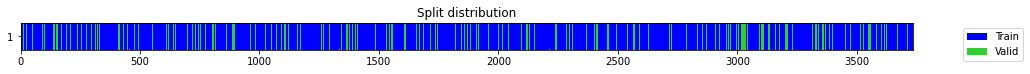

In [ ]:
split_indx = 30

print('Processing Thickness data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ['Signal']
row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

test_targetdata={}
test_predsdata={}

test_targetdata={}
test_predsdata={}

print('splitting data..')
Thick_data = to3d(Thick.iloc[:,:].values)
# Temp_data = to3d(Temp.iloc[:,:].values)
data = np.concatenate([Thick_data, TS_D, TS_Y, TS_M],axis=1)  #, TS_Mend, TS_Mstart
data_X = data[:,:,:split_indx]
data_y = data[:,0,split_indx:]
X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
print('Standardizing data..')
for i in range(X_train.shape[1]): #normalize IN data
  scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
  X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
scalersOUT['Signal'] = StandardScaler() #normalize OUT data
y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
tfms  = [None, [ToFloat(), ToNumpyTensor()]]
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
#**************#**************#**************#**************#**************#**************#**************#**************

In [ ]:
study = optuna.create_study(direction='minimize')
print(f"Sampler is {study.sampler.__class__.__name__}")

tuning(model_name)

print("**Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("{}".format(value))

[I 2022-07-24 22:36:48,898] A new study created in memory with name: no-name-89470b83-2367-4c6e-8bfe-337269f4b052


Sampler is TPESampler


[I 2022-07-24 22:36:54,067] Trial 0 finished with value: 0.06283494085073471 and parameters: {'bottleneck': False, 'coord': False, 'separable': False, 'zero_norm': False, 'nf': 40, 'ks': 40, 'conv_dropout': 0.45185087966793047, 'fc_dropout': 0.04771682914638631, 'learning_rate': 0.0012831876903112696}. Best is trial 0 with value: 0.06283494085073471.
[I 2022-07-24 22:36:59,914] Trial 1 finished with value: 0.06973515450954437 and parameters: {'bottleneck': False, 'coord': False, 'separable': True, 'zero_norm': False, 'nf': 40, 'ks': 80, 'conv_dropout': 0.11205596989078392, 'fc_dropout': 0.049146380318299876, 'learning_rate': 0.0025576012875638196}. Best is trial 0 with value: 0.06283494085073471.
[I 2022-07-24 22:37:05,693] Trial 2 finished with value: 0.10425420850515366 and parameters: {'bottleneck': True, 'coord': False, 'separable': False, 'zero_norm': True, 'nf': 8, 'ks': 40, 'conv_dropout': 0.28179761110093354, 'fc_dropout': 0.4405646654553716, 'learning_rate': 0.0021333028300368

**Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.049069203436374664
  Params: 
True
False
True
True
32
20
0.11249360540920694
0.14491599263811256
0.001937359246077691


#### Model learning

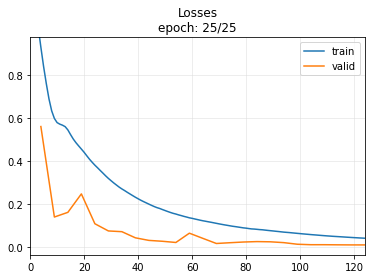

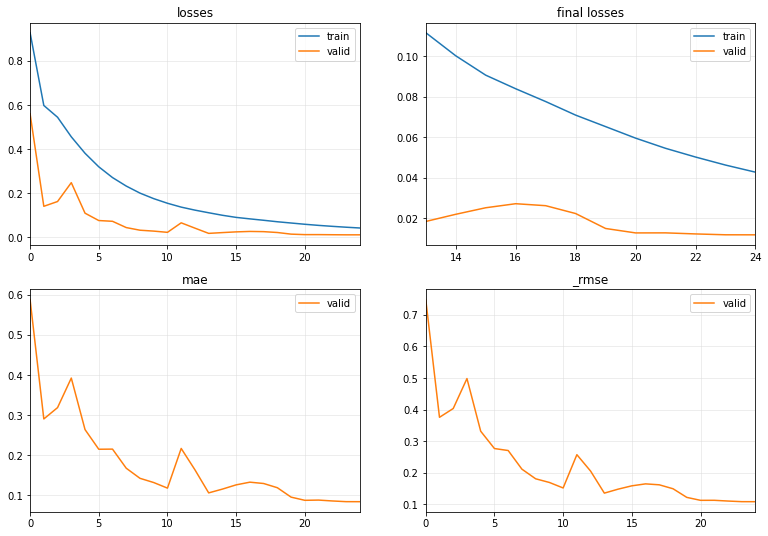

Targets and Predictions shapes (934, 30) (934, 30)
InceptionTimePlus : MAPE =  3.679832785861531 MAE =  0.04986263123268173 RMSE =  0.0599761770613861


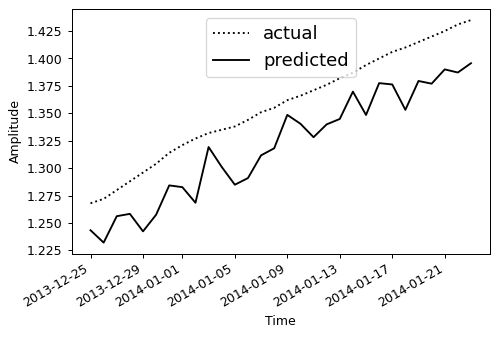

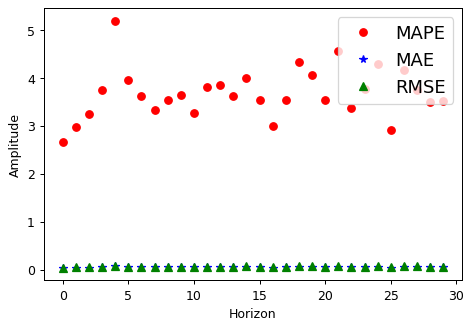

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

#Model learning
learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
learn.fit_one_cycle(freeze_epoch, learning_rate)
# #save trained model
# learn.save_all(path='/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export', dls_fname='dls', model_fname='WP_TIME_multistep_' + learn.model.__class__.__name__ + '_' + HOUSE, learner_fname='learner')
valid_dl = dls.valid

# Labeled test data
for i in range(X_test.shape[1]): #normalize IN data
  X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
y_test = scalersOUT['Signal'][0].transform(y_test)  
test_ds = valid_dl.dataset.add_test(X_test, y_test)
test_dl = valid_dl.new(test_ds)
_, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
#denormalize data
test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
del temp_targets, temp_preds
# RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
d = pd.DataFrame([])
d = test_targetdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', d, delimiter=',')
dp = pd.DataFrame([])
dp = test_predsdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', dp, delimiter=',')

#TEST MODEL
import numpy as np
import matplotlib.pyplot as plt
print('Targets and Predictions shapes', d.shape, dp.shape)

MAPE = []
MAE  = []
RMSE = []
for i in range(d.shape[1]): 
  MAPE.append(np.mean(np.abs((d[:,i] - dp[:,i]) / d[:,i]))*100)
  MAE.append(np.mean(np.abs((d[:,i] - dp[:,i]))))
  RMSE.append(np.sqrt(np.mean((d[:,i] - dp[:,i])**2)))
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], d[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dp[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### no VMD - Time info. only

In [ ]:
ind = ''
mode = 'Time_'
Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + season + '.csv',header=None)
Thick

0      1      2      3      4      5      6      7      8      9   \
0     1.951  1.955  1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974   
1     1.955  1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974   
2     1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977   
3     1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977  1.984   
4     1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977  1.984  1.987   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4666  1.381  1.381  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424   
4667  1.381  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428   
4668  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436   
4669  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436  1.441   
4670  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436  1.441  1.446   

      ...     50     51     52     53     54     55     56     57     58  \
0     ...  2.141  2.144  2.144  2.144  2.141  2.137  2.136  2.135  2.139   
1     ...  2.144  2.144  2.144  2.141  2.137  2.136  2.135  2.139  2.147   
2     ...  2.144  2.144  2.141  2.137  2.136  2.135  2.139  2.147  2.151   
3     ...  2.144  2.141  2.137  2.136  2.135  2.139  2.147  2.151  2.153   
4     ...  2.141  2.137  2.136  2.135  2.139  2.147  2.151  2.153  2.152   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4666  ...  1.646  1.648  1.647  1.653  1.653  1.656  1.660  1.665  1.666   
4667  ...  1.648  1.647  1.653  1.653  1.656  1.660  1.665  1.666  1.672   
4668  ...  1.647  1.653  1.653  1.656  1.660  1.665  1.666  1.672  1.676   
4669  ...  1.653  1.653  1.656  1.660  1.665  1.666  1.672  1.676  1.681   
4670  ...  1.653  1.656  1.660  1.665  1.666  1.672  1.676  1.681  1.687   

         59  
0     2.147  
1     2.151  
2     2.153  
3     2.152  
4     2.150  
...     ...  
4666  1.672  
4667  1.676  
4668  1.681  
4669  1.687  
4670  1.692  

[4671 rows x 60 columns]

Processing Thickness data..
splitting data..
Standardizing data..
training set:  (3737, 3, 30) (3737, 30) , testing set:  (934, 3, 30) (934, 30)


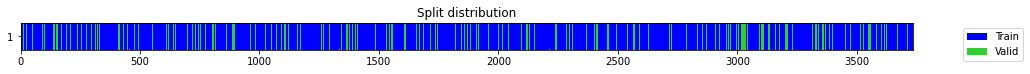

In [ ]:
split_indx = 30

print('Processing Thickness data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ['Signal']
row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

test_targetdata={}
test_predsdata={}

test_targetdata={}
test_predsdata={}

print('splitting data..')
Thick_data = to3d(Thick.iloc[:,:].values)
data = np.concatenate([TS_D, TS_Y, TS_M],axis=1) 
data_X = data[:,:,:split_indx]
data_y = Thick_data[:,0,split_indx:]
X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
print('Standardizing data..')
for i in range(X_train.shape[1]): #normalize IN data
  scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
  X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
scalersOUT['Signal'] = StandardScaler() #normalize OUT data
y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
tfms  = [None, [ToFloat(), ToNumpyTensor()]]
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
#**************#**************#**************#**************#**************#**************#**************#**************

#### Model learning

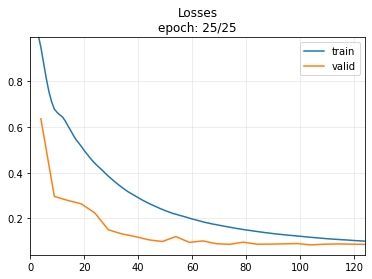

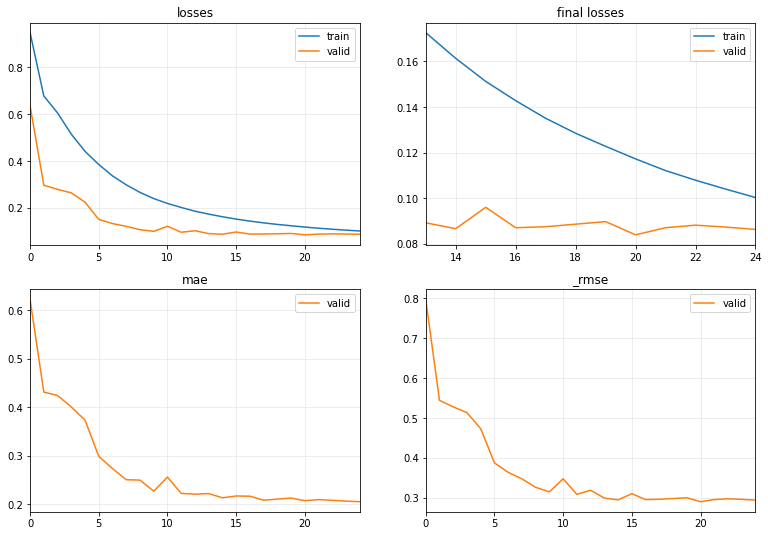

Targets and Predictions shapes (934, 30) (934, 30)
InceptionTimePlus : MAPE =  11.092145607832254 MAE =  0.15337973818441164 RMSE =  0.17030230707340543


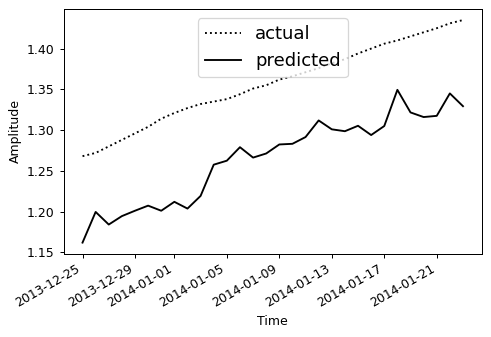

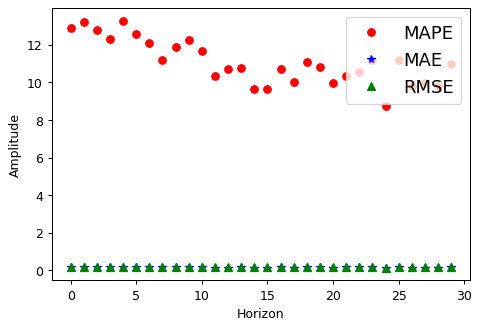

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

#Model learning
learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
learn.fit_one_cycle(freeze_epoch, learning_rate)
# #save trained model
# learn.save_all(path='/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export', dls_fname='dls', model_fname='WP_TIME_multistep_' + learn.model.__class__.__name__ + '_' + HOUSE, learner_fname='learner')
valid_dl = dls.valid

# Labeled test data
for i in range(X_test.shape[1]): #normalize IN data
  X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
y_test = scalersOUT['Signal'][0].transform(y_test)  
test_ds = valid_dl.dataset.add_test(X_test, y_test)
test_dl = valid_dl.new(test_ds)
_, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
#denormalize data
test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
del temp_targets, temp_preds
# RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
d = pd.DataFrame([])
d = test_targetdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', d, delimiter=',')
dp = pd.DataFrame([])
dp = test_predsdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', dp, delimiter=',')

#TEST MODEL
import numpy as np
import matplotlib.pyplot as plt
print('Targets and Predictions shapes', d.shape, dp.shape)

MAPE = []
MAE  = []
RMSE = []
for i in range(d.shape[1]): 
  MAPE.append(np.mean(np.abs((d[:,i] - dp[:,i]) / d[:,i]))*100)
  MAE.append(np.mean(np.abs((d[:,i] - dp[:,i]))))
  RMSE.append(np.sqrt(np.mean((d[:,i] - dp[:,i])**2)))
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], d[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dp[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### with VMD - Thickness + time info.

In [ ]:
ind = '31IMFs';
mode = 'ThickTime_'
Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + season + '.csv',header=None)
VMD_Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + ind + '_' + season + '.csv')
VMD_Thick = VMD_Thick.drop(columns='Element0')
Thick

0      1      2      3      4      5      6      7      8      9   \
0     1.951  1.955  1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974   
1     1.955  1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974   
2     1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977   
3     1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977  1.984   
4     1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977  1.984  1.987   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4666  1.381  1.381  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424   
4667  1.381  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428   
4668  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436   
4669  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436  1.441   
4670  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436  1.441  1.446   

      ...     50     51     52     53     54     55     56     57     58  \
0     ...  2.141  2.144  2.144  2.144  2.141  2.137  2.136  2.135  2.139   
1     ...  2.144  2.144  2.144  2.141  2.137  2.136  2.135  2.139  2.147   
2     ...  2.144  2.144  2.141  2.137  2.136  2.135  2.139  2.147  2.151   
3     ...  2.144  2.141  2.137  2.136  2.135  2.139  2.147  2.151  2.153   
4     ...  2.141  2.137  2.136  2.135  2.139  2.147  2.151  2.153  2.152   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4666  ...  1.646  1.648  1.647  1.653  1.653  1.656  1.660  1.665  1.666   
4667  ...  1.648  1.647  1.653  1.653  1.656  1.660  1.665  1.666  1.672   
4668  ...  1.647  1.653  1.653  1.656  1.660  1.665  1.666  1.672  1.676   
4669  ...  1.653  1.653  1.656  1.660  1.665  1.666  1.672  1.676  1.681   
4670  ...  1.653  1.656  1.660  1.665  1.666  1.672  1.676  1.681  1.687   

         59  
0     2.147  
1     2.151  
2     2.153  
3     2.152  
4     2.150  
...     ...  
4666  1.672  
4667  1.676  
4668  1.681  
4669  1.687  
4670  1.692  

[4671 rows x 60 columns]

In [ ]:
split_indx = 30

print('Processing Thick and time data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ["IMF{}".format(x) for x in range (0,IMFS_count+1,1)]
row = ["feature{}".format(x) for x in np.array(range(5))]
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = {'n_layers':n_layers, 'bias':bias, 'rnn_dropout':rnn_dropout, 'bidirectional':bidirectional,'fc_dropout':fc_dropout, 'bn':bn}

temp_targets = {}
temp_preds = {}
test_targetdata={}
test_predsdata={}


Processing Thick and time data..


##### Model learning

-IMF 0 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


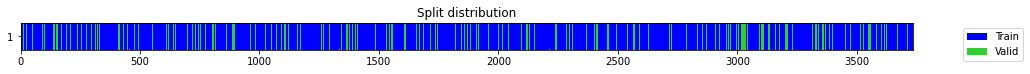

number of model outputs: 1


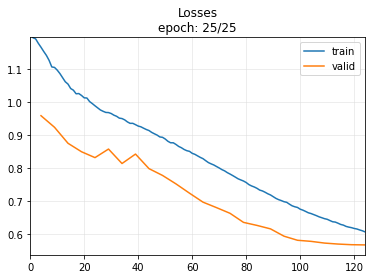

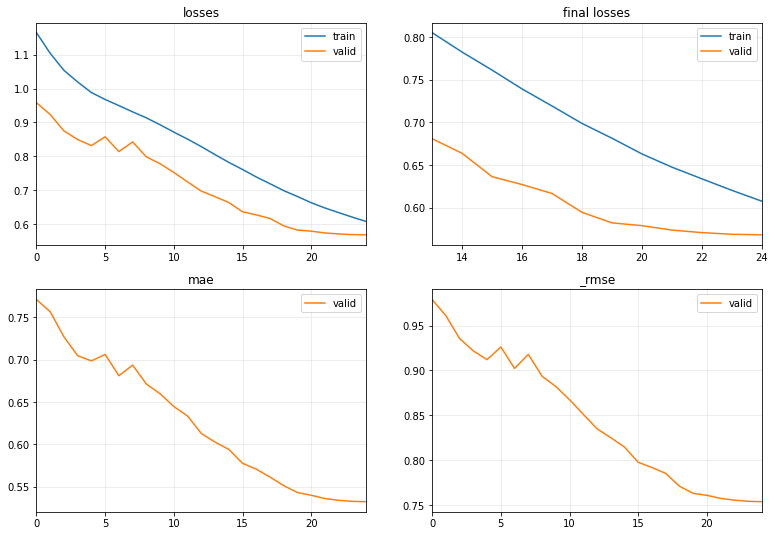

-IMF 1 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


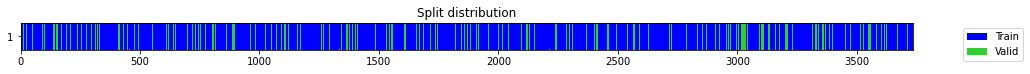

number of model outputs: 1


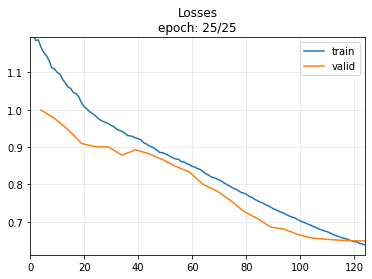

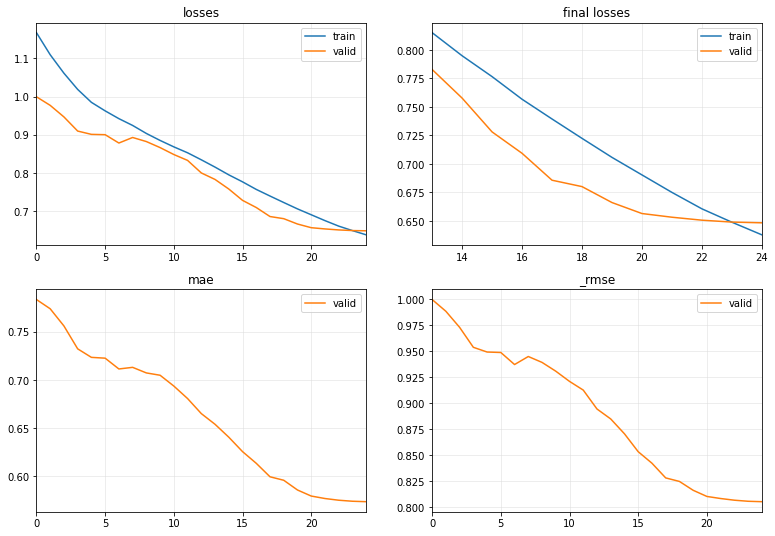

-IMF 2 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


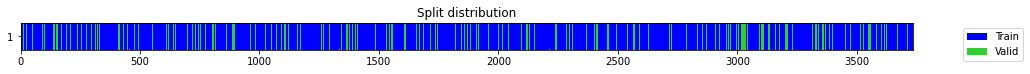

number of model outputs: 1


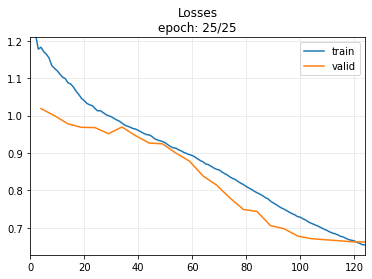

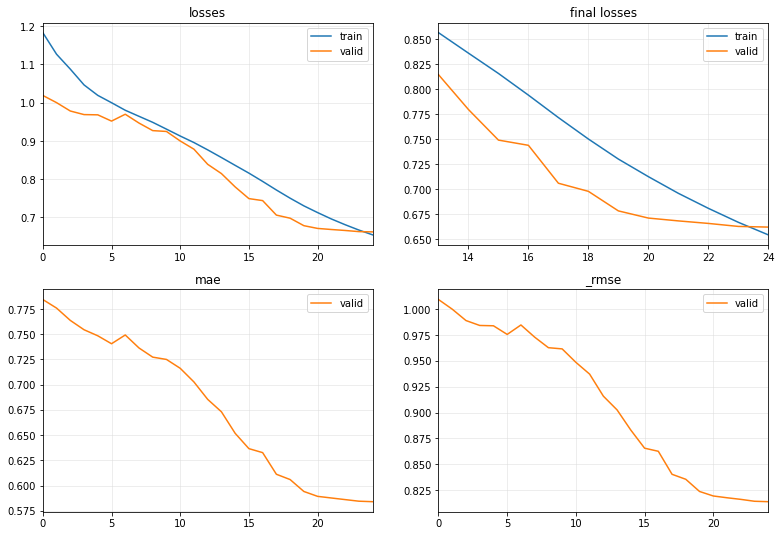

-IMF 3 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


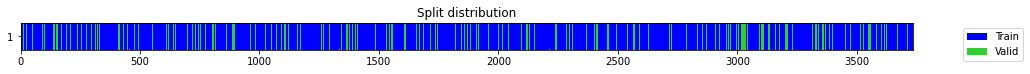

number of model outputs: 1


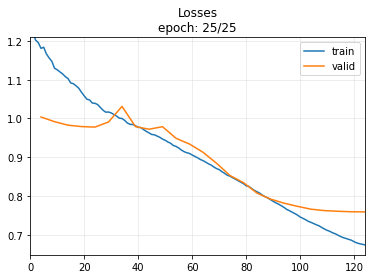

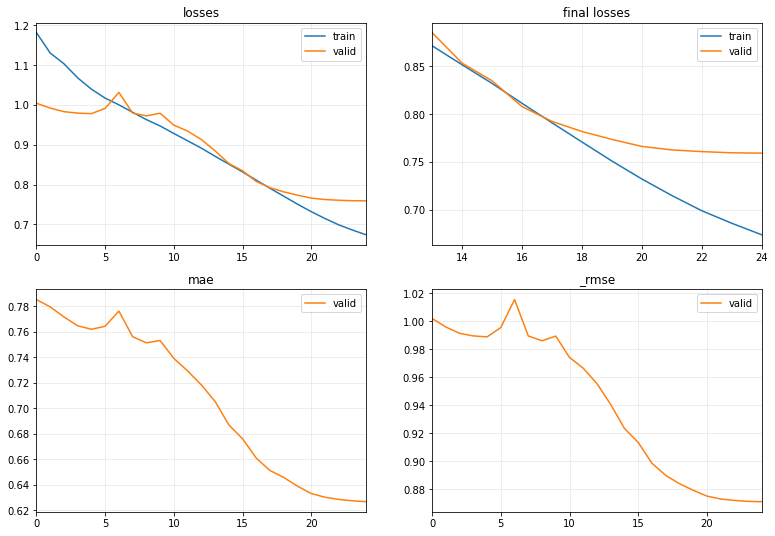

-IMF 4 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


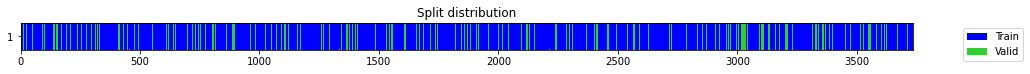

number of model outputs: 1


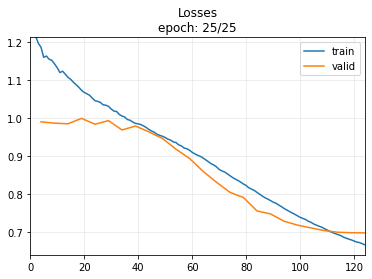

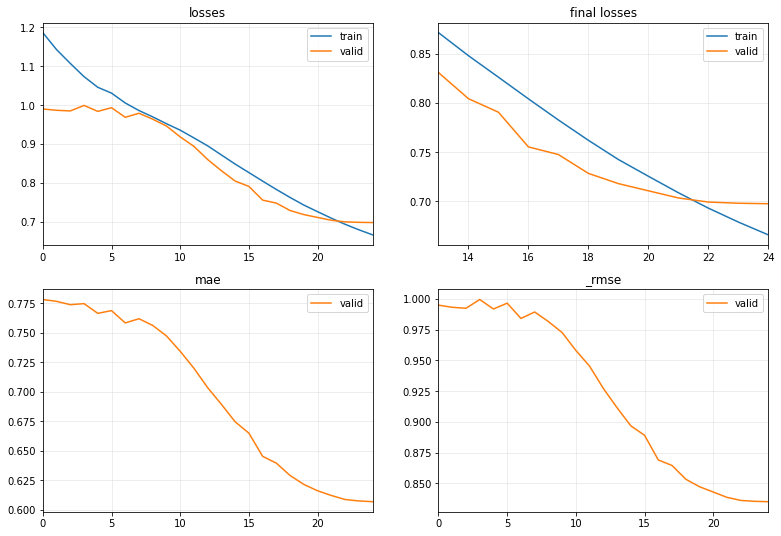

-IMF 5 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


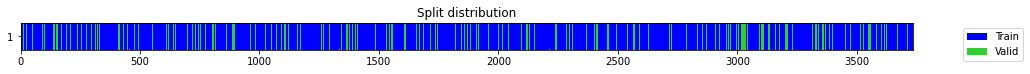

number of model outputs: 1


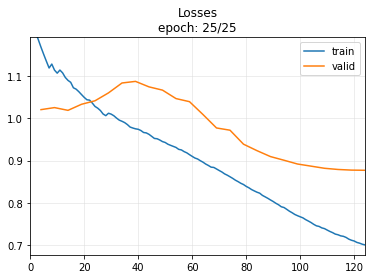

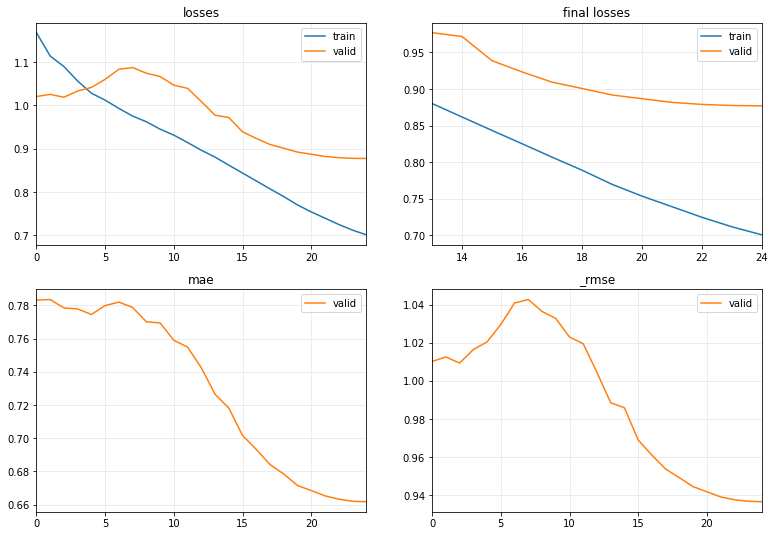

-IMF 6 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


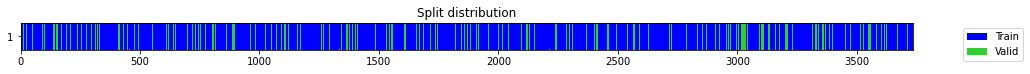

number of model outputs: 1


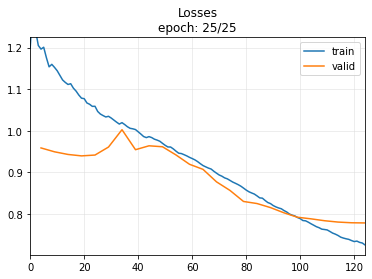

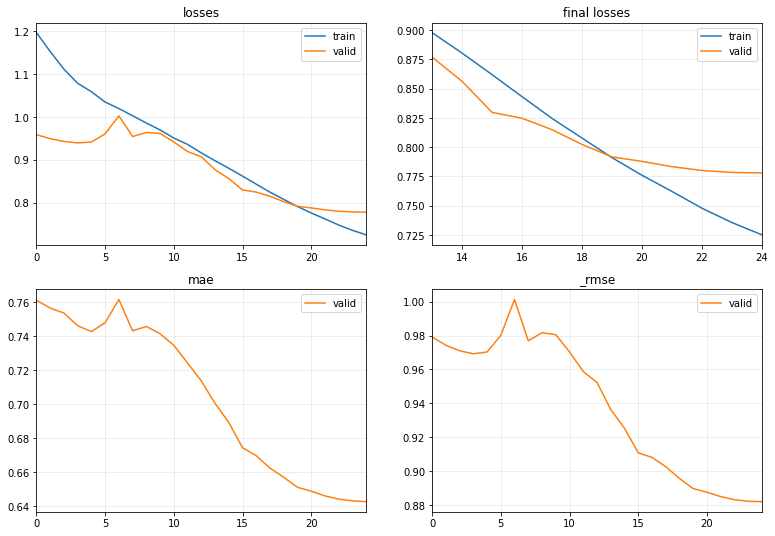

-IMF 7 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


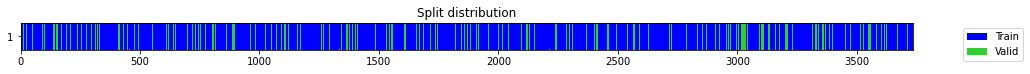

number of model outputs: 1


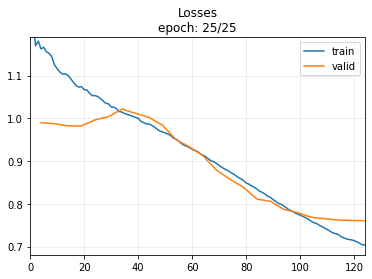

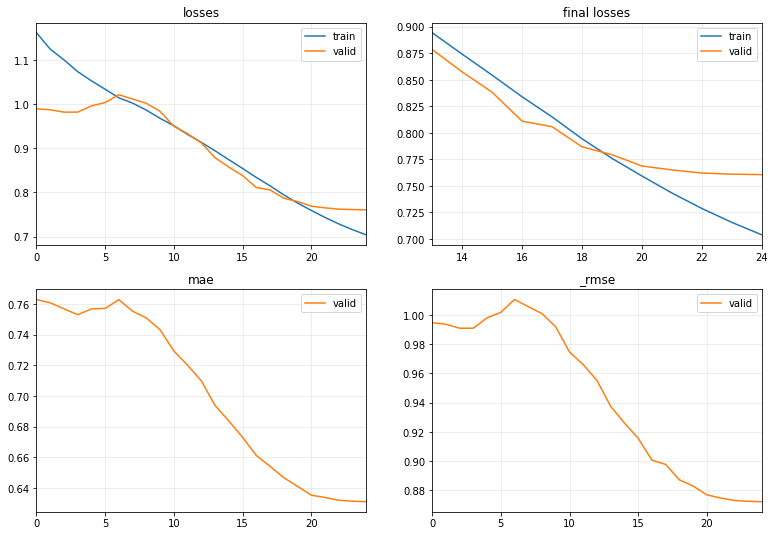

-IMF 8 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


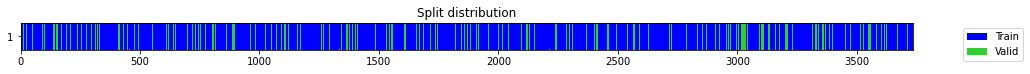

number of model outputs: 1


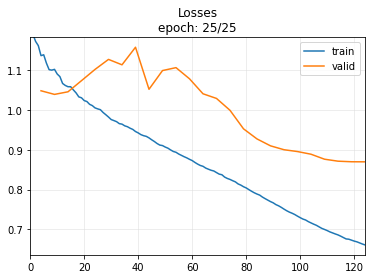

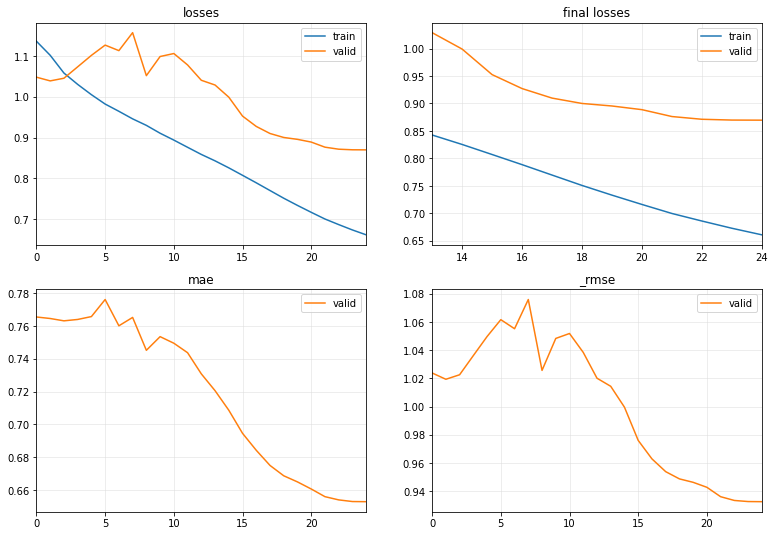

-IMF 9 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


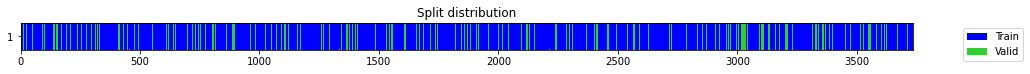

number of model outputs: 1


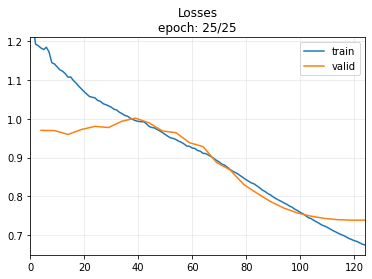

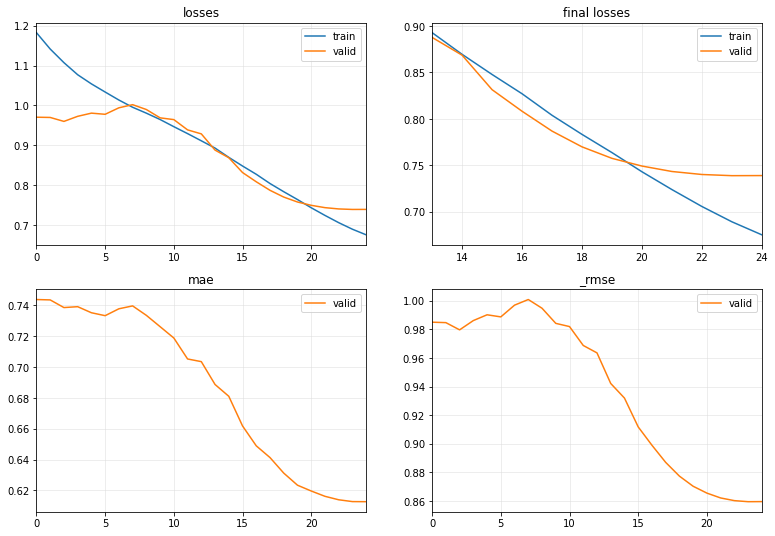

-IMF 10 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


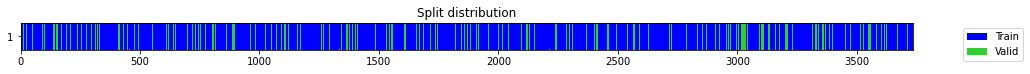

number of model outputs: 1


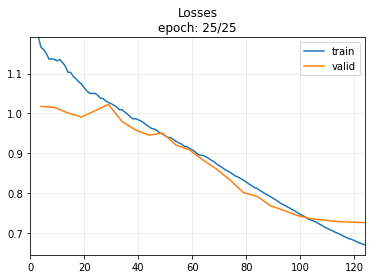

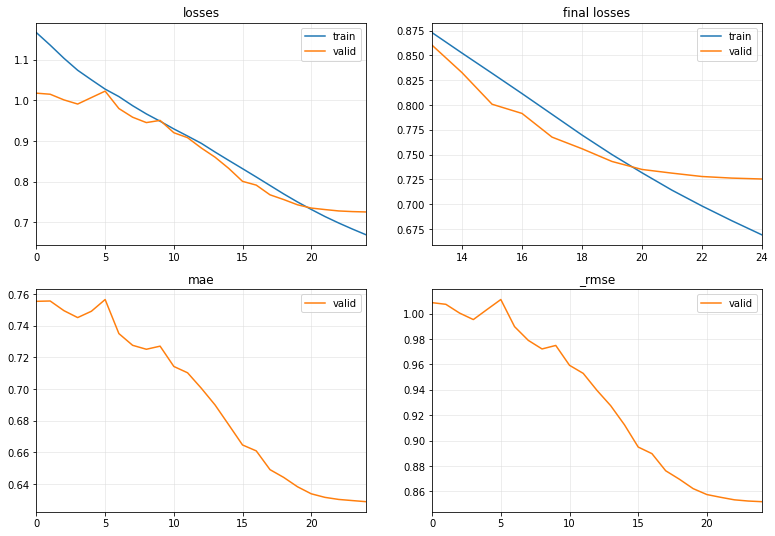

-IMF 11 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


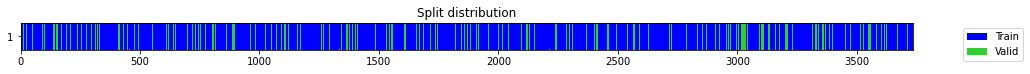

number of model outputs: 1


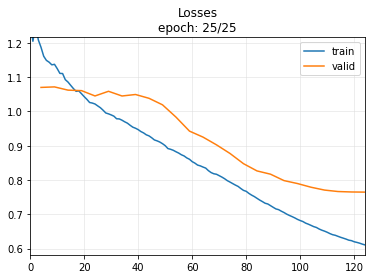

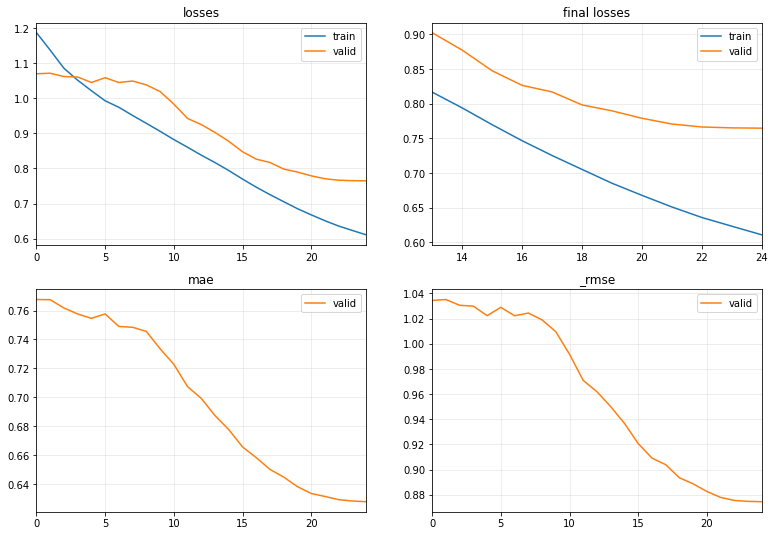

-IMF 12 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


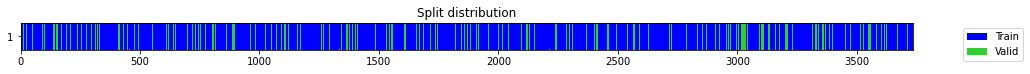

number of model outputs: 1


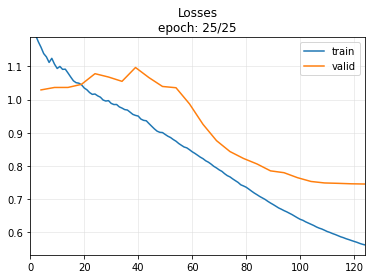

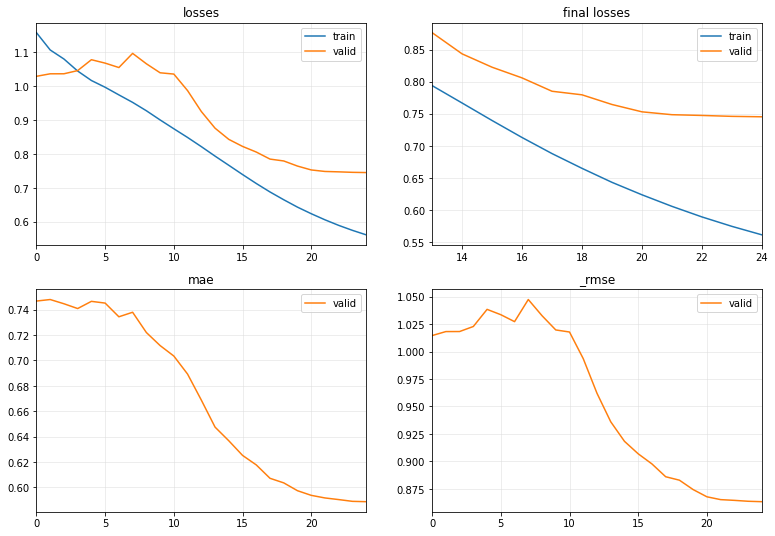

-IMF 13 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


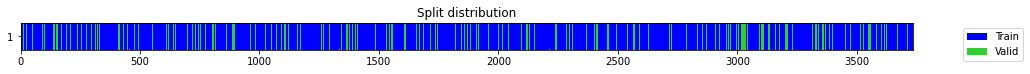

number of model outputs: 1


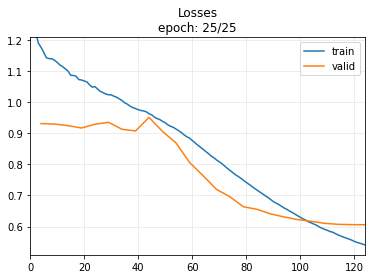

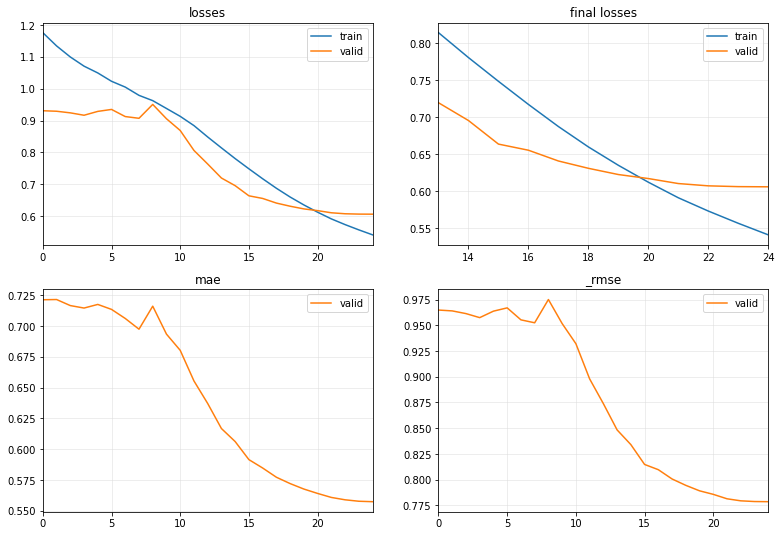

-IMF 14 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


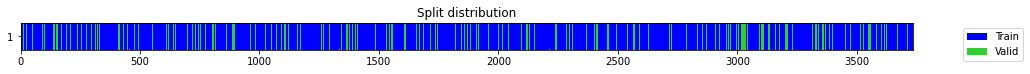

number of model outputs: 1


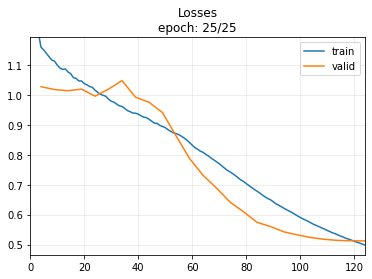

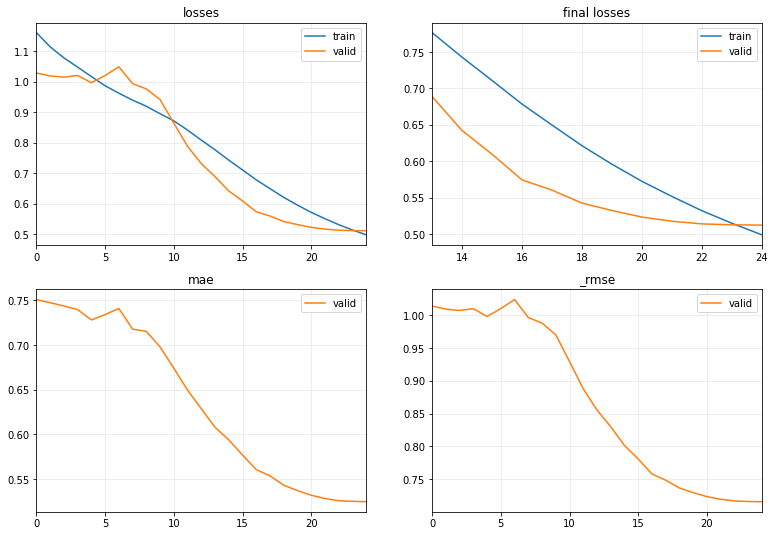

-IMF 15 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


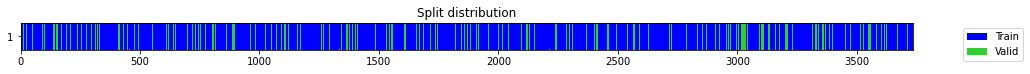

number of model outputs: 1


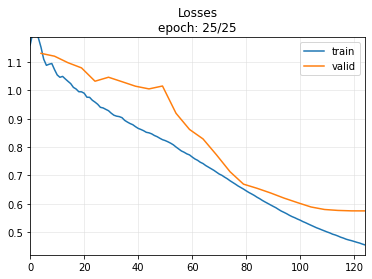

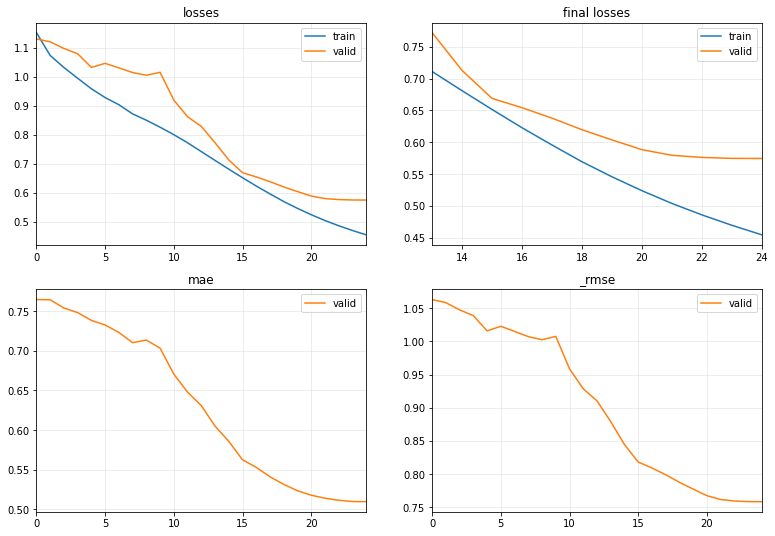

-IMF 16 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


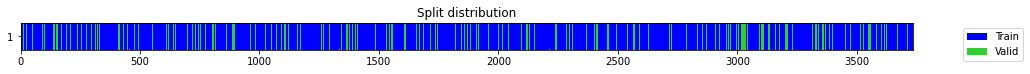

number of model outputs: 1


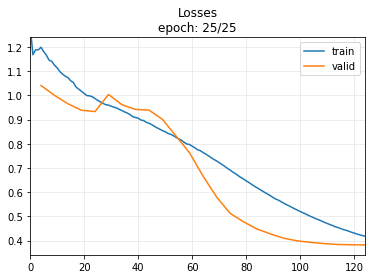

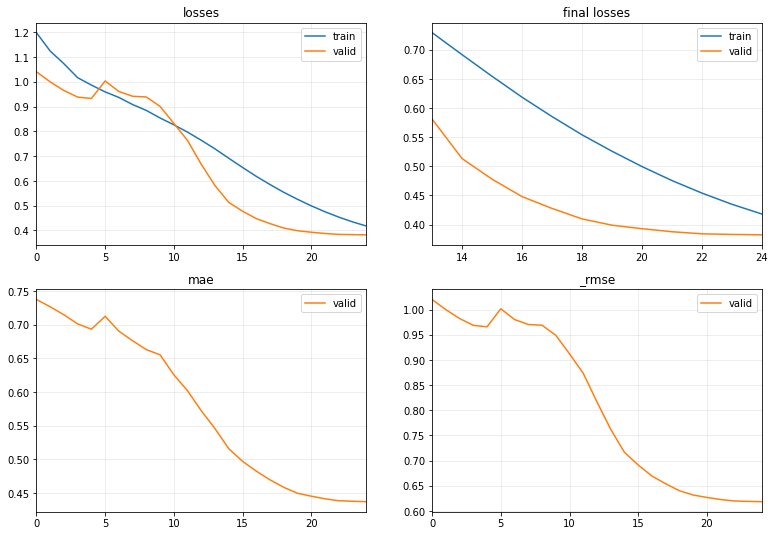

-IMF 17 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


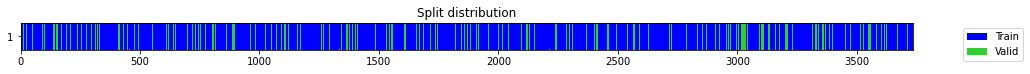

number of model outputs: 1


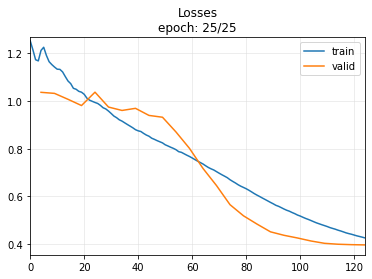

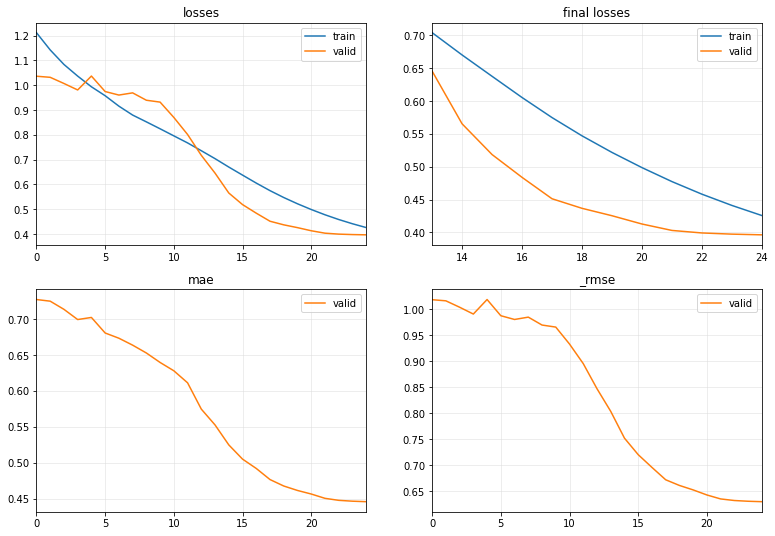

-IMF 18 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


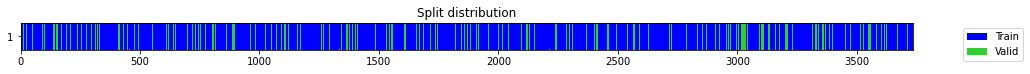

number of model outputs: 1


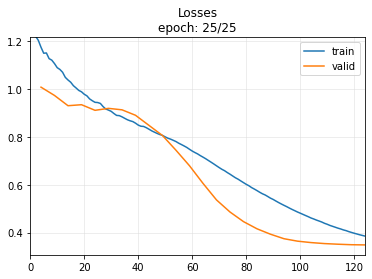

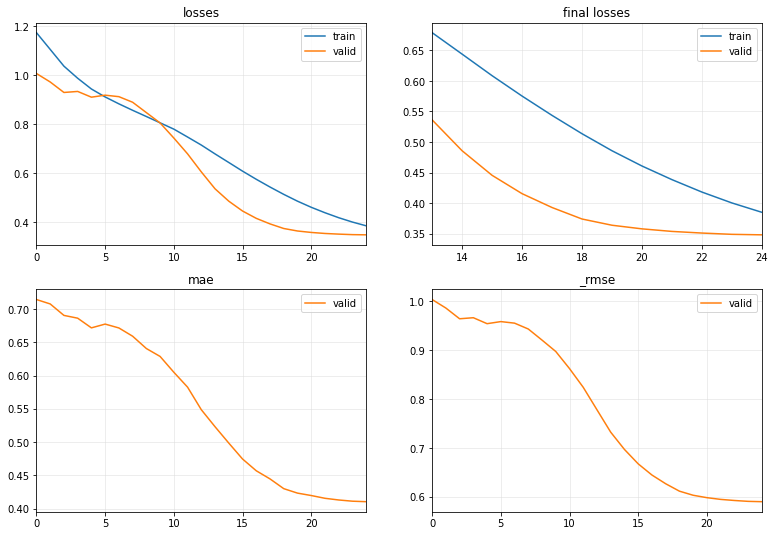

-IMF 19 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


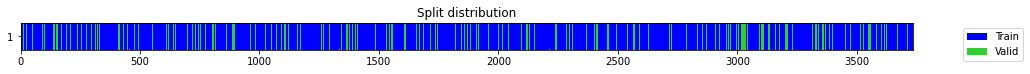

number of model outputs: 1


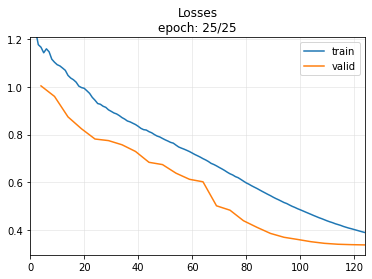

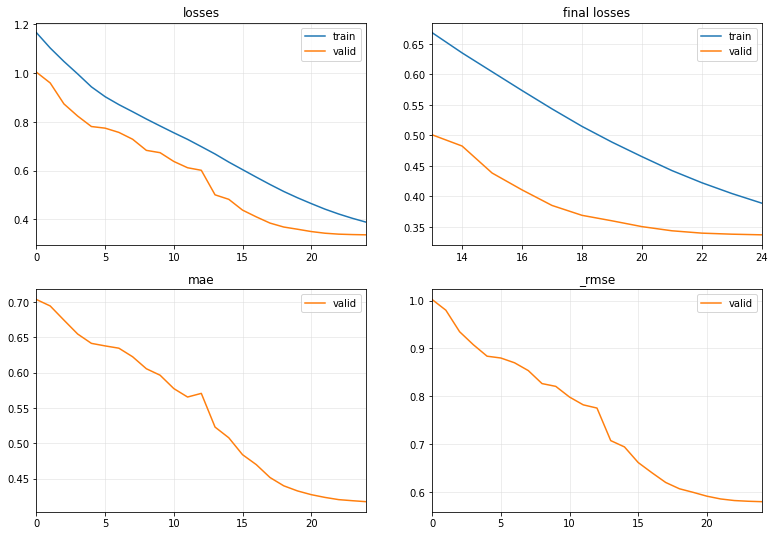

-IMF 20 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


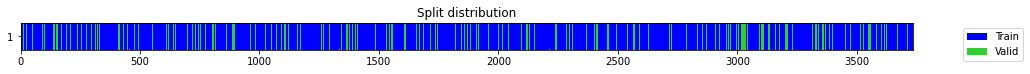

number of model outputs: 1


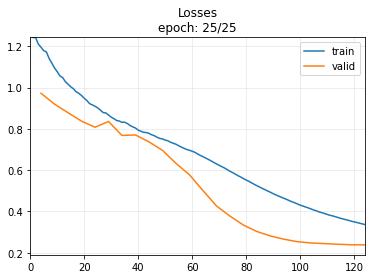

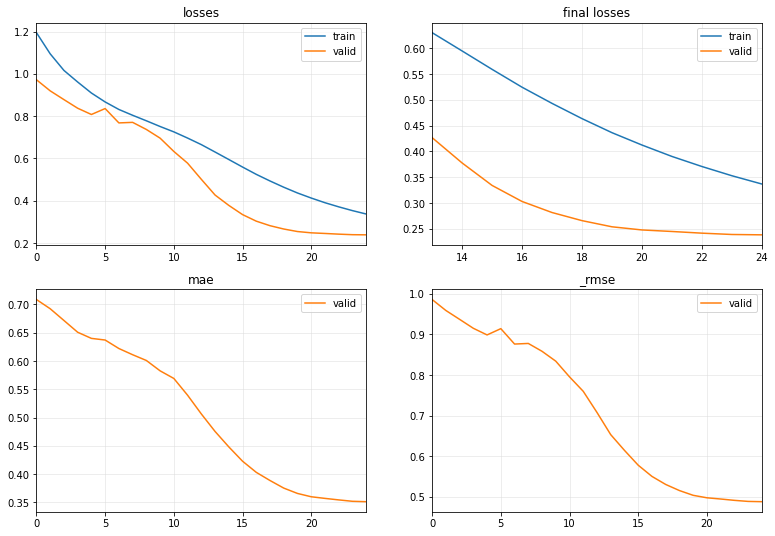

-IMF 21 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


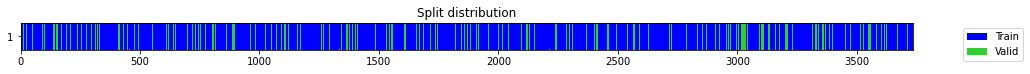

number of model outputs: 1


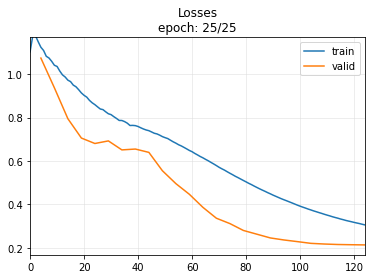

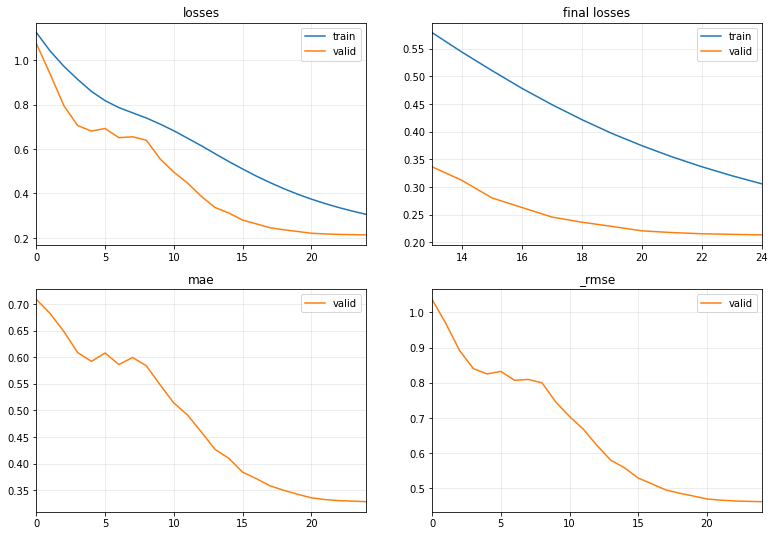

-IMF 22 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


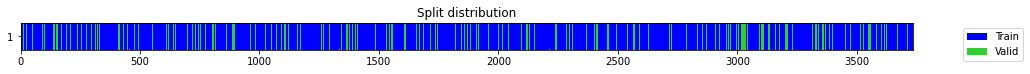

number of model outputs: 1


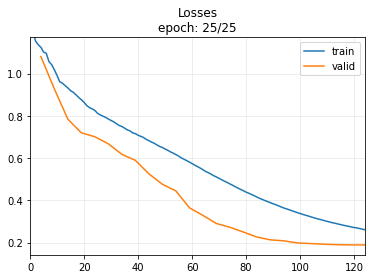

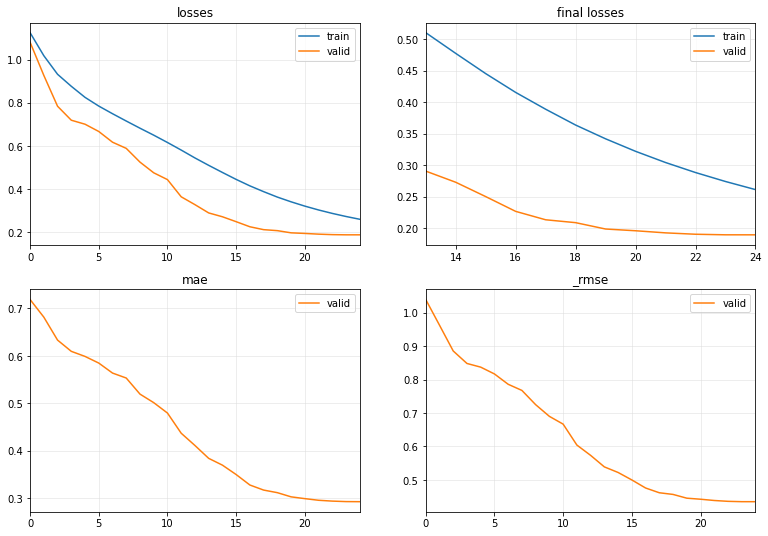

-IMF 23 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


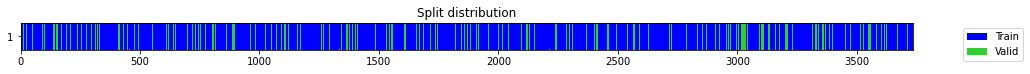

number of model outputs: 1


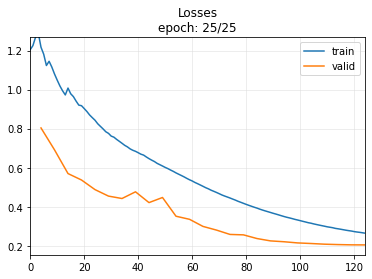

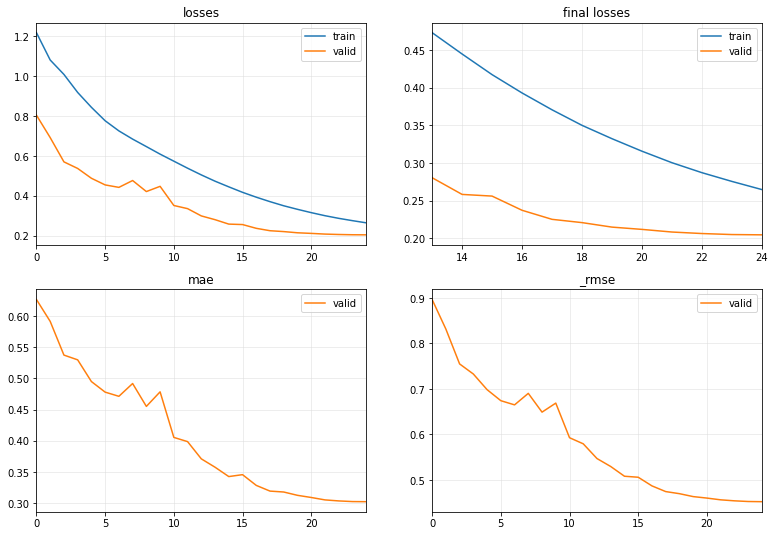

-IMF 24 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


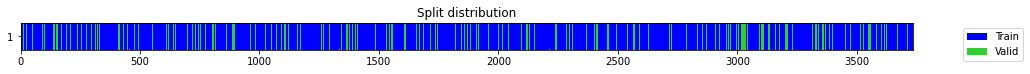

number of model outputs: 1


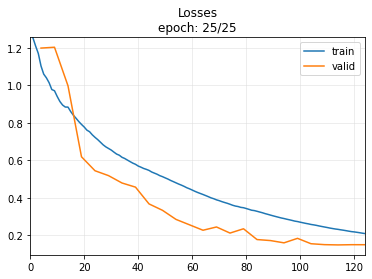

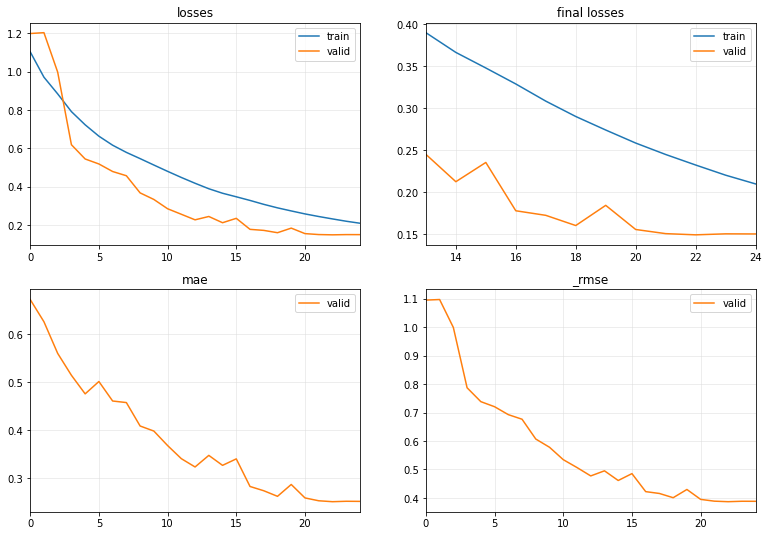

-IMF 25 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


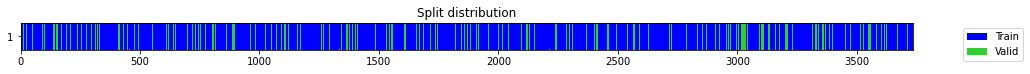

number of model outputs: 1


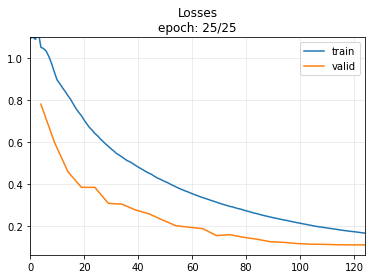

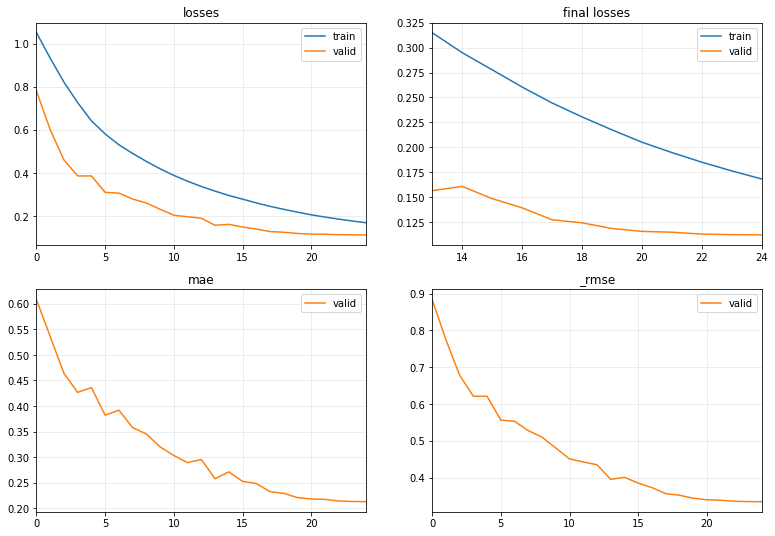

-IMF 26 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


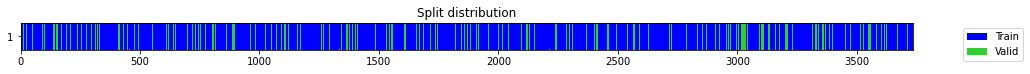

number of model outputs: 1


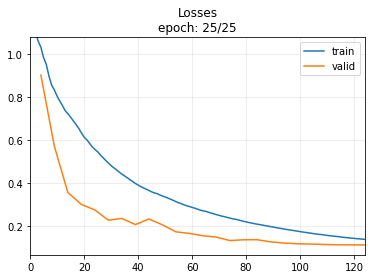

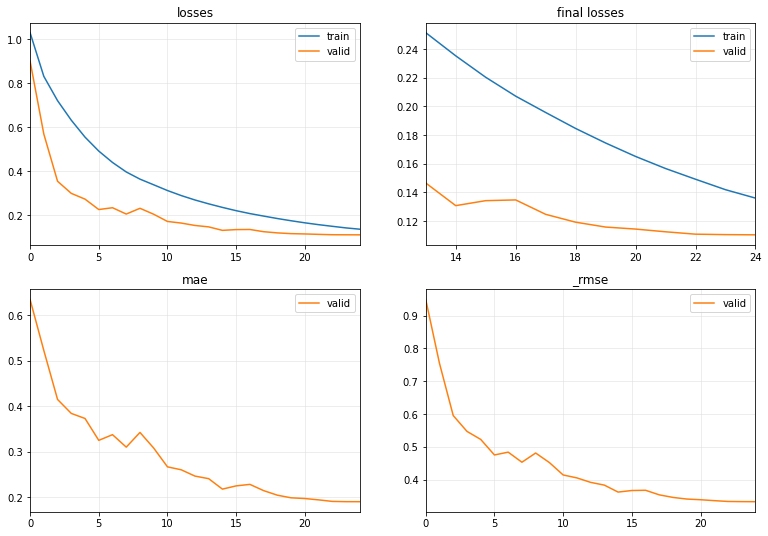

-IMF 27 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


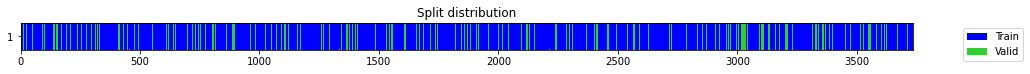

number of model outputs: 1


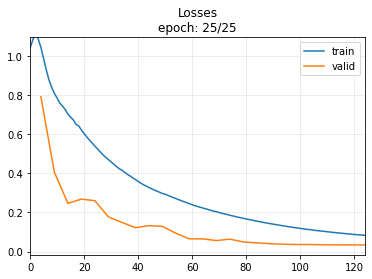

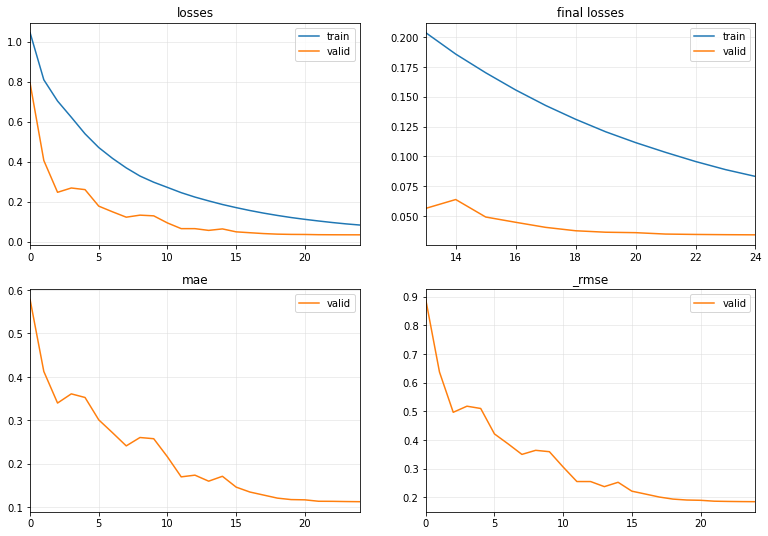

-IMF 28 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


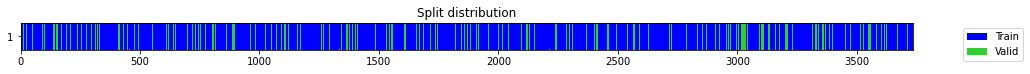

number of model outputs: 1


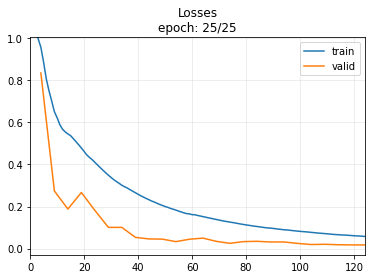

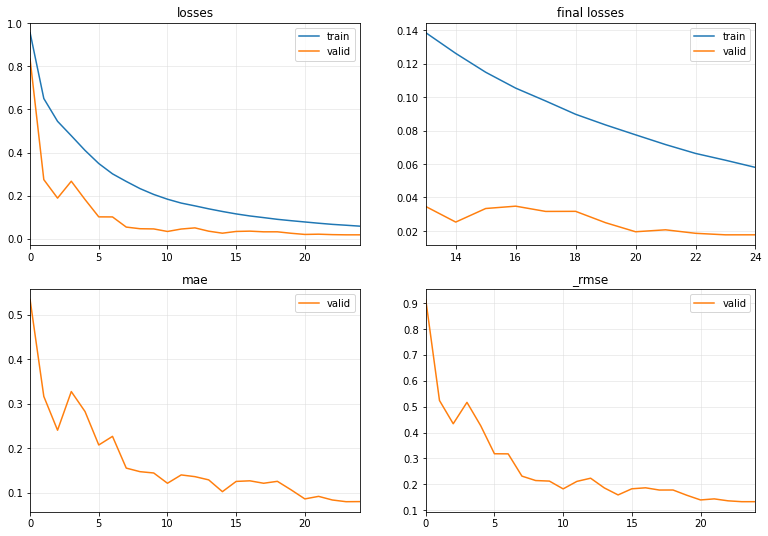

-IMF 29 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


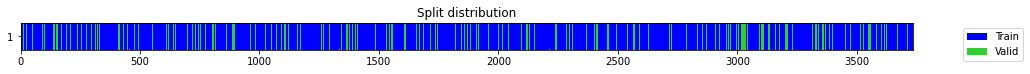

number of model outputs: 1


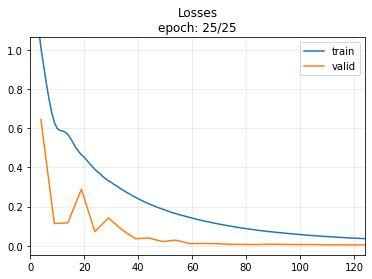

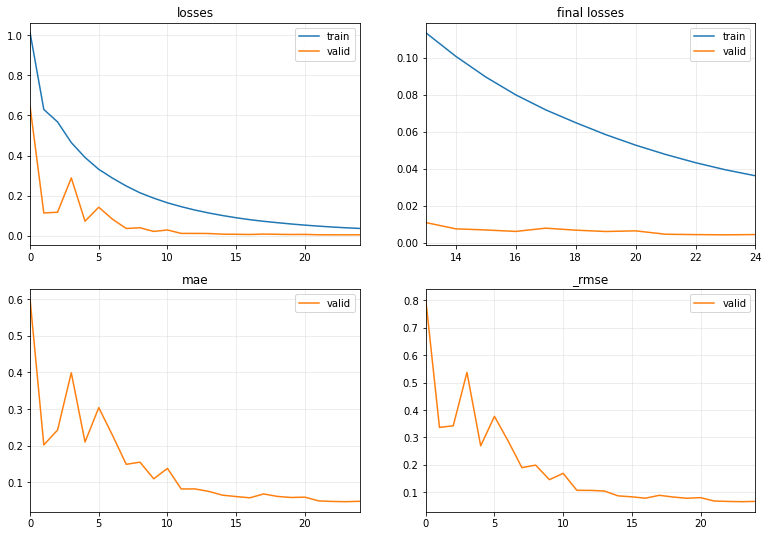

-IMF 30 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


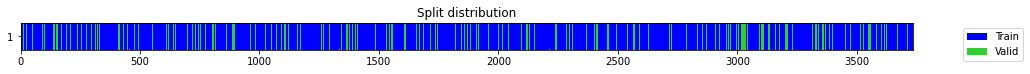

number of model outputs: 1


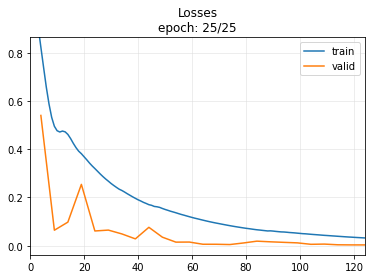

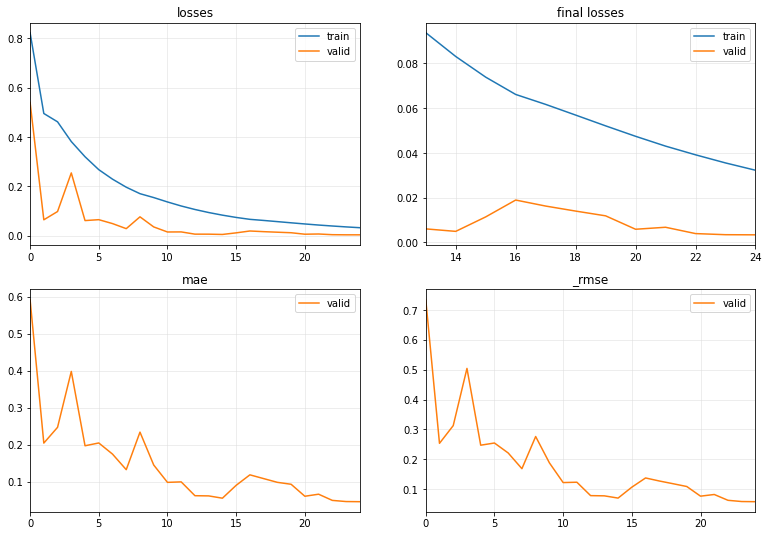

-IMF 31 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


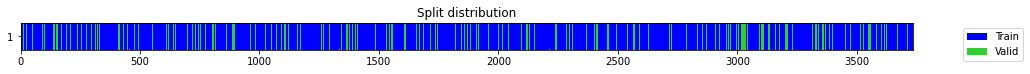

number of model outputs: 1


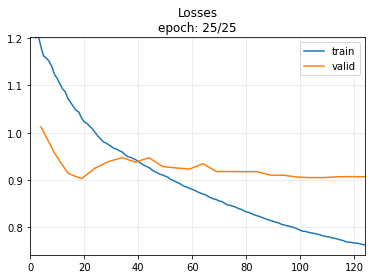

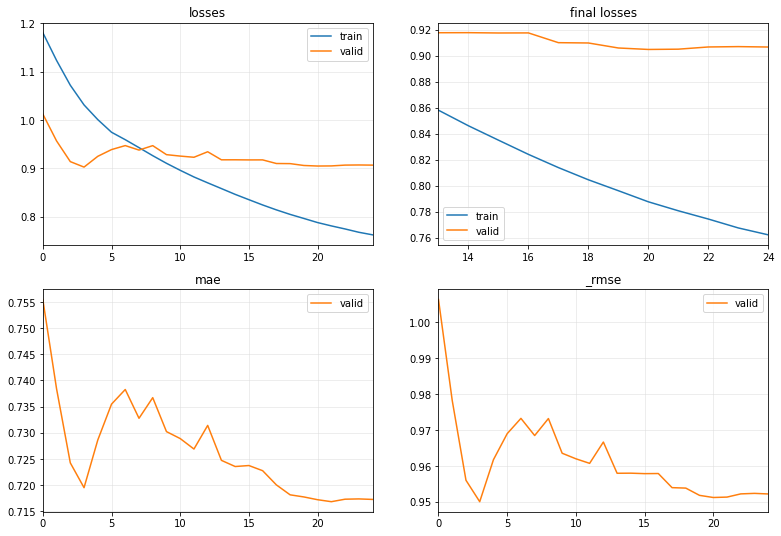

Targets and Predictions shapes (934,) (934,)
InceptionTimePlus : MAPE =  1.7390824789545056 MAE =  0.0230472466303677 RMSE =  0.028922908749321977


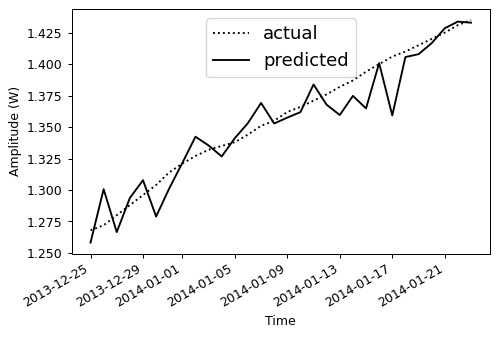

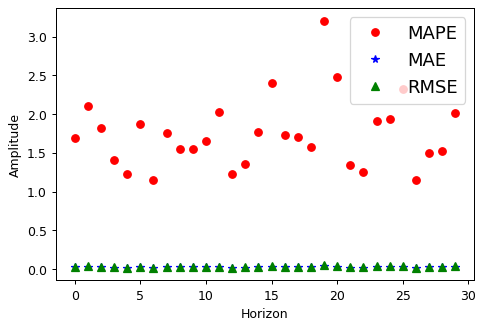

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

for x in range(0,IMFS_count+1,1):
  print('-IMF',x,', splitting data..')
  Thick_data = to3d(VMD_Thick.iloc[x::IMFS_count+1,:].values)
  data = np.concatenate([Thick_data, TS_D, TS_Y, TS_M],axis=1) 
  data_X = data[:,:,:split_indx]
  data_y = data[:,0,split_indx:]
  X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
  y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
  print('Standardizing data..')
  for i in range(X_train.shape[1]): #normalize IN data
    scalersIN["IMF{}".format(x)]["feature{}".format(i)] = StandardScaler()
    X_train[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].fit_transform(X_train[:, i, :])    
  scalersOUT["IMF{}".format(x)] = StandardScaler() #normalize OUT data
  y_train = scalersOUT["IMF{}".format(x)][0].fit_transform(y_train)  
  print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

  splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
  tfms  = [None, [ToFloat(), ToNumpyTensor()]]
  dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
  # dsets[0]
  print('number of model outputs:', get_c(dls))
  # dls.show_batch(max_n=1)
  # model = create_model(model_name, dls=dls, **par)
  # learn = Learner(dls, model, metrics=[mae, rmse],cbs=[ShowGraph(),SaveModel()])
  learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
  # learn.model
  # learn.lr_find()
  learn.fit_one_cycle(freeze_epoch, learning_rate)
  #save trained model
  # learn.save_all(path='/content/gdrive/MyDrive/PowerForcasting/VeryShortTerm_LoadForecasting/export/', dls_fname='dls', model_fname='VMD_TIME_multistep'+ "IMF{}".format(x) + '_' + learn.model.__class__.__name__ + HOUSE, learner_fname='learner')
  valid_dl = dls.valid

  # Labeled test data
  for i in range(X_test.shape[1]): #normalize IN data
    X_test[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].transform(X_test[:, i, :])    
  y_test = scalersOUT["IMF{}".format(x)][0].transform(y_test)  
  test_ds = valid_dl.dataset.add_test(X_test, y_test)
  test_dl = valid_dl.new(test_ds)
  _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
  #denormalize data
  test_predsdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_preds)  
  test_targetdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_targets)      
d = pd.DataFrame([])
d = pd.DataFrame({k:list(v) for k,v in test_targetdata.items()})
d.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')
dp = pd.DataFrame([])
dp = pd.DataFrame({k:list(v) for k,v in test_predsdata.items()})
dp.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')

#TEST
dsum = d.sum(axis=1)
dpsum = dp.sum(axis=1)
print('Targets and Predictions shapes', dsum.shape, dpsum.shape)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mae_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))     
def rmse_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))
MAPE = mean_absolute_percentage_error(dsum, dpsum)    
MAE = mae_metric(dsum, dpsum)
RMSE = rmse_metric(dsum, dpsum)
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dsum[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dpsum[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude (W)')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### with EMD - Thickness + time info.

In [ ]:
exec('d_model = 1024')
exec('n_heads = 16')
exec("{} = 'gelu'".format('act'))
exec('d_ff = 256')
exec('n_layers = 3')
exec('fc_dropout = 0.133708061097594')
exec('learning_rate = 0.00134544344998544')

par = {'d_model':d_model,'n_heads':n_heads,'act':act,'d_ff':d_ff,'n_layers':n_layers,'fc_dropout':fc_dropout}

In [ ]:
ind = 'EMD4IMFs';
mode = 'ThickTime_'
Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + season + '.csv',header=None)
VMD_Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + ind + '_' + season + '.csv')
VMD_Thick = VMD_Thick.drop(columns='Element0')
Thick

0      1      2      3      4      5      6      7      8      9   \
0     1.951  1.955  1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974   
1     1.955  1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974   
2     1.962  1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977   
3     1.965  1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977  1.984   
4     1.973  1.981  1.986  1.984  1.977  1.974  1.974  1.977  1.984  1.987   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4666  1.381  1.381  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424   
4667  1.381  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428   
4668  1.385  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436   
4669  1.390  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436  1.441   
4670  1.393  1.399  1.407  1.414  1.417  1.424  1.428  1.436  1.441  1.446   

      ...     50     51     52     53     54     55     56     57     58  \
0     ...  2.141  2.144  2.144  2.144  2.141  2.137  2.136  2.135  2.139   
1     ...  2.144  2.144  2.144  2.141  2.137  2.136  2.135  2.139  2.147   
2     ...  2.144  2.144  2.141  2.137  2.136  2.135  2.139  2.147  2.151   
3     ...  2.144  2.141  2.137  2.136  2.135  2.139  2.147  2.151  2.153   
4     ...  2.141  2.137  2.136  2.135  2.139  2.147  2.151  2.153  2.152   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
4666  ...  1.646  1.648  1.647  1.653  1.653  1.656  1.660  1.665  1.666   
4667  ...  1.648  1.647  1.653  1.653  1.656  1.660  1.665  1.666  1.672   
4668  ...  1.647  1.653  1.653  1.656  1.660  1.665  1.666  1.672  1.676   
4669  ...  1.653  1.653  1.656  1.660  1.665  1.666  1.672  1.676  1.681   
4670  ...  1.653  1.656  1.660  1.665  1.666  1.672  1.676  1.681  1.687   

         59  
0     2.147  
1     2.151  
2     2.153  
3     2.152  
4     2.150  
...     ...  
4666  1.672  
4667  1.676  
4668  1.681  
4669  1.687  
4670  1.692  

[4671 rows x 60 columns]

In [ ]:
split_indx = 30

print('Processing Thick and time data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ["IMF{}".format(x) for x in range (0,IMFS_count+1,1)]
row = ["feature{}".format(x) for x in np.array(range(5))]
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

temp_targets = {}
temp_preds = {}
test_targetdata={}
test_predsdata={}


Processing Thick and time data..


##### Model learning

-IMF 0 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


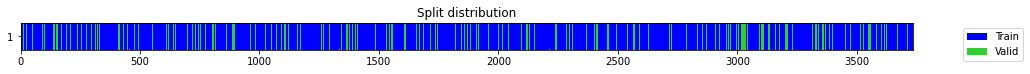

number of model outputs: 1


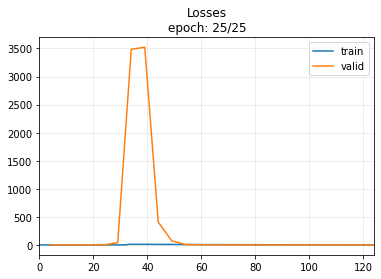

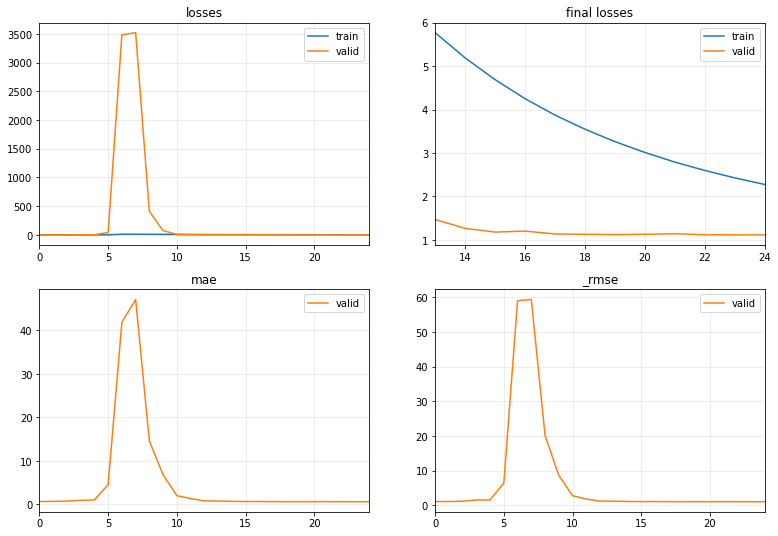

-IMF 1 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


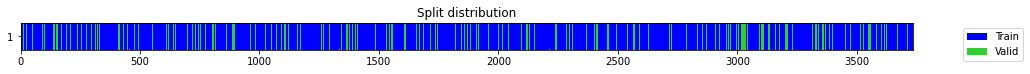

number of model outputs: 1


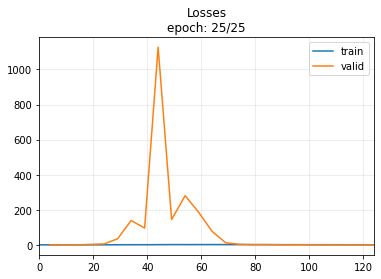

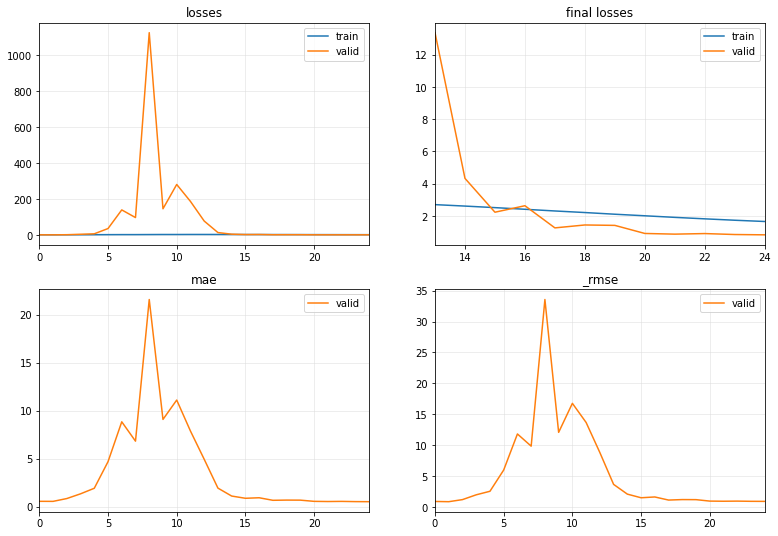

-IMF 2 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


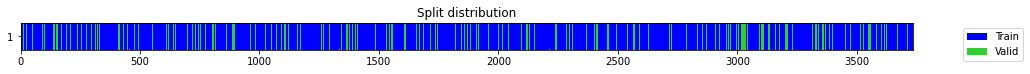

number of model outputs: 1


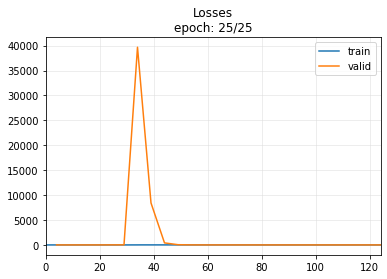

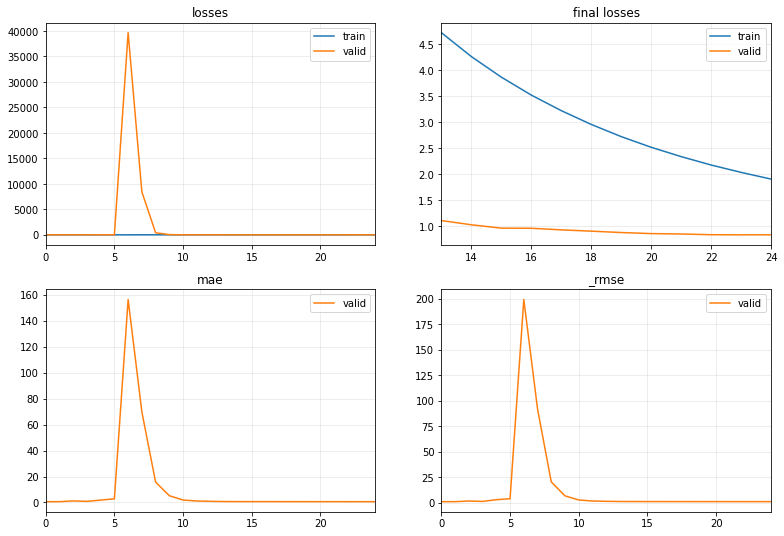

-IMF 3 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


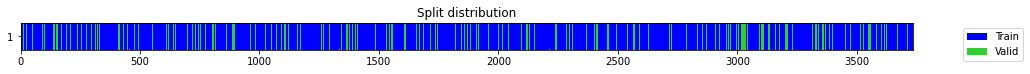

number of model outputs: 1


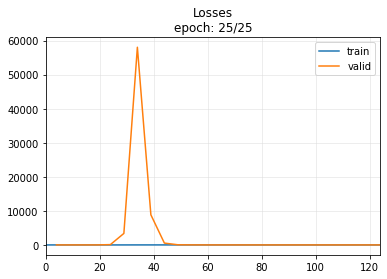

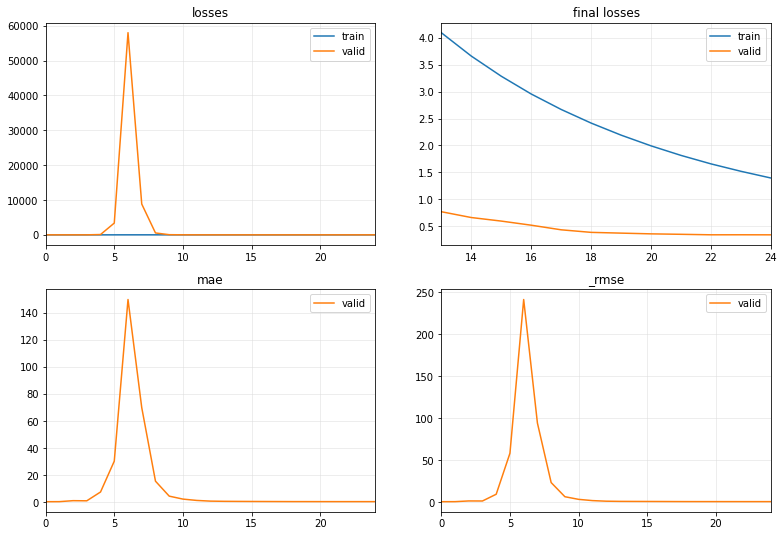

-IMF 4 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


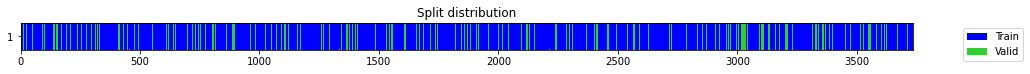

number of model outputs: 1


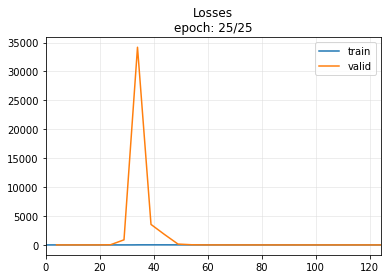

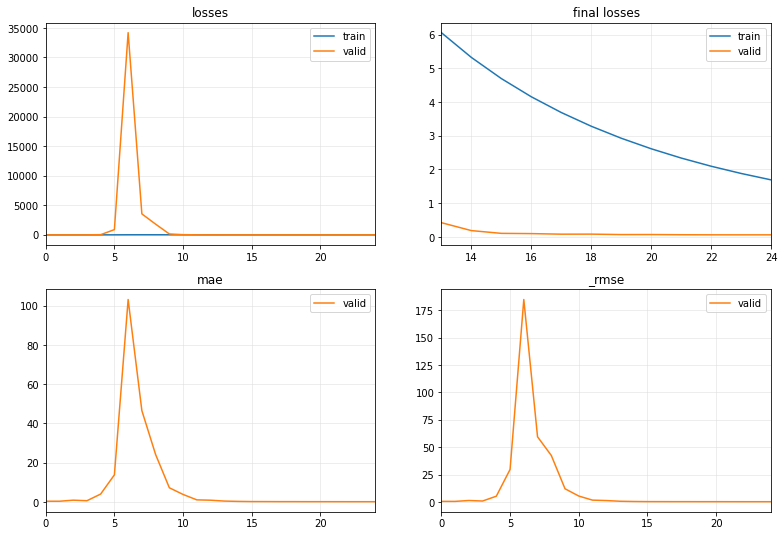

Targets and Predictions shapes (934,) (934,)
TSTPlus : MAPE =  4.207324656813168 MAE =  0.05570664971592763 RMSE =  0.06889535370793728


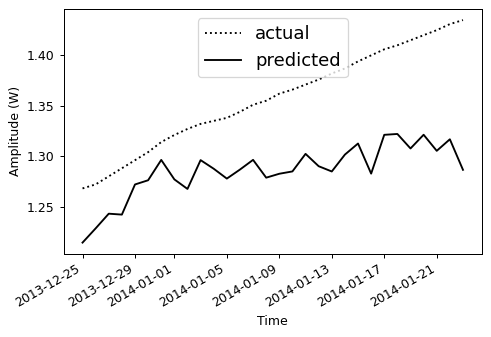

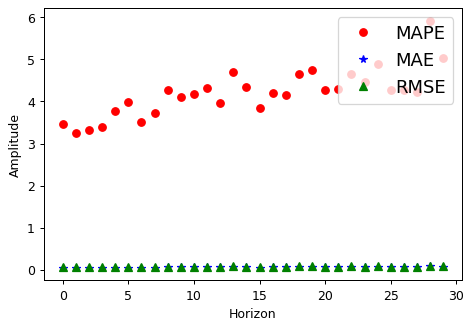

In [ ]:
for x in range(0,IMFS_count+1,1):
  print('-IMF',x,', splitting data..')
  Thick_data = to3d(VMD_Thick.iloc[x::IMFS_count+1,:].values)
  data = np.concatenate([Thick_data, TS_D, TS_Y, TS_M],axis=1) 
  data_X = data[:,:,:split_indx]
  data_y = data[:,0,split_indx:]
  X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
  y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
  print('Standardizing data..')
  for i in range(X_train.shape[1]): #normalize IN data
    scalersIN["IMF{}".format(x)]["feature{}".format(i)] = StandardScaler()
    X_train[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].fit_transform(X_train[:, i, :])    
  scalersOUT["IMF{}".format(x)] = StandardScaler() #normalize OUT data
  y_train = scalersOUT["IMF{}".format(x)][0].fit_transform(y_train)  
  print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

  splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
  tfms  = [None, [ToFloat(), ToNumpyTensor()]]
  dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
  # dsets[0]
  print('number of model outputs:', get_c(dls))
  # dls.show_batch(max_n=1)
  # model = create_model(model_name, dls=dls, **par)
  # learn = Learner(dls, model, metrics=[mae, rmse],cbs=[ShowGraph(),SaveModel()])
  learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
  # learn.model
  # learn.lr_find()
  learn.fit_one_cycle(freeze_epoch, learning_rate)
  #save trained model
  # learn.save_all(path='/content/gdrive/MyDrive/PowerForcasting/VeryShortTerm_LoadForecasting/export/', dls_fname='dls', model_fname='VMD_TIME_multistep'+ "IMF{}".format(x) + '_' + learn.model.__class__.__name__ + HOUSE, learner_fname='learner')
  valid_dl = dls.valid

  # Labeled test data
  for i in range(X_test.shape[1]): #normalize IN data
    X_test[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].transform(X_test[:, i, :])    
  y_test = scalersOUT["IMF{}".format(x)][0].transform(y_test)  
  test_ds = valid_dl.dataset.add_test(X_test, y_test)
  test_dl = valid_dl.new(test_ds)
  _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
  #denormalize data
  test_predsdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_preds)  
  test_targetdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_targets)      
d = pd.DataFrame([])
d = pd.DataFrame({k:list(v) for k,v in test_targetdata.items()})
d.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')
dp = pd.DataFrame([])
dp = pd.DataFrame({k:list(v) for k,v in test_predsdata.items()})
dp.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')

#TEST
dsum = d.sum(axis=1)
dpsum = dp.sum(axis=1)
print('Targets and Predictions shapes', dsum.shape, dpsum.shape)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mae_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))     
def rmse_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))
MAPE = mean_absolute_percentage_error(dsum, dpsum)    
MAE = mae_metric(dsum, dpsum)
RMSE = rmse_metric(dsum, dpsum)
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dsum[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dpsum[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude (W)')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


## season2

In [ ]:
season = season2

### no VMD - Thickness + time info.

In [ ]:
ind = ''
mode = 'ThickTime_'
Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + season + '.csv',header=None)
Thick

0      1      2      3      4      5      6      7      8      9   \
0     2.223  2.234  2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291   
1     2.234  2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295   
2     2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302   
3     2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302  2.305   
4     2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302  2.305  2.308   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5799  1.844  1.847  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842   
5800  1.847  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839   
5801  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837   
5802  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837  1.827   
5803  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837  1.827  1.821   

      ...     50     51     52     53     54     55     56     57     58  \
0     ...  2.536  2.541  2.546  2.545  2.551  2.557  2.556  2.556  2.567   
1     ...  2.541  2.546  2.545  2.551  2.557  2.556  2.556  2.567  2.575   
2     ...  2.546  2.545  2.551  2.557  2.556  2.556  2.567  2.575  2.583   
3     ...  2.545  2.551  2.557  2.556  2.556  2.567  2.575  2.583  2.589   
4     ...  2.551  2.557  2.556  2.556  2.567  2.575  2.583  2.589  2.592   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5799  ...  1.635  1.633  1.622  1.612  1.605  1.601  1.593  1.582  1.568   
5800  ...  1.633  1.622  1.612  1.605  1.601  1.593  1.582  1.568  1.553   
5801  ...  1.622  1.612  1.605  1.601  1.593  1.582  1.568  1.553  1.536   
5802  ...  1.612  1.605  1.601  1.593  1.582  1.568  1.553  1.536  1.513   
5803  ...  1.605  1.601  1.593  1.582  1.568  1.553  1.536  1.513  1.501   

         59  
0     2.575  
1     2.583  
2     2.589  
3     2.592  
4     2.595  
...     ...  
5799  1.553  
5800  1.536  
5801  1.513  
5802  1.501  
5803  1.488  

[5804 rows x 60 columns]

#### Hyperparameter tuning

Processing Thickness data..
splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


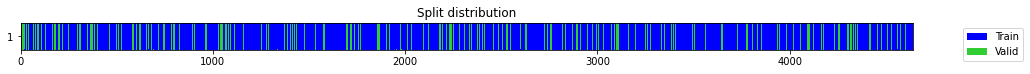

In [ ]:
split_indx = 30

print('Processing Thickness data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ['Signal']
row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

test_targetdata={}
test_predsdata={}

test_targetdata={}
test_predsdata={}

print('splitting data..')
Thick_data = to3d(Thick.iloc[:,:].values)
# Temp_data = to3d(Temp.iloc[:,:].values)
data = np.concatenate([Thick_data, TS_D, TS_Y, TS_M],axis=1)  #, TS_Mend, TS_Mstart
data_X = data[:,:,:split_indx]
data_y = data[:,0,split_indx:]
X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
print('Standardizing data..')
for i in range(X_train.shape[1]): #normalize IN data
  scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
  X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
scalersOUT['Signal'] = StandardScaler() #normalize OUT data
y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
tfms  = [None, [ToFloat(), ToNumpyTensor()]]
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
#**************#**************#**************#**************#**************#**************#**************#**************

In [ ]:
study = optuna.create_study(direction='minimize')
print(f"Sampler is {study.sampler.__class__.__name__}")

tuning(model_name)

print("**Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("{}".format(value))

[I 2022-07-24 23:02:36,341] A new study created in memory with name: no-name-0ec73117-386e-4aab-b8ba-9190b77b8422


Sampler is TPESampler


[I 2022-07-24 23:02:43,151] Trial 0 finished with value: 0.10871626436710358 and parameters: {'bottleneck': False, 'coord': False, 'separable': False, 'zero_norm': True, 'nf': 48, 'ks': 20, 'conv_dropout': 0.17308001882414187, 'fc_dropout': 0.008907558613949818, 'learning_rate': 0.00014168668262185626}. Best is trial 0 with value: 0.10871626436710358.
[I 2022-07-24 23:02:49,906] Trial 1 finished with value: 0.05779974162578583 and parameters: {'bottleneck': True, 'coord': False, 'separable': True, 'zero_norm': False, 'nf': 48, 'ks': 40, 'conv_dropout': 0.4873814318887241, 'fc_dropout': 0.17414968838488937, 'learning_rate': 0.0061682510036587}. Best is trial 1 with value: 0.05779974162578583.
[I 2022-07-24 23:02:56,735] Trial 2 finished with value: 0.07267984747886658 and parameters: {'bottleneck': True, 'coord': False, 'separable': False, 'zero_norm': False, 'nf': 48, 'ks': 60, 'conv_dropout': 0.23540336262174144, 'fc_dropout': 0.146777519842065, 'learning_rate': 0.00043241195259368146

**Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.03653760626912117
  Params: 
True
True
False
True
56
60
0.49765969377479274
0.27086276043314267
0.0034310726347990613


#### Model learning

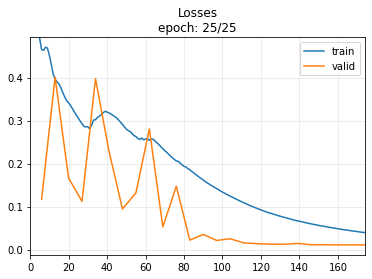

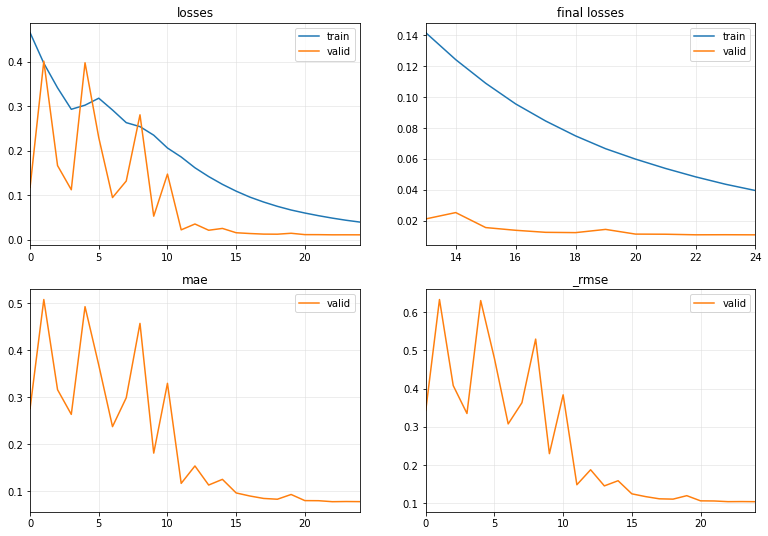

Targets and Predictions shapes (1160, 30) (1160, 30)
InceptionTimePlus : MAPE =  5.557259319117887 MAE =  0.07570937847352371 RMSE =  0.0889698001996362


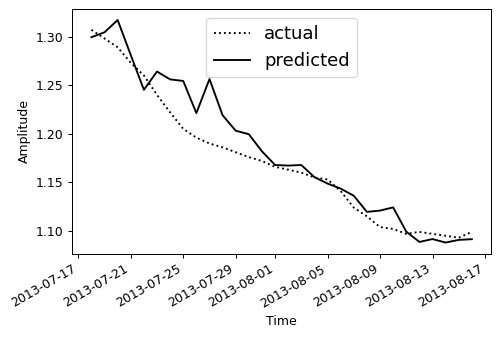

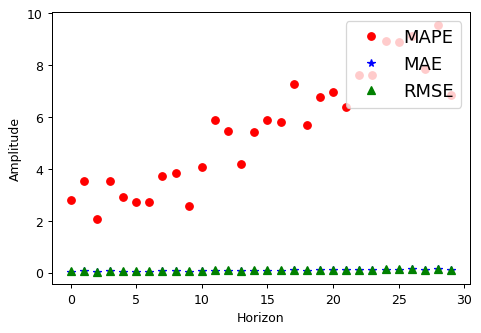

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

#Model learning
learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
learn.fit_one_cycle(freeze_epoch, learning_rate)
# #save trained model
# learn.save_all(path='/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export', dls_fname='dls', model_fname='WP_TIME_multistep_' + learn.model.__class__.__name__ + '_' + HOUSE, learner_fname='learner')
valid_dl = dls.valid

# Labeled test data
for i in range(X_test.shape[1]): #normalize IN data
  X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
y_test = scalersOUT['Signal'][0].transform(y_test)  
test_ds = valid_dl.dataset.add_test(X_test, y_test)
test_dl = valid_dl.new(test_ds)
_, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
#denormalize data
test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
del temp_targets, temp_preds
# RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
d = pd.DataFrame([])
d = test_targetdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', d, delimiter=',')
dp = pd.DataFrame([])
dp = test_predsdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', dp, delimiter=',')

#TEST MODEL
import numpy as np
import matplotlib.pyplot as plt
print('Targets and Predictions shapes', d.shape, dp.shape)

MAPE = []
MAE  = []
RMSE = []
for i in range(d.shape[1]): 
  MAPE.append(np.mean(np.abs((d[:,i] - dp[:,i]) / d[:,i]))*100)
  MAE.append(np.mean(np.abs((d[:,i] - dp[:,i]))))
  RMSE.append(np.sqrt(np.mean((d[:,i] - dp[:,i])**2)))
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], d[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dp[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### no VMD - Time info. only

In [ ]:
ind = ''
mode = 'Time_'
Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + season + '.csv',header=None)
Thick

0      1      2      3      4      5      6      7      8      9   \
0     2.223  2.234  2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291   
1     2.234  2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295   
2     2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302   
3     2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302  2.305   
4     2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302  2.305  2.308   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5799  1.844  1.847  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842   
5800  1.847  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839   
5801  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837   
5802  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837  1.827   
5803  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837  1.827  1.821   

      ...     50     51     52     53     54     55     56     57     58  \
0     ...  2.536  2.541  2.546  2.545  2.551  2.557  2.556  2.556  2.567   
1     ...  2.541  2.546  2.545  2.551  2.557  2.556  2.556  2.567  2.575   
2     ...  2.546  2.545  2.551  2.557  2.556  2.556  2.567  2.575  2.583   
3     ...  2.545  2.551  2.557  2.556  2.556  2.567  2.575  2.583  2.589   
4     ...  2.551  2.557  2.556  2.556  2.567  2.575  2.583  2.589  2.592   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5799  ...  1.635  1.633  1.622  1.612  1.605  1.601  1.593  1.582  1.568   
5800  ...  1.633  1.622  1.612  1.605  1.601  1.593  1.582  1.568  1.553   
5801  ...  1.622  1.612  1.605  1.601  1.593  1.582  1.568  1.553  1.536   
5802  ...  1.612  1.605  1.601  1.593  1.582  1.568  1.553  1.536  1.513   
5803  ...  1.605  1.601  1.593  1.582  1.568  1.553  1.536  1.513  1.501   

         59  
0     2.575  
1     2.583  
2     2.589  
3     2.592  
4     2.595  
...     ...  
5799  1.553  
5800  1.536  
5801  1.513  
5802  1.501  
5803  1.488  

[5804 rows x 60 columns]

Processing Thickness data..
splitting data..
Standardizing data..
training set:  (4644, 3, 30) (4644, 30) , testing set:  (1160, 3, 30) (1160, 30)


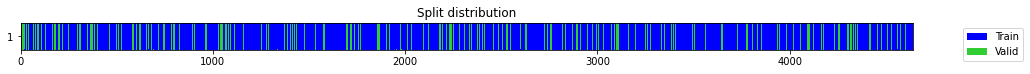

In [ ]:
split_indx = 30

print('Processing Thickness data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ['Signal']
row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

test_targetdata={}
test_predsdata={}

test_targetdata={}
test_predsdata={}

print('splitting data..')
Thick_data = to3d(Thick.iloc[:,:].values)
data = np.concatenate([TS_D, TS_Y, TS_M],axis=1) 
data_X = data[:,:,:split_indx]
data_y = Thick_data[:,0,split_indx:]
X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
print('Standardizing data..')
for i in range(X_train.shape[1]): #normalize IN data
  scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
  X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
scalersOUT['Signal'] = StandardScaler() #normalize OUT data
y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
tfms  = [None, [ToFloat(), ToNumpyTensor()]]
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
#**************#**************#**************#**************#**************#**************#**************#**************

#### Model learning

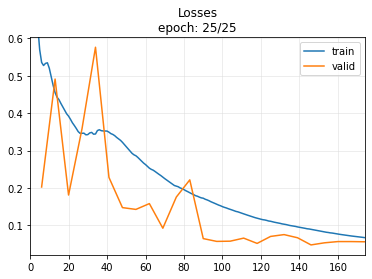

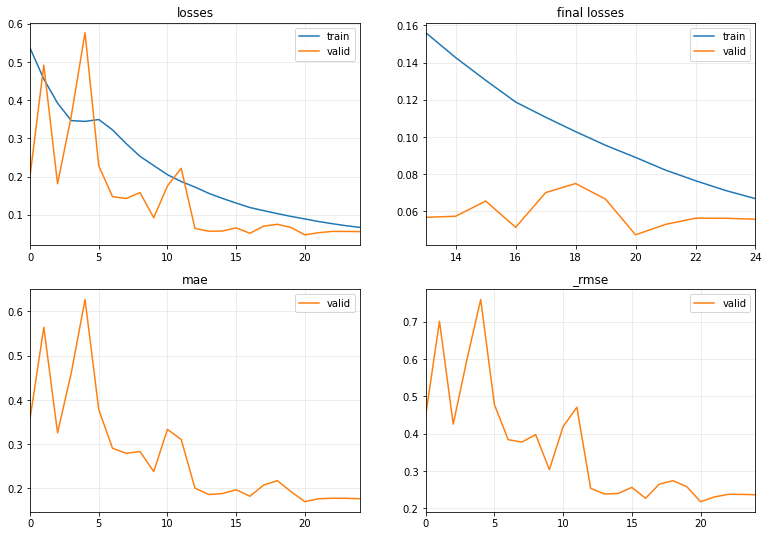

Targets and Predictions shapes (1160, 30) (1160, 30)
InceptionTimePlus : MAPE =  29.362429082323565 MAE =  0.39227051874651714 RMSE =  0.41395816082291265


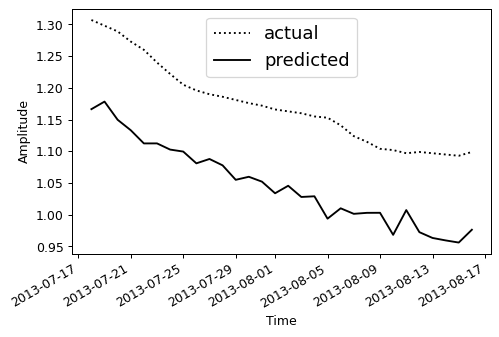

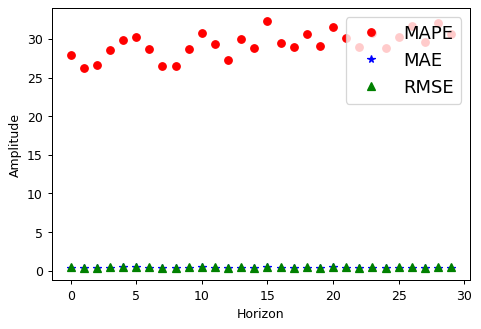

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

#Model learning
learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
learn.fit_one_cycle(freeze_epoch, learning_rate)
# #save trained model
# learn.save_all(path='/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export', dls_fname='dls', model_fname='WP_TIME_multistep_' + learn.model.__class__.__name__ + '_' + HOUSE, learner_fname='learner')
valid_dl = dls.valid

# Labeled test data
for i in range(X_test.shape[1]): #normalize IN data
  X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
y_test = scalersOUT['Signal'][0].transform(y_test)  
test_ds = valid_dl.dataset.add_test(X_test, y_test)
test_dl = valid_dl.new(test_ds)
_, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
#denormalize data
test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
del temp_targets, temp_preds
# RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
d = pd.DataFrame([])
d = test_targetdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', d, delimiter=',')
dp = pd.DataFrame([])
dp = test_predsdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', dp, delimiter=',')

#TEST MODEL
import numpy as np
import matplotlib.pyplot as plt
print('Targets and Predictions shapes', d.shape, dp.shape)

MAPE = []
MAE  = []
RMSE = []
for i in range(d.shape[1]): 
  MAPE.append(np.mean(np.abs((d[:,i] - dp[:,i]) / d[:,i]))*100)
  MAE.append(np.mean(np.abs((d[:,i] - dp[:,i]))))
  RMSE.append(np.sqrt(np.mean((d[:,i] - dp[:,i])**2)))
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], d[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dp[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### with VMD - Thickness + time info.

In [ ]:
ind = '31IMFs';
mode = 'ThickTime_'

Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + season + '.csv',header=None)
VMD_Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + ind + '_' + season + '.csv')
VMD_Thick = VMD_Thick.drop(columns='Element0')
Thick

0      1      2      3      4      5      6      7      8      9   \
0     2.223  2.234  2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291   
1     2.234  2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295   
2     2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302   
3     2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302  2.305   
4     2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302  2.305  2.308   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5799  1.844  1.847  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842   
5800  1.847  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839   
5801  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837   
5802  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837  1.827   
5803  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837  1.827  1.821   

      ...     50     51     52     53     54     55     56     57     58  \
0     ...  2.536  2.541  2.546  2.545  2.551  2.557  2.556  2.556  2.567   
1     ...  2.541  2.546  2.545  2.551  2.557  2.556  2.556  2.567  2.575   
2     ...  2.546  2.545  2.551  2.557  2.556  2.556  2.567  2.575  2.583   
3     ...  2.545  2.551  2.557  2.556  2.556  2.567  2.575  2.583  2.589   
4     ...  2.551  2.557  2.556  2.556  2.567  2.575  2.583  2.589  2.592   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5799  ...  1.635  1.633  1.622  1.612  1.605  1.601  1.593  1.582  1.568   
5800  ...  1.633  1.622  1.612  1.605  1.601  1.593  1.582  1.568  1.553   
5801  ...  1.622  1.612  1.605  1.601  1.593  1.582  1.568  1.553  1.536   
5802  ...  1.612  1.605  1.601  1.593  1.582  1.568  1.553  1.536  1.513   
5803  ...  1.605  1.601  1.593  1.582  1.568  1.553  1.536  1.513  1.501   

         59  
0     2.575  
1     2.583  
2     2.589  
3     2.592  
4     2.595  
...     ...  
5799  1.553  
5800  1.536  
5801  1.513  
5802  1.501  
5803  1.488  

[5804 rows x 60 columns]

In [ ]:
split_indx = 30

print('Processing Thick and time data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ["IMF{}".format(x) for x in range (0,IMFS_count+1,1)]
row = ["feature{}".format(x) for x in np.array(range(5))]
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = {'n_layers':n_layers, 'bias':bias, 'rnn_dropout':rnn_dropout, 'bidirectional':bidirectional,'fc_dropout':fc_dropout, 'bn':bn}

temp_targets = {}
temp_preds = {}
test_targetdata={}
test_predsdata={}

Processing Thick and time data..


##### Model learning

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

for x in range(0,IMFS_count+1,1):
  print('-IMF',x,', splitting data..')
  Thick_data = to3d(VMD_Thick.iloc[x::IMFS_count+1,:].values)
  data = np.concatenate([Thick_data, TS_D, TS_Y, TS_M],axis=1) 
  data_X = data[:,:,:split_indx]
  data_y = data[:,0,split_indx:]
  X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
  y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
  print('Standardizing data..')
  for i in range(X_train.shape[1]): #normalize IN data
    scalersIN["IMF{}".format(x)]["feature{}".format(i)] = StandardScaler()
    X_train[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].fit_transform(X_train[:, i, :])    
  scalersOUT["IMF{}".format(x)] = StandardScaler() #normalize OUT data
  y_train = scalersOUT["IMF{}".format(x)][0].fit_transform(y_train)  
  print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

  splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
  tfms  = [None, [ToFloat(), ToNumpyTensor()]]
  dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
  # dsets[0]
  print('number of model outputs:', get_c(dls))
  # dls.show_batch(max_n=1)
  # model = create_model(model_name, dls=dls, **par)
  # learn = Learner(dls, model, metrics=[mae, rmse],cbs=[ShowGraph(),SaveModel()])
  learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
  # learn.model
  # learn.lr_find()
  learn.fit_one_cycle(freeze_epoch, learning_rate)
  #save trained model
  # learn.save_all(path='/content/gdrive/MyDrive/PowerForcasting/VeryShortTerm_LoadForecasting/export/', dls_fname='dls', model_fname='VMD_TIME_multistep'+ "IMF{}".format(x) + '_' + learn.model.__class__.__name__ + HOUSE, learner_fname='learner')
  valid_dl = dls.valid

  # Labeled test data
  for i in range(X_test.shape[1]): #normalize IN data
    X_test[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].transform(X_test[:, i, :])    
  y_test = scalersOUT["IMF{}".format(x)][0].transform(y_test)  
  test_ds = valid_dl.dataset.add_test(X_test, y_test)
  test_dl = valid_dl.new(test_ds)
  _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
  #denormalize data
  test_predsdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_preds)  
  test_targetdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_targets)      
d = pd.DataFrame([])
d = pd.DataFrame({k:list(v) for k,v in test_targetdata.items()})
d.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')
dp = pd.DataFrame([])
dp = pd.DataFrame({k:list(v) for k,v in test_predsdata.items()})
dp.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')

#TEST
dsum = d.sum(axis=1)
dpsum = dp.sum(axis=1)
print('Targets and Predictions shapes', dsum.shape, dpsum.shape)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mae_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))     
def rmse_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))
MAPE = mean_absolute_percentage_error(dsum, dpsum)    
MAE = mae_metric(dsum, dpsum)
RMSE = rmse_metric(dsum, dpsum)
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dsum[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dpsum[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude (W)')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### with EMD - Thickness + time info.

In [ ]:
exec('d_model = 1024')
exec('n_heads = 16')
exec("act = {}".format({'gelu'}))
exec('d_ff = 256')
exec('n_layers = 3')
exec('fc_dropout = 0.133708061097594')
exec('learning_rate = 0.00134544344998544')

par = {'d_model':d_model,'n_heads':n_heads,'act':act,'d_ff':d_ff,'n_layers':n_layers,'fc_dropout':fc_dropout}

In [ ]:
ind = 'EMD4IMFs';
mode = 'ThickTime_'

Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + season + '.csv',header=None)
VMD_Thick = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Thicksequences_' + ind + '_' + season + '.csv')
VMD_Thick = VMD_Thick.drop(columns='Element0')
Thick

0      1      2      3      4      5      6      7      8      9   \
0     2.223  2.234  2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291   
1     2.234  2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295   
2     2.244  2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302   
3     2.256  2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302  2.305   
4     2.263  2.271  2.277  2.279  2.282  2.291  2.295  2.302  2.305  2.308   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5799  1.844  1.847  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842   
5800  1.847  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839   
5801  1.847  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837   
5802  1.844  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837  1.827   
5803  1.839  1.838  1.840  1.838  1.839  1.842  1.839  1.837  1.827  1.821   

      ...     50     51     52     53     54     55     56     57     58  \
0     ...  2.536  2.541  2.546  2.545  2.551  2.557  2.556  2.556  2.567   
1     ...  2.541  2.546  2.545  2.551  2.557  2.556  2.556  2.567  2.575   
2     ...  2.546  2.545  2.551  2.557  2.556  2.556  2.567  2.575  2.583   
3     ...  2.545  2.551  2.557  2.556  2.556  2.567  2.575  2.583  2.589   
4     ...  2.551  2.557  2.556  2.556  2.567  2.575  2.583  2.589  2.592   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
5799  ...  1.635  1.633  1.622  1.612  1.605  1.601  1.593  1.582  1.568   
5800  ...  1.633  1.622  1.612  1.605  1.601  1.593  1.582  1.568  1.553   
5801  ...  1.622  1.612  1.605  1.601  1.593  1.582  1.568  1.553  1.536   
5802  ...  1.612  1.605  1.601  1.593  1.582  1.568  1.553  1.536  1.513   
5803  ...  1.605  1.601  1.593  1.582  1.568  1.553  1.536  1.513  1.501   

         59  
0     2.575  
1     2.583  
2     2.589  
3     2.592  
4     2.595  
...     ...  
5799  1.553  
5800  1.536  
5801  1.513  
5802  1.501  
5803  1.488  

[5804 rows x 60 columns]

In [ ]:
split_indx = 30

print('Processing Thick and time data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ["IMF{}".format(x) for x in range (0,IMFS_count+1,1)]
row = ["feature{}".format(x) for x in np.array(range(5))]
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

temp_targets = {}
temp_preds = {}
test_targetdata={}
test_predsdata={}

Processing Thick and time data..


##### Model learning

-IMF 0 , splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


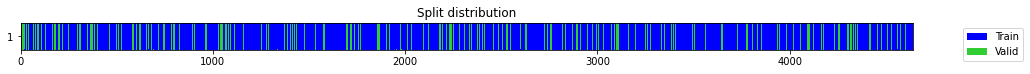

number of model outputs: 1


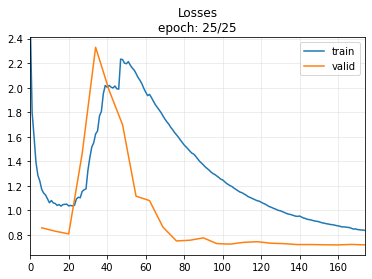

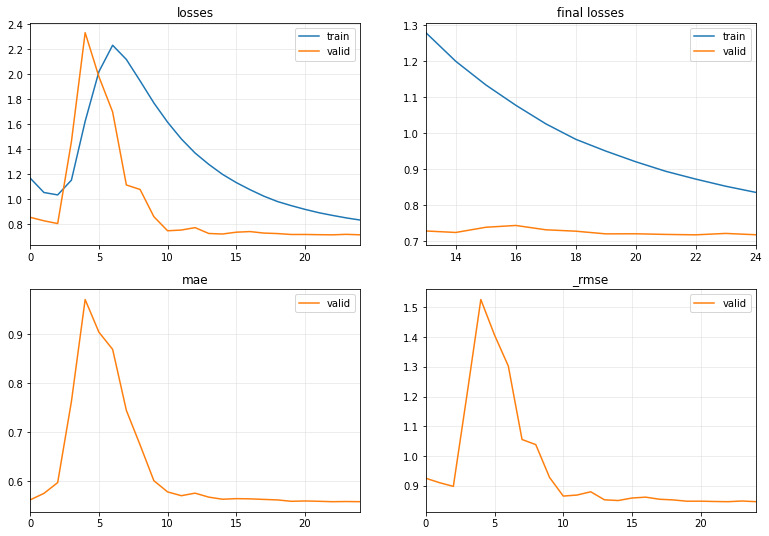

-IMF 1 , splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


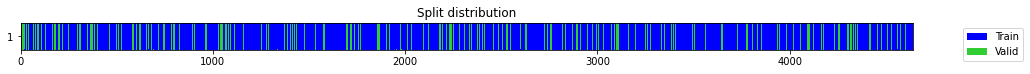

number of model outputs: 1


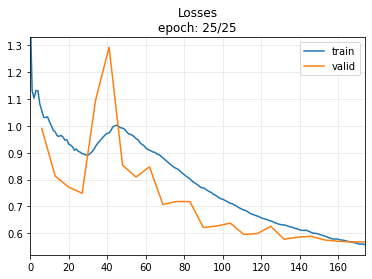

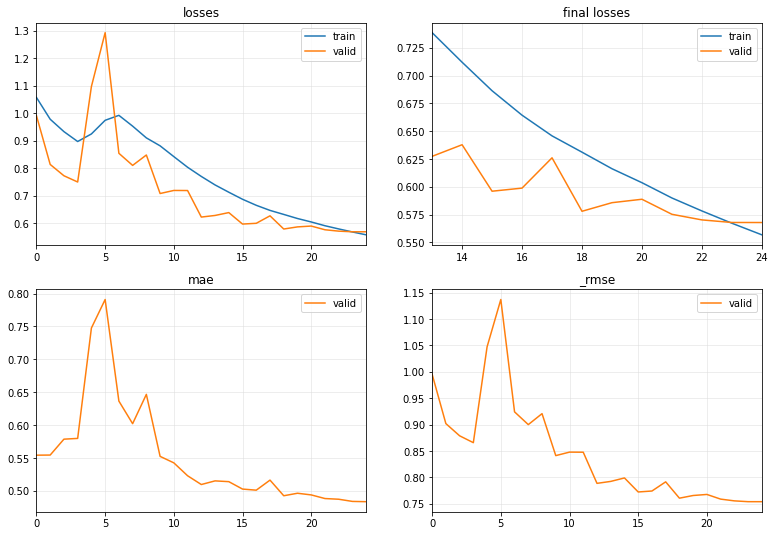

-IMF 2 , splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


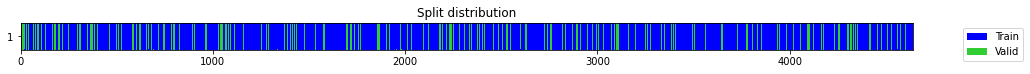

number of model outputs: 1


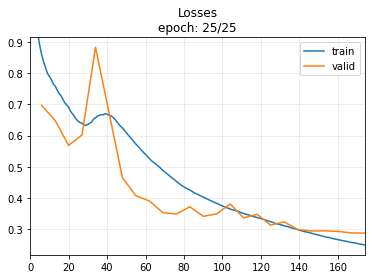

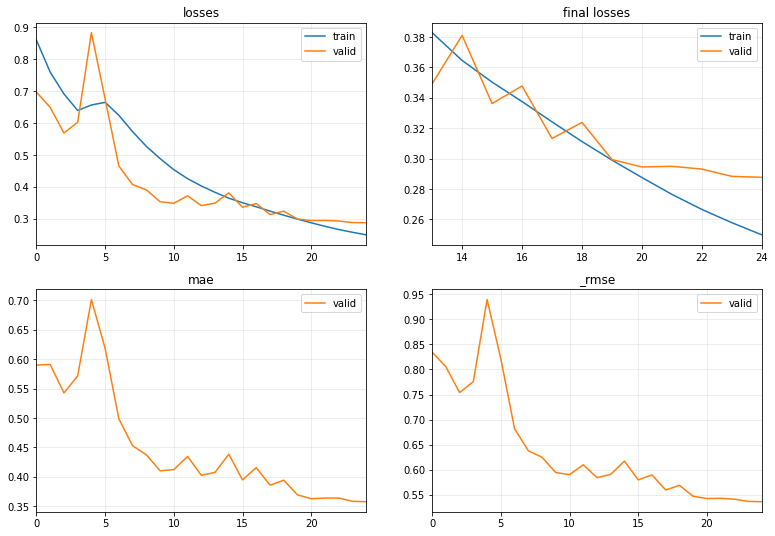

-IMF 3 , splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


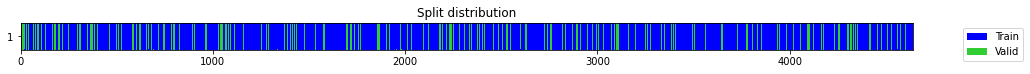

number of model outputs: 1


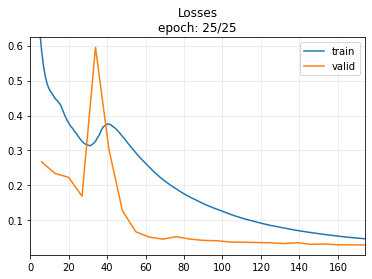

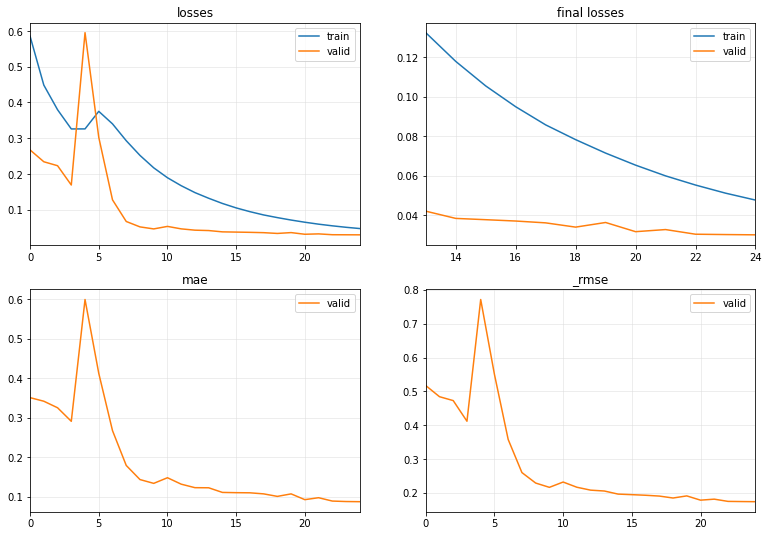

-IMF 4 , splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


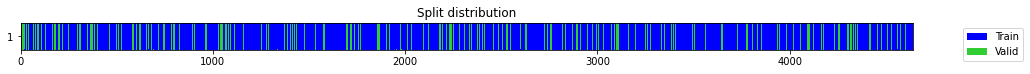

number of model outputs: 1


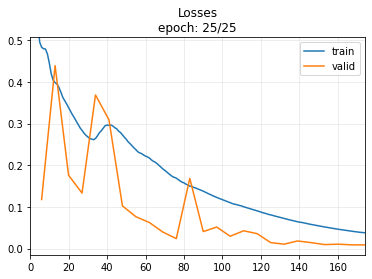

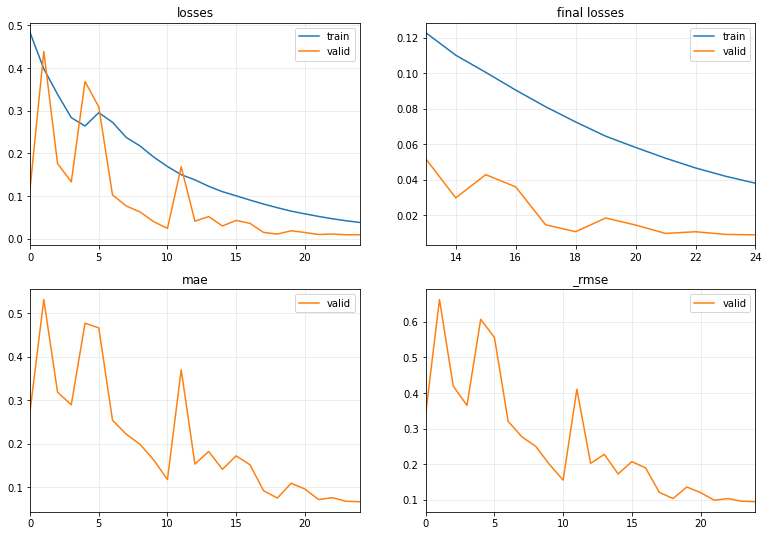

Targets and Predictions shapes (1160,) (1160,)
InceptionTimePlus : MAPE =  6.213376227375834 MAE =  0.0817033869199504 RMSE =  0.09439505064051858


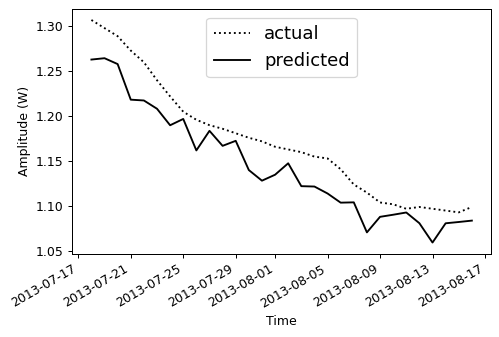

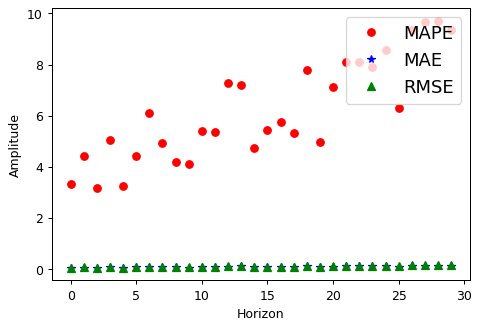

In [ ]:
for x in range(0,IMFS_count+1,1):
  print('-IMF',x,', splitting data..')
  Thick_data = to3d(VMD_Thick.iloc[x::IMFS_count+1,:].values)
  data = np.concatenate([Thick_data, TS_D, TS_Y, TS_M],axis=1) 
  data_X = data[:,:,:split_indx]
  data_y = data[:,0,split_indx:]
  X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
  y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
  print('Standardizing data..')
  for i in range(X_train.shape[1]): #normalize IN data
    scalersIN["IMF{}".format(x)]["feature{}".format(i)] = StandardScaler()
    X_train[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].fit_transform(X_train[:, i, :])    
  scalersOUT["IMF{}".format(x)] = StandardScaler() #normalize OUT data
  y_train = scalersOUT["IMF{}".format(x)][0].fit_transform(y_train)  
  print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

  splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
  tfms  = [None, [ToFloat(), ToNumpyTensor()]]
  dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
  # dsets[0]
  print('number of model outputs:', get_c(dls))
  # dls.show_batch(max_n=1)
  # model = create_model(model_name, dls=dls, **par)
  # learn = Learner(dls, model, metrics=[mae, rmse],cbs=[ShowGraph(),SaveModel()])
  learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
  # learn.model
  # learn.lr_find()
  learn.fit_one_cycle(freeze_epoch, learning_rate)
  #save trained model
  # learn.save_all(path='/content/gdrive/MyDrive/PowerForcasting/VeryShortTerm_LoadForecasting/export/', dls_fname='dls', model_fname='VMD_TIME_multistep'+ "IMF{}".format(x) + '_' + learn.model.__class__.__name__ + HOUSE, learner_fname='learner')
  valid_dl = dls.valid

  # Labeled test data
  for i in range(X_test.shape[1]): #normalize IN data
    X_test[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].transform(X_test[:, i, :])    
  y_test = scalersOUT["IMF{}".format(x)][0].transform(y_test)  
  test_ds = valid_dl.dataset.add_test(X_test, y_test)
  test_dl = valid_dl.new(test_ds)
  _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
  #denormalize data
  test_predsdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_preds)  
  test_targetdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_targets)      
d = pd.DataFrame([])
d = pd.DataFrame({k:list(v) for k,v in test_targetdata.items()})
d.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')
dp = pd.DataFrame([])
dp = pd.DataFrame({k:list(v) for k,v in test_predsdata.items()})
dp.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_THICKF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')

#TEST
dsum = d.sum(axis=1)
dpsum = dp.sum(axis=1)
print('Targets and Predictions shapes', dsum.shape, dpsum.shape)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mae_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))     
def rmse_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))
MAPE = mean_absolute_percentage_error(dsum, dpsum)    
MAE = mae_metric(dsum, dpsum)
RMSE = rmse_metric(dsum, dpsum)
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dsum[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dpsum[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude (W)')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


# Volume forecasting next month

## season1

In [ ]:
season = season1

### no VMD - Volume + time info.

In [ ]:
ind = ''
mode = 'VolTime_'
Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + season + '.csv',header=None)
Vol

0       1       2       3       4       5       6       7       8   \
0     26.405  26.496  26.582  26.672  26.770  26.867  26.940  27.013  27.095   
1     26.496  26.582  26.672  26.770  26.867  26.940  27.013  27.095  27.185   
2     26.582  26.672  26.770  26.867  26.940  27.013  27.095  27.185  27.286   
3     26.672  26.770  26.867  26.940  27.013  27.095  27.185  27.286  27.381   
4     26.770  26.867  26.940  27.013  27.095  27.185  27.286  27.381  27.463   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
4666  18.031  18.117  18.237  18.372  18.497  18.609  18.694  18.787  18.894   
4667  18.117  18.237  18.372  18.497  18.609  18.694  18.787  18.894  18.997   
4668  18.237  18.372  18.497  18.609  18.694  18.787  18.894  18.997  19.085   
4669  18.372  18.497  18.609  18.694  18.787  18.894  18.997  19.085  19.162   
4670  18.497  18.609  18.694  18.787  18.894  18.997  19.085  19.162  19.222   

          9   ...      50      51      52      53      54      55      56  \
0     27.185  ...  30.576  30.642  30.718  30.794  30.875  30.950  31.023   
1     27.286  ...  30.642  30.718  30.794  30.875  30.950  31.023  31.103   
2     27.381  ...  30.718  30.794  30.875  30.950  31.023  31.103  31.177   
3     27.463  ...  30.794  30.875  30.950  31.023  31.103  31.177  31.249   
4     27.552  ...  30.875  30.950  31.023  31.103  31.177  31.249  31.329   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
4666  18.997  ...  21.798  21.866  21.914  21.981  22.045  22.097  22.152   
4667  19.085  ...  21.866  21.914  21.981  22.045  22.097  22.152  22.235   
4668  19.162  ...  21.914  21.981  22.045  22.097  22.152  22.235  22.312   
4669  19.222  ...  21.981  22.045  22.097  22.152  22.235  22.312  22.348   
4670  19.294  ...  22.045  22.097  22.152  22.235  22.312  22.348  22.398   

          57      58      59  
0     31.103  31.177  31.249  
1     31.177  31.249  31.329  
2     31.249  31.329  31.391  
3     31.329  31.391  31.437  
4     31.391  31.437  31.491  
...      ...     ...     ...  
4666  22.235  22.312  22.348  
4667  22.312  22.348  22.398  
4668  22.348  22.398  22.441  
4669  22.398  22.441  22.489  
4670  22.441  22.489  22.544  

[4671 rows x 60 columns]

#### Hyperparameter tuning

Processing Volume data..
splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


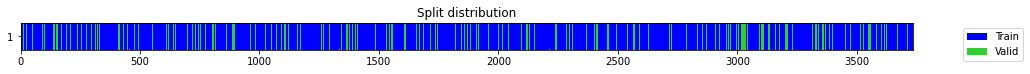

In [ ]:
split_indx = 30

print('Processing Volume data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ['Signal']
row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

test_targetdata={}
test_predsdata={}

test_targetdata={}
test_predsdata={}

print('splitting data..')
Vol_data = to3d(Vol.iloc[:,:].values)
# Temp_data = to3d(Temp.iloc[:,:].values)
data = np.concatenate([Vol_data, TS_D, TS_Y, TS_M],axis=1)  #, TS_Mend, TS_Mstart
data_X = data[:,:,:split_indx]
data_y = data[:,0,split_indx:]
X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
print('Standardizing data..')
for i in range(X_train.shape[1]): #normalize IN data
  scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
  X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
scalersOUT['Signal'] = StandardScaler() #normalize OUT data
y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
tfms  = [None, [ToFloat(), ToNumpyTensor()]]
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
#**************#**************#**************#**************#**************#**************#**************#**************

In [ ]:
study = optuna.create_study(direction='minimize')
print(f"Sampler is {study.sampler.__class__.__name__}")

tuning(model_name)

print("**Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("{}".format(value))

[I 2022-07-24 23:39:24,766] A new study created in memory with name: no-name-cee16b65-34e4-4719-bafb-10b9c1214a97


Sampler is TPESampler


[I 2022-07-24 23:39:30,744] Trial 0 finished with value: 0.29301920533180237 and parameters: {'bottleneck': True, 'coord': True, 'separable': False, 'zero_norm': False, 'nf': 24, 'ks': 60, 'conv_dropout': 0.40583839243725905, 'fc_dropout': 0.27107626668459034, 'learning_rate': 0.008302618682458117}. Best is trial 0 with value: 0.29301920533180237.
[I 2022-07-24 23:39:36,732] Trial 1 finished with value: 0.07246099412441254 and parameters: {'bottleneck': True, 'coord': False, 'separable': False, 'zero_norm': True, 'nf': 40, 'ks': 80, 'conv_dropout': 0.42023887100350465, 'fc_dropout': 0.2673720528510944, 'learning_rate': 9.201239103894959e-05}. Best is trial 1 with value: 0.07246099412441254.
[I 2022-07-24 23:39:42,570] Trial 2 finished with value: 0.248779296875 and parameters: {'bottleneck': False, 'coord': False, 'separable': False, 'zero_norm': False, 'nf': 56, 'ks': 20, 'conv_dropout': 0.23033159629098304, 'fc_dropout': 0.1414276908417127, 'learning_rate': 0.00450388624438303}. Best

**Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.03419403359293938
  Params: 
True
False
True
True
40
40
0.2125963456787202
0.19115732680102152
0.0006460689813781426


#### Model learning

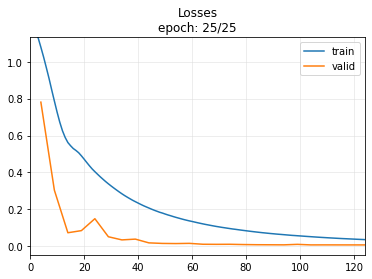

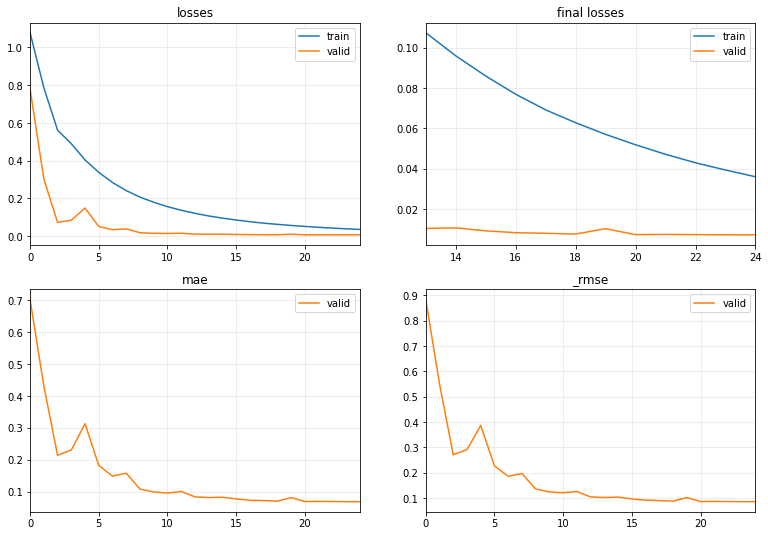

Targets and Predictions shapes (934, 30) (934, 30)
InceptionTimePlus : MAPE =  3.8682241827433654 MAE =  0.5906284054537433 RMSE =  0.7360903825141982


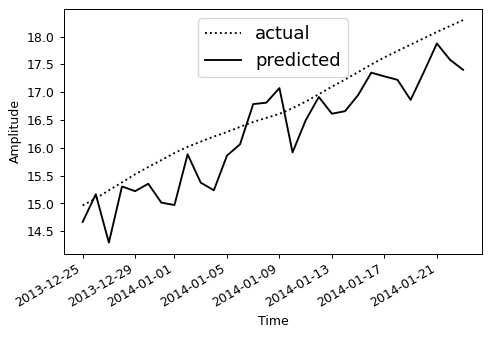

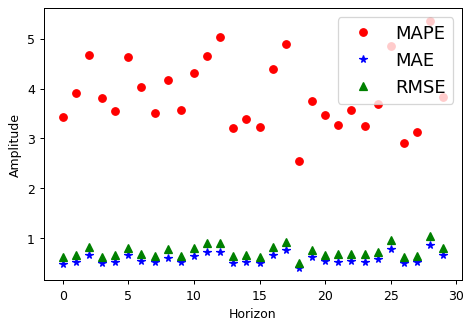

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

#Model learning
learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
learn.fit_one_cycle(freeze_epoch, learning_rate)
# #save trained model
# learn.save_all(path='/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export', dls_fname='dls', model_fname='WP_TIME_multistep_' + learn.model.__class__.__name__ + '_' + HOUSE, learner_fname='learner')
valid_dl = dls.valid

# Labeled test data
for i in range(X_test.shape[1]): #normalize IN data
  X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
y_test = scalersOUT['Signal'][0].transform(y_test)  
test_ds = valid_dl.dataset.add_test(X_test, y_test)
test_dl = valid_dl.new(test_ds)
_, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
#denormalize data
test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
del temp_targets, temp_preds
# RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
d = pd.DataFrame([])
d = test_targetdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', d, delimiter=',')
dp = pd.DataFrame([])
dp = test_predsdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', dp, delimiter=',')

#TEST MODEL
import numpy as np
import matplotlib.pyplot as plt
print('Targets and Predictions shapes', d.shape, dp.shape)

MAPE = []
MAE  = []
RMSE = []
for i in range(d.shape[1]): 
  MAPE.append(np.mean(np.abs((d[:,i] - dp[:,i]) / d[:,i]))*100)
  MAE.append(np.mean(np.abs((d[:,i] - dp[:,i]))))
  RMSE.append(np.sqrt(np.mean((d[:,i] - dp[:,i])**2)))
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], d[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dp[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### no VMD - Time info. only

In [ ]:
ind = ''
mode = 'Time_'
Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + season + '.csv',header=None)
Vol

0       1       2       3       4       5       6       7       8   \
0     26.405  26.496  26.582  26.672  26.770  26.867  26.940  27.013  27.095   
1     26.496  26.582  26.672  26.770  26.867  26.940  27.013  27.095  27.185   
2     26.582  26.672  26.770  26.867  26.940  27.013  27.095  27.185  27.286   
3     26.672  26.770  26.867  26.940  27.013  27.095  27.185  27.286  27.381   
4     26.770  26.867  26.940  27.013  27.095  27.185  27.286  27.381  27.463   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
4666  18.031  18.117  18.237  18.372  18.497  18.609  18.694  18.787  18.894   
4667  18.117  18.237  18.372  18.497  18.609  18.694  18.787  18.894  18.997   
4668  18.237  18.372  18.497  18.609  18.694  18.787  18.894  18.997  19.085   
4669  18.372  18.497  18.609  18.694  18.787  18.894  18.997  19.085  19.162   
4670  18.497  18.609  18.694  18.787  18.894  18.997  19.085  19.162  19.222   

          9   ...      50      51      52      53      54      55      56  \
0     27.185  ...  30.576  30.642  30.718  30.794  30.875  30.950  31.023   
1     27.286  ...  30.642  30.718  30.794  30.875  30.950  31.023  31.103   
2     27.381  ...  30.718  30.794  30.875  30.950  31.023  31.103  31.177   
3     27.463  ...  30.794  30.875  30.950  31.023  31.103  31.177  31.249   
4     27.552  ...  30.875  30.950  31.023  31.103  31.177  31.249  31.329   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
4666  18.997  ...  21.798  21.866  21.914  21.981  22.045  22.097  22.152   
4667  19.085  ...  21.866  21.914  21.981  22.045  22.097  22.152  22.235   
4668  19.162  ...  21.914  21.981  22.045  22.097  22.152  22.235  22.312   
4669  19.222  ...  21.981  22.045  22.097  22.152  22.235  22.312  22.348   
4670  19.294  ...  22.045  22.097  22.152  22.235  22.312  22.348  22.398   

          57      58      59  
0     31.103  31.177  31.249  
1     31.177  31.249  31.329  
2     31.249  31.329  31.391  
3     31.329  31.391  31.437  
4     31.391  31.437  31.491  
...      ...     ...     ...  
4666  22.235  22.312  22.348  
4667  22.312  22.348  22.398  
4668  22.348  22.398  22.441  
4669  22.398  22.441  22.489  
4670  22.441  22.489  22.544  

[4671 rows x 60 columns]

Processing Volume data..
splitting data..
Standardizing data..
training set:  (3737, 3, 30) (3737, 30) , testing set:  (934, 3, 30) (934, 30)


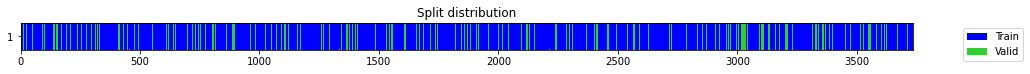

In [ ]:
split_indx = 30

print('Processing Volume data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ['Signal']
row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

test_targetdata={}
test_predsdata={}

test_targetdata={}
test_predsdata={}

print('splitting data..')
Vol_data = to3d(Vol.iloc[:,:].values)
data = np.concatenate([TS_D, TS_Y, TS_M],axis=1) 
data_X = data[:,:,:split_indx]
data_y = Vol_data[:,0,split_indx:]
X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
print('Standardizing data..')
for i in range(X_train.shape[1]): #normalize IN data
  scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
  X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
scalersOUT['Signal'] = StandardScaler() #normalize OUT data
y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
tfms  = [None, [ToFloat(), ToNumpyTensor()]]
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
#**************#**************#**************#**************#**************#**************#**************#**************

#### Model learning

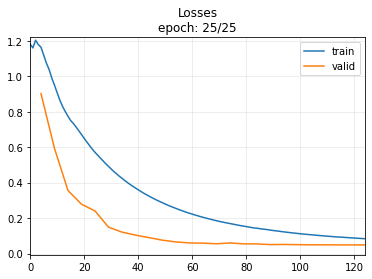

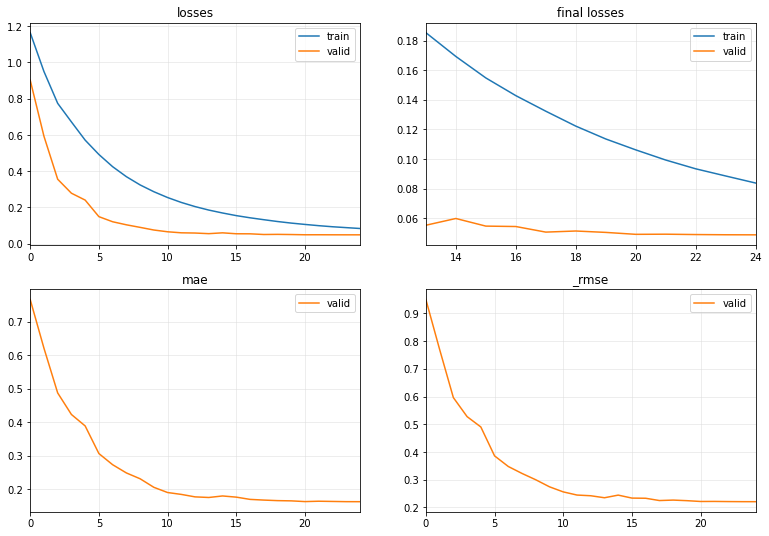

Targets and Predictions shapes (934, 30) (934, 30)
InceptionTimePlus : MAPE =  19.507618541800046 MAE =  3.1911975945694917 RMSE =  3.564433603281326


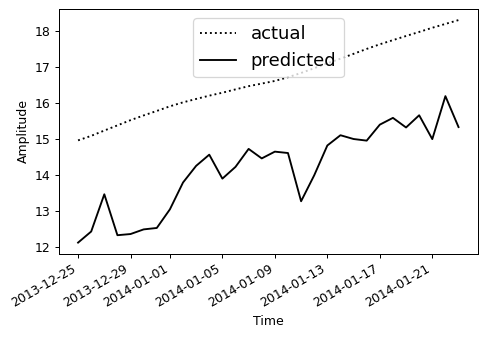

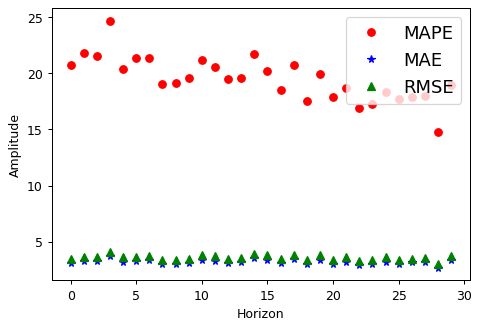

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

#Model learning
learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
learn.fit_one_cycle(freeze_epoch, learning_rate)
# #save trained model
# learn.save_all(path='/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export', dls_fname='dls', model_fname='WP_TIME_multistep_' + learn.model.__class__.__name__ + '_' + HOUSE, learner_fname='learner')
valid_dl = dls.valid

# Labeled test data
for i in range(X_test.shape[1]): #normalize IN data
  X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
y_test = scalersOUT['Signal'][0].transform(y_test)  
test_ds = valid_dl.dataset.add_test(X_test, y_test)
test_dl = valid_dl.new(test_ds)
_, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
#denormalize data
test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
del temp_targets, temp_preds
# RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
d = pd.DataFrame([])
d = test_targetdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', d, delimiter=',')
dp = pd.DataFrame([])
dp = test_predsdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', dp, delimiter=',')

#TEST MODEL
import numpy as np
import matplotlib.pyplot as plt
print('Targets and Predictions shapes', d.shape, dp.shape)

MAPE = []
MAE  = []
RMSE = []
for i in range(d.shape[1]): 
  MAPE.append(np.mean(np.abs((d[:,i] - dp[:,i]) / d[:,i]))*100)
  MAE.append(np.mean(np.abs((d[:,i] - dp[:,i]))))
  RMSE.append(np.sqrt(np.mean((d[:,i] - dp[:,i])**2)))
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], d[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dp[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### with VMD - Volume + time info.

In [ ]:
ind = '31IMFs';
mode = 'VolTime_'
Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + season + '.csv',header=None)
VMD_Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + ind + '_' + season + '.csv')
VMD_Vol = VMD_Vol.drop(columns='Element0')
Vol

0       1       2       3       4       5       6       7       8   \
0     26.405  26.496  26.582  26.672  26.770  26.867  26.940  27.013  27.095   
1     26.496  26.582  26.672  26.770  26.867  26.940  27.013  27.095  27.185   
2     26.582  26.672  26.770  26.867  26.940  27.013  27.095  27.185  27.286   
3     26.672  26.770  26.867  26.940  27.013  27.095  27.185  27.286  27.381   
4     26.770  26.867  26.940  27.013  27.095  27.185  27.286  27.381  27.463   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
4666  18.031  18.117  18.237  18.372  18.497  18.609  18.694  18.787  18.894   
4667  18.117  18.237  18.372  18.497  18.609  18.694  18.787  18.894  18.997   
4668  18.237  18.372  18.497  18.609  18.694  18.787  18.894  18.997  19.085   
4669  18.372  18.497  18.609  18.694  18.787  18.894  18.997  19.085  19.162   
4670  18.497  18.609  18.694  18.787  18.894  18.997  19.085  19.162  19.222   

          9   ...      50      51      52      53      54      55      56  \
0     27.185  ...  30.576  30.642  30.718  30.794  30.875  30.950  31.023   
1     27.286  ...  30.642  30.718  30.794  30.875  30.950  31.023  31.103   
2     27.381  ...  30.718  30.794  30.875  30.950  31.023  31.103  31.177   
3     27.463  ...  30.794  30.875  30.950  31.023  31.103  31.177  31.249   
4     27.552  ...  30.875  30.950  31.023  31.103  31.177  31.249  31.329   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
4666  18.997  ...  21.798  21.866  21.914  21.981  22.045  22.097  22.152   
4667  19.085  ...  21.866  21.914  21.981  22.045  22.097  22.152  22.235   
4668  19.162  ...  21.914  21.981  22.045  22.097  22.152  22.235  22.312   
4669  19.222  ...  21.981  22.045  22.097  22.152  22.235  22.312  22.348   
4670  19.294  ...  22.045  22.097  22.152  22.235  22.312  22.348  22.398   

          57      58      59  
0     31.103  31.177  31.249  
1     31.177  31.249  31.329  
2     31.249  31.329  31.391  
3     31.329  31.391  31.437  
4     31.391  31.437  31.491  
...      ...     ...     ...  
4666  22.235  22.312  22.348  
4667  22.312  22.348  22.398  
4668  22.348  22.398  22.441  
4669  22.398  22.441  22.489  
4670  22.441  22.489  22.544  

[4671 rows x 60 columns]

In [ ]:
split_indx = 30

print('Processing Vol and time data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ["IMF{}".format(x) for x in range (0,IMFS_count+1,1)]
row = ["feature{}".format(x) for x in np.array(range(5))]
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = {'n_layers':n_layers, 'bias':bias, 'rnn_dropout':rnn_dropout, 'bidirectional':bidirectional,'fc_dropout':fc_dropout, 'bn':bn}

temp_targets = {}
temp_preds = {}
test_targetdata={}
test_predsdata={}


Processing Vol and time data..


##### Model learning

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

for x in range(0,IMFS_count+1,1):
  print('-IMF',x,', splitting data..')
  Vol_data = to3d(VMD_Vol.iloc[x::IMFS_count+1,:].values)
  data = np.concatenate([Vol_data, TS_D, TS_Y, TS_M],axis=1) 
  data_X = data[:,:,:split_indx]
  data_y = data[:,0,split_indx:]
  X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
  y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
  print('Standardizing data..')
  for i in range(X_train.shape[1]): #normalize IN data
    scalersIN["IMF{}".format(x)]["feature{}".format(i)] = StandardScaler()
    X_train[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].fit_transform(X_train[:, i, :])    
  scalersOUT["IMF{}".format(x)] = StandardScaler() #normalize OUT data
  y_train = scalersOUT["IMF{}".format(x)][0].fit_transform(y_train)  
  print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

  splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
  tfms  = [None, [ToFloat(), ToNumpyTensor()]]
  dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
  # dsets[0]
  print('number of model outputs:', get_c(dls))
  # dls.show_batch(max_n=1)
  # model = create_model(model_name, dls=dls, **par)
  # learn = Learner(dls, model, metrics=[mae, rmse],cbs=[ShowGraph(),SaveModel()])
  learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
  # learn.model
  # learn.lr_find()
  learn.fit_one_cycle(freeze_epoch, learning_rate)
  #save trained model
  # learn.save_all(path='/content/gdrive/MyDrive/PowerForcasting/VeryShortTerm_LoadForecasting/export/', dls_fname='dls', model_fname='VMD_TIME_multistep'+ "IMF{}".format(x) + '_' + learn.model.__class__.__name__ + HOUSE, learner_fname='learner')
  valid_dl = dls.valid

  # Labeled test data
  for i in range(X_test.shape[1]): #normalize IN data
    X_test[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].transform(X_test[:, i, :])    
  y_test = scalersOUT["IMF{}".format(x)][0].transform(y_test)  
  test_ds = valid_dl.dataset.add_test(X_test, y_test)
  test_dl = valid_dl.new(test_ds)
  _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
  #denormalize data
  test_predsdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_preds)  
  test_targetdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_targets)      
d = pd.DataFrame([])
d = pd.DataFrame({k:list(v) for k,v in test_targetdata.items()})
d.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')
dp = pd.DataFrame([])
dp = pd.DataFrame({k:list(v) for k,v in test_predsdata.items()})
dp.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')

#TEST
dsum = d.sum(axis=1)
dpsum = dp.sum(axis=1)
print('Targets and Predictions shapes', dsum.shape, dpsum.shape)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mae_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))     
def rmse_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))
MAPE = mean_absolute_percentage_error(dsum, dpsum)    
MAE = mae_metric(dsum, dpsum)
RMSE = rmse_metric(dsum, dpsum)
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dsum[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dpsum[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude (W)')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### with EMD - Volume + time info.

In [ ]:
exec('bottleneck = True')
exec('coord = False')
exec('separable = True')
exec('zero_norm = True')
exec('nf = 40')
exec('ks = 40')
exec('conv_dropout = 0.21259634567872')
exec('fc_dropout = 0.191157326801021')
exec('learning_rate = 0.000646068981378142')

par = {'bottleneck':bottleneck,'coord':coord,'separable':separable,'zero_norm':zero_norm,'nf':nf,'ks':ks,'conv_dropout':conv_dropout,'fc_dropout':fc_dropout}

In [ ]:
ind = 'EMD4IMFs';
mode = 'VolTime_'
Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + season + '.csv',header=None)
VMD_Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + ind + '_' + season + '.csv')
VMD_Vol = VMD_Vol.drop(columns='Element0')
Vol

0       1       2       3       4       5       6       7       8   \
0     26.405  26.496  26.582  26.672  26.770  26.867  26.940  27.013  27.095   
1     26.496  26.582  26.672  26.770  26.867  26.940  27.013  27.095  27.185   
2     26.582  26.672  26.770  26.867  26.940  27.013  27.095  27.185  27.286   
3     26.672  26.770  26.867  26.940  27.013  27.095  27.185  27.286  27.381   
4     26.770  26.867  26.940  27.013  27.095  27.185  27.286  27.381  27.463   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
4666  18.031  18.117  18.237  18.372  18.497  18.609  18.694  18.787  18.894   
4667  18.117  18.237  18.372  18.497  18.609  18.694  18.787  18.894  18.997   
4668  18.237  18.372  18.497  18.609  18.694  18.787  18.894  18.997  19.085   
4669  18.372  18.497  18.609  18.694  18.787  18.894  18.997  19.085  19.162   
4670  18.497  18.609  18.694  18.787  18.894  18.997  19.085  19.162  19.222   

          9   ...      50      51      52      53      54      55      56  \
0     27.185  ...  30.576  30.642  30.718  30.794  30.875  30.950  31.023   
1     27.286  ...  30.642  30.718  30.794  30.875  30.950  31.023  31.103   
2     27.381  ...  30.718  30.794  30.875  30.950  31.023  31.103  31.177   
3     27.463  ...  30.794  30.875  30.950  31.023  31.103  31.177  31.249   
4     27.552  ...  30.875  30.950  31.023  31.103  31.177  31.249  31.329   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
4666  18.997  ...  21.798  21.866  21.914  21.981  22.045  22.097  22.152   
4667  19.085  ...  21.866  21.914  21.981  22.045  22.097  22.152  22.235   
4668  19.162  ...  21.914  21.981  22.045  22.097  22.152  22.235  22.312   
4669  19.222  ...  21.981  22.045  22.097  22.152  22.235  22.312  22.348   
4670  19.294  ...  22.045  22.097  22.152  22.235  22.312  22.348  22.398   

          57      58      59  
0     31.103  31.177  31.249  
1     31.177  31.249  31.329  
2     31.249  31.329  31.391  
3     31.329  31.391  31.437  
4     31.391  31.437  31.491  
...      ...     ...     ...  
4666  22.235  22.312  22.348  
4667  22.312  22.348  22.398  
4668  22.348  22.398  22.441  
4669  22.398  22.441  22.489  
4670  22.441  22.489  22.544  

[4671 rows x 60 columns]

In [ ]:
split_indx = 30

print('Processing Vol and time data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ["IMF{}".format(x) for x in range (0,IMFS_count+1,1)]
row = ["feature{}".format(x) for x in np.array(range(5))]
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

temp_targets = {}
temp_preds = {}
test_targetdata={}
test_predsdata={}


Processing Vol and time data..


##### Model learning

-IMF 0 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


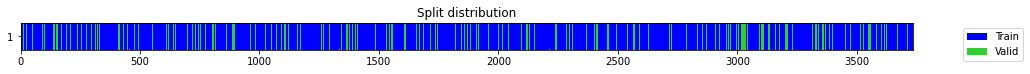

number of model outputs: 1


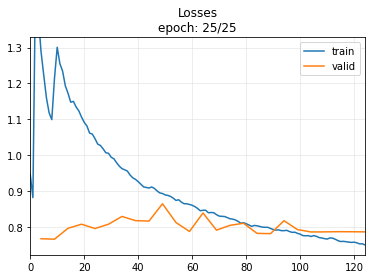

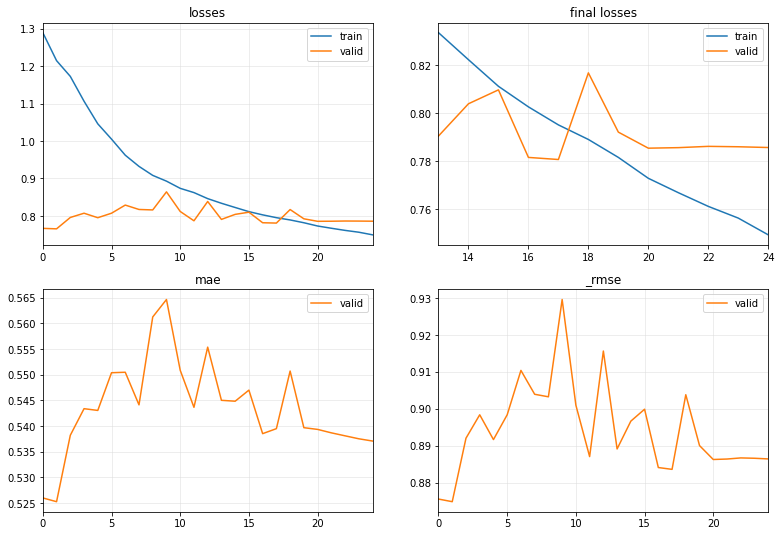

-IMF 1 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


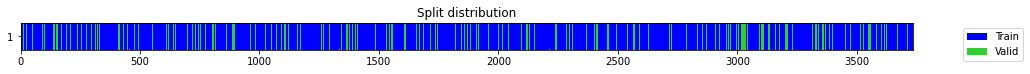

number of model outputs: 1


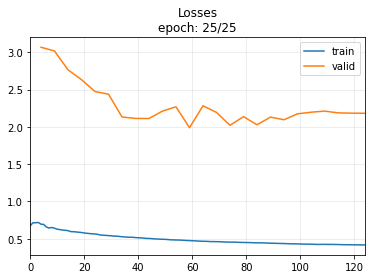

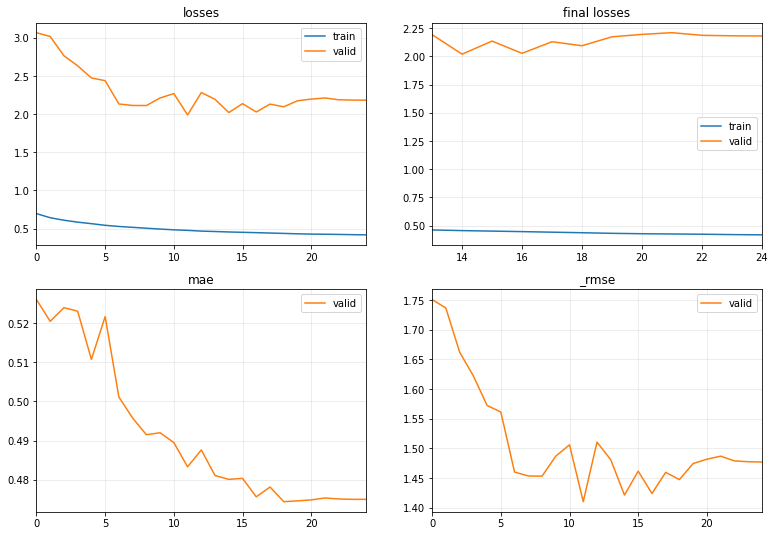

-IMF 2 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


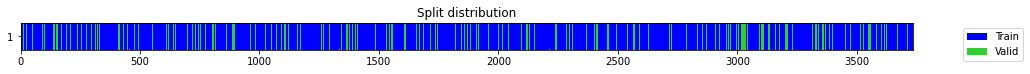

number of model outputs: 1


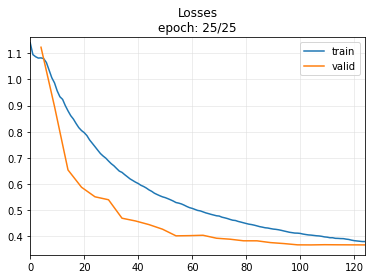

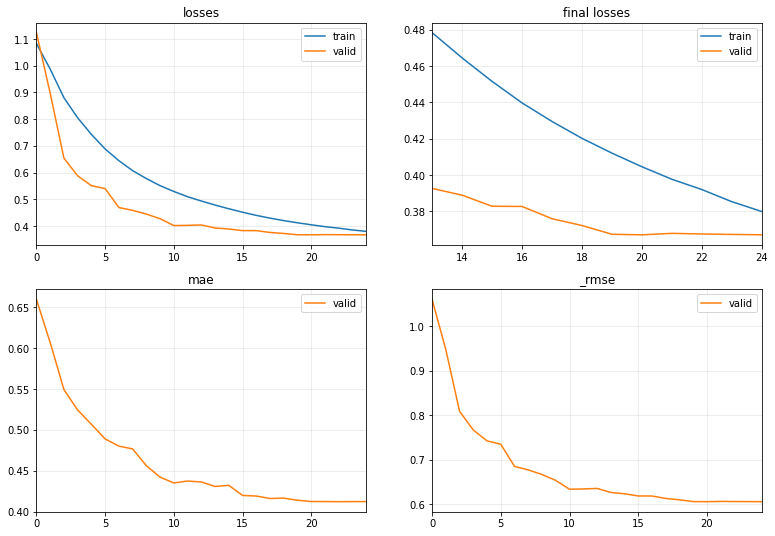

-IMF 3 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


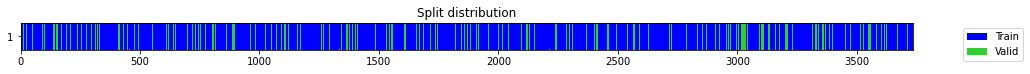

number of model outputs: 1


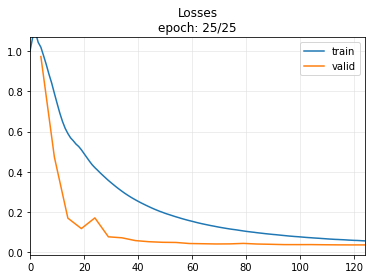

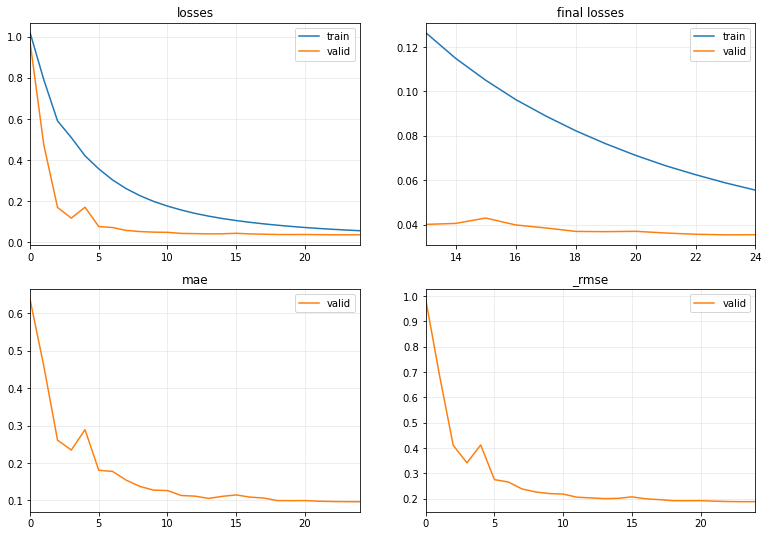

-IMF 4 , splitting data..
Standardizing data..
training set:  (3737, 4, 30) (3737, 30) , testing set:  (934, 4, 30) (934, 30)


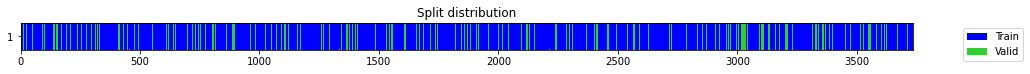

number of model outputs: 1


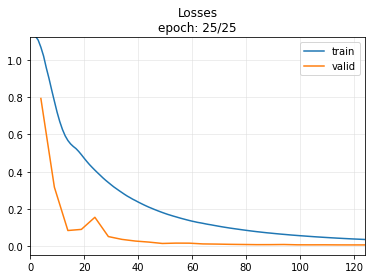

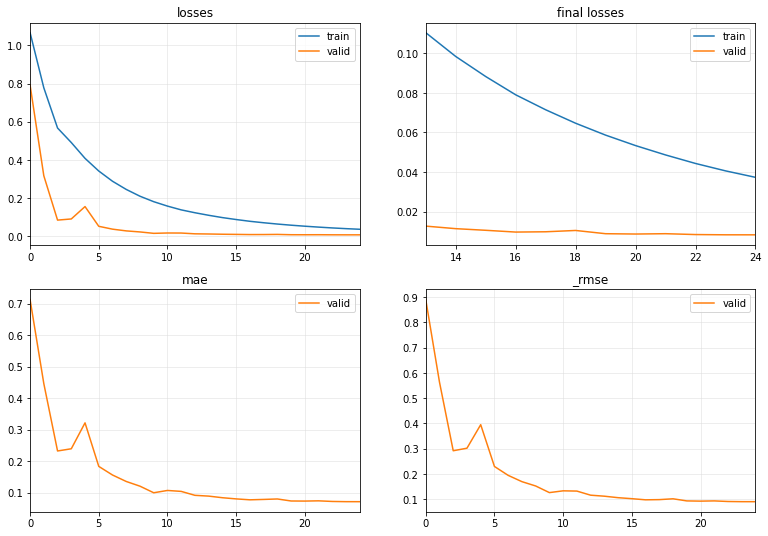

Targets and Predictions shapes (934,) (934,)
InceptionTimePlus : MAPE =  4.01073795629613 MAE =  0.6214621400862076 RMSE =  0.7645486895979462


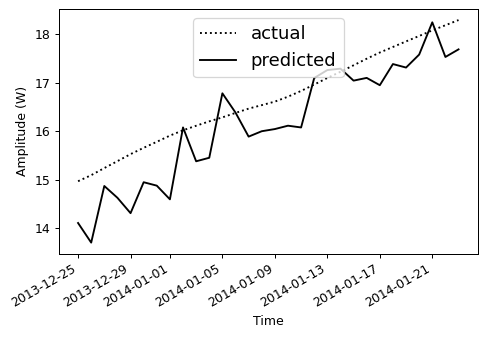

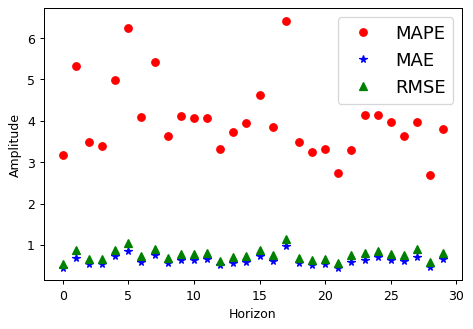

In [ ]:
for x in range(0,IMFS_count+1,1):
  print('-IMF',x,', splitting data..')
  Vol_data = to3d(VMD_Vol.iloc[x::IMFS_count+1,:].values)
  data = np.concatenate([Vol_data, TS_D, TS_Y, TS_M],axis=1) 
  data_X = data[:,:,:split_indx]
  data_y = data[:,0,split_indx:]
  X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
  y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
  print('Standardizing data..')
  for i in range(X_train.shape[1]): #normalize IN data
    scalersIN["IMF{}".format(x)]["feature{}".format(i)] = StandardScaler()
    X_train[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].fit_transform(X_train[:, i, :])    
  scalersOUT["IMF{}".format(x)] = StandardScaler() #normalize OUT data
  y_train = scalersOUT["IMF{}".format(x)][0].fit_transform(y_train)  
  print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

  splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
  tfms  = [None, [ToFloat(), ToNumpyTensor()]]
  dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
  # dsets[0]
  print('number of model outputs:', get_c(dls))
  # dls.show_batch(max_n=1)
  # model = create_model(model_name, dls=dls, **par)
  # learn = Learner(dls, model, metrics=[mae, rmse],cbs=[ShowGraph(),SaveModel()])
  learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
  # learn.model
  # learn.lr_find()
  learn.fit_one_cycle(freeze_epoch, learning_rate)
  #save trained model
  # learn.save_all(path='/content/gdrive/MyDrive/PowerForcasting/VeryShortTerm_LoadForecasting/export/', dls_fname='dls', model_fname='VMD_TIME_multistep'+ "IMF{}".format(x) + '_' + learn.model.__class__.__name__ + HOUSE, learner_fname='learner')
  valid_dl = dls.valid

  # Labeled test data
  for i in range(X_test.shape[1]): #normalize IN data
    X_test[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].transform(X_test[:, i, :])    
  y_test = scalersOUT["IMF{}".format(x)][0].transform(y_test)  
  test_ds = valid_dl.dataset.add_test(X_test, y_test)
  test_dl = valid_dl.new(test_ds)
  _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
  #denormalize data
  test_predsdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_preds)  
  test_targetdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_targets)      
d = pd.DataFrame([])
d = pd.DataFrame({k:list(v) for k,v in test_targetdata.items()})
d.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')
dp = pd.DataFrame([])
dp = pd.DataFrame({k:list(v) for k,v in test_predsdata.items()})
dp.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')

#TEST
dsum = d.sum(axis=1)
dpsum = dp.sum(axis=1)
print('Targets and Predictions shapes', dsum.shape, dpsum.shape)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mae_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))     
def rmse_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))
MAPE = mean_absolute_percentage_error(dsum, dpsum)    
MAE = mae_metric(dsum, dpsum)
RMSE = rmse_metric(dsum, dpsum)
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dsum[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dpsum[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude (W)')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


## season2

In [ ]:
season = season2

### no VMD - Volume + time info.

In [ ]:
ind = ''
mode = 'VolTime_'
Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + season + '.csv',header=None)
Vol

0       1       2       3       4       5       6       7       8   \
0     32.423  32.467  32.517  32.553  32.580  32.603  32.625  32.661  32.701   
1     32.467  32.517  32.553  32.580  32.603  32.625  32.661  32.701  32.725   
2     32.517  32.553  32.580  32.603  32.625  32.661  32.701  32.725  32.738   
3     32.553  32.580  32.603  32.625  32.661  32.701  32.725  32.738  32.767   
4     32.580  32.603  32.625  32.661  32.701  32.725  32.738  32.767  32.807   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
5799  23.184  23.132  23.082  23.028  22.987  22.977  22.975  22.946  22.913   
5800  23.132  23.082  23.028  22.987  22.977  22.975  22.946  22.913  22.871   
5801  23.082  23.028  22.987  22.977  22.975  22.946  22.913  22.871  22.809   
5802  23.028  22.987  22.977  22.975  22.946  22.913  22.871  22.809  22.717   
5803  22.987  22.977  22.975  22.946  22.913  22.871  22.809  22.717  22.617   

          9   ...      50      51      52      53      54      55      56  \
0     32.725  ...  32.564  32.518  32.471  32.430  32.377  32.327  32.281   
1     32.738  ...  32.518  32.471  32.430  32.377  32.327  32.281  32.218   
2     32.767  ...  32.471  32.430  32.377  32.327  32.281  32.218  32.165   
3     32.807  ...  32.430  32.377  32.327  32.281  32.218  32.165  32.121   
4     32.841  ...  32.377  32.327  32.281  32.218  32.165  32.121  32.080   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
5799  22.871  ...  16.915  16.723  16.497  16.238  15.980  15.714  15.433   
5800  22.809  ...  16.723  16.497  16.238  15.980  15.714  15.433  15.187   
5801  22.717  ...  16.497  16.238  15.980  15.714  15.433  15.187  14.954   
5802  22.617  ...  16.238  15.980  15.714  15.433  15.187  14.954  14.660   
5803  22.500  ...  15.980  15.714  15.433  15.187  14.954  14.660  14.330   

          57      58      59  
0     32.218  32.165  32.121  
1     32.165  32.121  32.080  
2     32.121  32.080  32.030  
3     32.080  32.030  31.970  
4     32.030  31.970  31.920  
...      ...     ...     ...  
5799  15.187  14.954  14.660  
5800  14.954  14.660  14.330  
5801  14.660  14.330  13.975  
5802  14.330  13.975  13.719  
5803  13.975  13.719  13.479  

[5804 rows x 60 columns]

#### Hyperparameter tuning

Processing Volume data..
splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


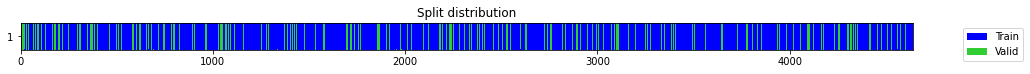

In [ ]:
split_indx = 30

print('Processing Volume data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ['Signal']
row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

test_targetdata={}
test_predsdata={}

test_targetdata={}
test_predsdata={}

print('splitting data..')
Vol_data = to3d(Vol.iloc[:,:].values)
# Temp_data = to3d(Temp.iloc[:,:].values)
data = np.concatenate([Vol_data, TS_D, TS_Y, TS_M],axis=1)  #, TS_Mend, TS_Mstart
data_X = data[:,:,:split_indx]
data_y = data[:,0,split_indx:]
X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
print('Standardizing data..')
for i in range(X_train.shape[1]): #normalize IN data
  scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
  X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
scalersOUT['Signal'] = StandardScaler() #normalize OUT data
y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
tfms  = [None, [ToFloat(), ToNumpyTensor()]]
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
#**************#**************#**************#**************#**************#**************#**************#**************

In [ ]:
study = optuna.create_study(direction='minimize')
print(f"Sampler is {study.sampler.__class__.__name__}")

tuning(model_name)

print("**Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("{}".format(value))

[I 2022-07-25 00:08:09,326] A new study created in memory with name: no-name-bdf556cb-d26b-4786-bb2c-c15f43e156b9


Sampler is TPESampler


[I 2022-07-25 00:08:16,816] Trial 0 finished with value: 0.038418252021074295 and parameters: {'bottleneck': False, 'coord': False, 'separable': True, 'zero_norm': True, 'nf': 16, 'ks': 60, 'conv_dropout': 0.012224913631241896, 'fc_dropout': 0.38310906722109833, 'learning_rate': 0.0040726309954814376}. Best is trial 0 with value: 0.038418252021074295.
[I 2022-07-25 00:08:24,051] Trial 1 finished with value: 0.038288626819849014 and parameters: {'bottleneck': False, 'coord': False, 'separable': False, 'zero_norm': True, 'nf': 56, 'ks': 60, 'conv_dropout': 0.18870471289628604, 'fc_dropout': 0.0334335817091162, 'learning_rate': 0.0006012682440269667}. Best is trial 1 with value: 0.038288626819849014.
[I 2022-07-25 00:08:31,284] Trial 2 finished with value: 0.036870334297418594 and parameters: {'bottleneck': True, 'coord': False, 'separable': True, 'zero_norm': False, 'nf': 32, 'ks': 80, 'conv_dropout': 0.4683090809652599, 'fc_dropout': 0.45986462898411246, 'learning_rate': 0.0047090116965

**Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.0257556289434433
  Params: 
True
False
False
True
56
20
0.37509668907173077
0.3622366784053868
0.0025816201067078784


#### Model learning

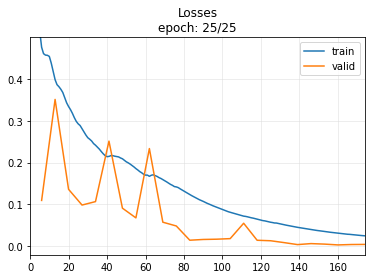

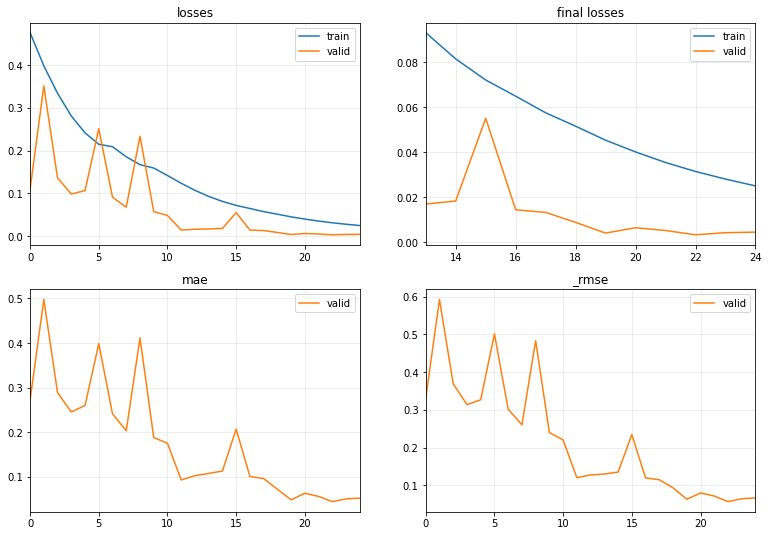

Targets and Predictions shapes (1160, 30) (1160, 30)
InceptionTimePlus : MAPE =  19.694325022433453 MAE =  1.5501694829240893 RMSE =  1.7343847819904794


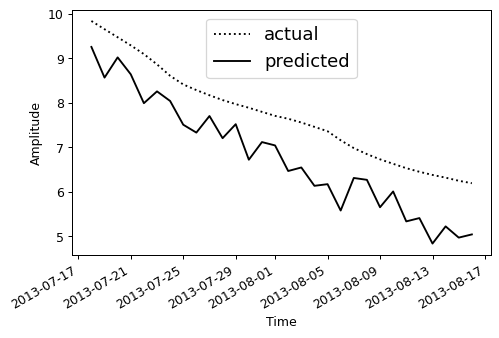

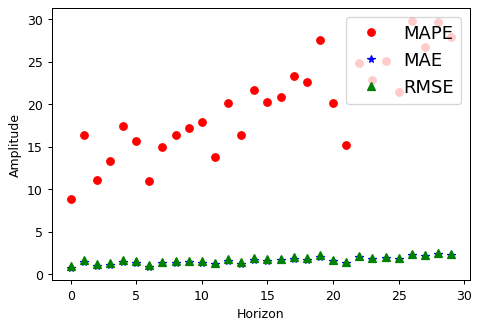

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

#Model learning
learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
learn.fit_one_cycle(freeze_epoch, learning_rate)
# #save trained model
# learn.save_all(path='/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export', dls_fname='dls', model_fname='WP_TIME_multistep_' + learn.model.__class__.__name__ + '_' + HOUSE, learner_fname='learner')
valid_dl = dls.valid

# Labeled test data
for i in range(X_test.shape[1]): #normalize IN data
  X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
y_test = scalersOUT['Signal'][0].transform(y_test)  
test_ds = valid_dl.dataset.add_test(X_test, y_test)
test_dl = valid_dl.new(test_ds)
_, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
#denormalize data
test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
del temp_targets, temp_preds
# RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
d = pd.DataFrame([])
d = test_targetdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', d, delimiter=',')
dp = pd.DataFrame([])
dp = test_predsdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', dp, delimiter=',')

#TEST MODEL
import numpy as np
import matplotlib.pyplot as plt
print('Targets and Predictions shapes', d.shape, dp.shape)

MAPE = []
MAE  = []
RMSE = []
for i in range(d.shape[1]): 
  MAPE.append(np.mean(np.abs((d[:,i] - dp[:,i]) / d[:,i]))*100)
  MAE.append(np.mean(np.abs((d[:,i] - dp[:,i]))))
  RMSE.append(np.sqrt(np.mean((d[:,i] - dp[:,i])**2)))
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], d[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dp[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### no VMD - Time info. only

In [ ]:
ind = ''
mode = 'Time_'
Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + season + '.csv',header=None)
Vol

0       1       2       3       4       5       6       7       8   \
0     32.423  32.467  32.517  32.553  32.580  32.603  32.625  32.661  32.701   
1     32.467  32.517  32.553  32.580  32.603  32.625  32.661  32.701  32.725   
2     32.517  32.553  32.580  32.603  32.625  32.661  32.701  32.725  32.738   
3     32.553  32.580  32.603  32.625  32.661  32.701  32.725  32.738  32.767   
4     32.580  32.603  32.625  32.661  32.701  32.725  32.738  32.767  32.807   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
5799  23.184  23.132  23.082  23.028  22.987  22.977  22.975  22.946  22.913   
5800  23.132  23.082  23.028  22.987  22.977  22.975  22.946  22.913  22.871   
5801  23.082  23.028  22.987  22.977  22.975  22.946  22.913  22.871  22.809   
5802  23.028  22.987  22.977  22.975  22.946  22.913  22.871  22.809  22.717   
5803  22.987  22.977  22.975  22.946  22.913  22.871  22.809  22.717  22.617   

          9   ...      50      51      52      53      54      55      56  \
0     32.725  ...  32.564  32.518  32.471  32.430  32.377  32.327  32.281   
1     32.738  ...  32.518  32.471  32.430  32.377  32.327  32.281  32.218   
2     32.767  ...  32.471  32.430  32.377  32.327  32.281  32.218  32.165   
3     32.807  ...  32.430  32.377  32.327  32.281  32.218  32.165  32.121   
4     32.841  ...  32.377  32.327  32.281  32.218  32.165  32.121  32.080   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
5799  22.871  ...  16.915  16.723  16.497  16.238  15.980  15.714  15.433   
5800  22.809  ...  16.723  16.497  16.238  15.980  15.714  15.433  15.187   
5801  22.717  ...  16.497  16.238  15.980  15.714  15.433  15.187  14.954   
5802  22.617  ...  16.238  15.980  15.714  15.433  15.187  14.954  14.660   
5803  22.500  ...  15.980  15.714  15.433  15.187  14.954  14.660  14.330   

          57      58      59  
0     32.218  32.165  32.121  
1     32.165  32.121  32.080  
2     32.121  32.080  32.030  
3     32.080  32.030  31.970  
4     32.030  31.970  31.920  
...      ...     ...     ...  
5799  15.187  14.954  14.660  
5800  14.954  14.660  14.330  
5801  14.660  14.330  13.975  
5802  14.330  13.975  13.719  
5803  13.975  13.719  13.479  

[5804 rows x 60 columns]

Processing Volume data..
splitting data..
Standardizing data..
training set:  (4644, 3, 30) (4644, 30) , testing set:  (1160, 3, 30) (1160, 30)


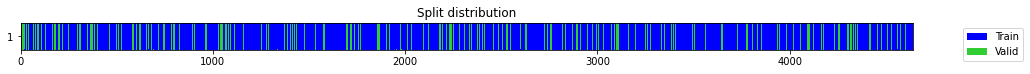

In [ ]:
split_indx = 30

print('Processing Volume data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ['Signal']
row = ["feature{}".format(x) for x in np.array(range(10))] #Change this number to higher if necessary!
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

test_targetdata={}
test_predsdata={}

test_targetdata={}
test_predsdata={}

print('splitting data..')
Vol_data = to3d(Vol.iloc[:,:].values)
data = np.concatenate([TS_D, TS_Y, TS_M],axis=1) 
data_X = data[:,:,:split_indx]
data_y = Vol_data[:,0,split_indx:]
X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
print('Standardizing data..')
for i in range(X_train.shape[1]): #normalize IN data
  scalersIN['Signal']["feature{}".format(i)] = StandardScaler()
  X_train[:, i, :] = scalersIN['Signal']["feature{}".format(i)].fit_transform(X_train[:, i, :])    
scalersOUT['Signal'] = StandardScaler() #normalize OUT data
y_train = scalersOUT['Signal'][0].fit_transform(y_train)  
print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
tfms  = [None, [ToFloat(), ToNumpyTensor()]]
dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])    
#**************#**************#**************#**************#**************#**************#**************#**************

#### Model learning

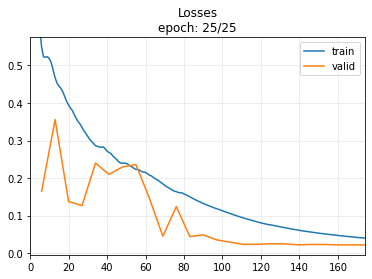

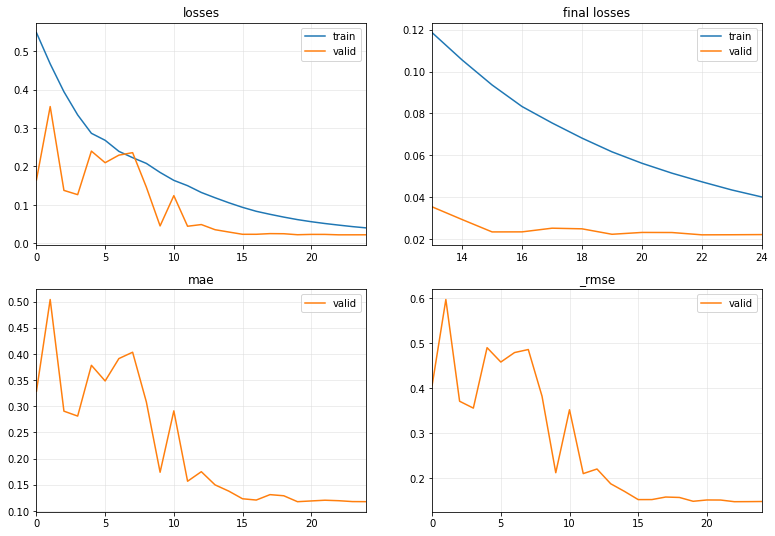

Targets and Predictions shapes (1160, 30) (1160, 30)
InceptionTimePlus : MAPE =  59.396624899368476 MAE =  4.904937061431353 RMSE =  5.281145614150806


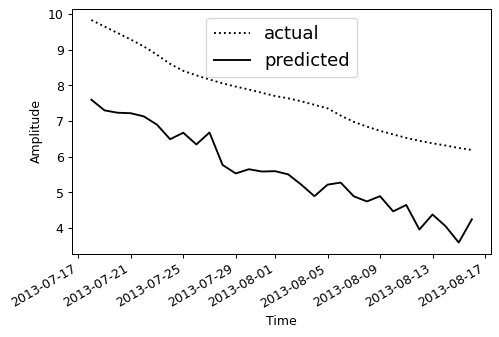

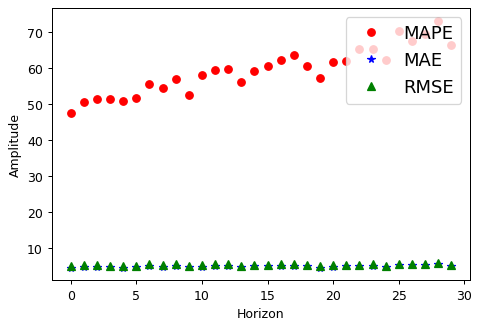

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

#Model learning
learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
learn.fit_one_cycle(freeze_epoch, learning_rate)
# #save trained model
# learn.save_all(path='/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export', dls_fname='dls', model_fname='WP_TIME_multistep_' + learn.model.__class__.__name__ + '_' + HOUSE, learner_fname='learner')
valid_dl = dls.valid

# Labeled test data
for i in range(X_test.shape[1]): #normalize IN data
  X_test[:, i, :] = scalersIN['Signal']["feature{}".format(i)].transform(X_test[:, i, :])    
y_test = scalersOUT['Signal'][0].transform(y_test)  
test_ds = valid_dl.dataset.add_test(X_test, y_test)
test_dl = valid_dl.new(test_ds)
_, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
#denormalize data
test_predsdata = scalersOUT['Signal'][0].inverse_transform(temp_preds)  
test_targetdata = scalersOUT['Signal'][0].inverse_transform(temp_targets)    
del temp_targets, temp_preds
# RMSE.append(rmse(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# MAE.append(mae(test_targetdata["test_targets"+str(x)].data, test_predsdata["test_preds"+str(x)].data))
# print(f'RMSE: {RMSE[x]:10.6f}, MAE: {MAE[x]:10.6f}')
d = pd.DataFrame([])
d = test_targetdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', d, delimiter=',')
dp = pd.DataFrame([])
dp = test_predsdata
np.savetxt('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv', dp, delimiter=',')

#TEST MODEL
import numpy as np
import matplotlib.pyplot as plt
print('Targets and Predictions shapes', d.shape, dp.shape)

MAPE = []
MAE  = []
RMSE = []
for i in range(d.shape[1]): 
  MAPE.append(np.mean(np.abs((d[:,i] - dp[:,i]) / d[:,i]))*100)
  MAE.append(np.mean(np.abs((d[:,i] - dp[:,i]))))
  RMSE.append(np.sqrt(np.mean((d[:,i] - dp[:,i])**2)))
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], d[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dp[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### with VMD - Volume + time info.

In [ ]:
ind = '31IMFs';
mode = 'VolTime_'

Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + season + '.csv',header=None)
VMD_Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + ind + '_' + season + '.csv')
VMD_Vol = VMD_Vol.drop(columns='Element0')
Vol

0       1       2       3       4       5       6       7       8   \
0     32.423  32.467  32.517  32.553  32.580  32.603  32.625  32.661  32.701   
1     32.467  32.517  32.553  32.580  32.603  32.625  32.661  32.701  32.725   
2     32.517  32.553  32.580  32.603  32.625  32.661  32.701  32.725  32.738   
3     32.553  32.580  32.603  32.625  32.661  32.701  32.725  32.738  32.767   
4     32.580  32.603  32.625  32.661  32.701  32.725  32.738  32.767  32.807   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
5799  23.184  23.132  23.082  23.028  22.987  22.977  22.975  22.946  22.913   
5800  23.132  23.082  23.028  22.987  22.977  22.975  22.946  22.913  22.871   
5801  23.082  23.028  22.987  22.977  22.975  22.946  22.913  22.871  22.809   
5802  23.028  22.987  22.977  22.975  22.946  22.913  22.871  22.809  22.717   
5803  22.987  22.977  22.975  22.946  22.913  22.871  22.809  22.717  22.617   

          9   ...      50      51      52      53      54      55      56  \
0     32.725  ...  32.564  32.518  32.471  32.430  32.377  32.327  32.281   
1     32.738  ...  32.518  32.471  32.430  32.377  32.327  32.281  32.218   
2     32.767  ...  32.471  32.430  32.377  32.327  32.281  32.218  32.165   
3     32.807  ...  32.430  32.377  32.327  32.281  32.218  32.165  32.121   
4     32.841  ...  32.377  32.327  32.281  32.218  32.165  32.121  32.080   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
5799  22.871  ...  16.915  16.723  16.497  16.238  15.980  15.714  15.433   
5800  22.809  ...  16.723  16.497  16.238  15.980  15.714  15.433  15.187   
5801  22.717  ...  16.497  16.238  15.980  15.714  15.433  15.187  14.954   
5802  22.617  ...  16.238  15.980  15.714  15.433  15.187  14.954  14.660   
5803  22.500  ...  15.980  15.714  15.433  15.187  14.954  14.660  14.330   

          57      58      59  
0     32.218  32.165  32.121  
1     32.165  32.121  32.080  
2     32.121  32.080  32.030  
3     32.080  32.030  31.970  
4     32.030  31.970  31.920  
...      ...     ...     ...  
5799  15.187  14.954  14.660  
5800  14.954  14.660  14.330  
5801  14.660  14.330  13.975  
5802  14.330  13.975  13.719  
5803  13.975  13.719  13.479  

[5804 rows x 60 columns]

In [ ]:
split_indx = 30

print('Processing Vol and time data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ["IMF{}".format(x) for x in range (0,IMFS_count+1,1)]
row = ["feature{}".format(x) for x in np.array(range(5))]
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = {'n_layers':n_layers, 'bias':bias, 'rnn_dropout':rnn_dropout, 'bidirectional':bidirectional,'fc_dropout':fc_dropout, 'bn':bn}

temp_targets = {}
temp_preds = {}
test_targetdata={}
test_predsdata={}


Processing Vol and time data..


##### Model learning

In [ ]:
# Get the best nf and dropout rate from the best trial object
trial = study.best_trial
for key, value in trial.params.items():
  if  key != 'act':
    exec('{} = {}'.format(key,value))
  if key == 'act':
    exec("act = '%s'" % (value))

par = tuned_hyperparameters(model_name)

for x in range(0,IMFS_count+1,1):
  print('-IMF',x,', splitting data..')
  Vol_data = to3d(VMD_Vol.iloc[x::IMFS_count+1,:].values)
  data = np.concatenate([Vol_data, TS_D, TS_Y, TS_M],axis=1) 
  data_X = data[:,:,:split_indx]
  data_y = data[:,0,split_indx:]
  X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
  y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
  print('Standardizing data..')
  for i in range(X_train.shape[1]): #normalize IN data
    scalersIN["IMF{}".format(x)]["feature{}".format(i)] = StandardScaler()
    X_train[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].fit_transform(X_train[:, i, :])    
  scalersOUT["IMF{}".format(x)] = StandardScaler() #normalize OUT data
  y_train = scalersOUT["IMF{}".format(x)][0].fit_transform(y_train)  
  print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

  splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
  tfms  = [None, [ToFloat(), ToNumpyTensor()]]
  dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
  # dsets[0]
  print('number of model outputs:', get_c(dls))
  # dls.show_batch(max_n=1)
  # model = create_model(model_name, dls=dls, **par)
  # learn = Learner(dls, model, metrics=[mae, rmse],cbs=[ShowGraph(),SaveModel()])
  learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
  # learn.model
  # learn.lr_find()
  learn.fit_one_cycle(freeze_epoch, learning_rate)
  #save trained model
  # learn.save_all(path='/content/gdrive/MyDrive/PowerForcasting/VeryShortTerm_LoadForecasting/export/', dls_fname='dls', model_fname='VMD_TIME_multistep'+ "IMF{}".format(x) + '_' + learn.model.__class__.__name__ + HOUSE, learner_fname='learner')
  valid_dl = dls.valid

  # Labeled test data
  for i in range(X_test.shape[1]): #normalize IN data
    X_test[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].transform(X_test[:, i, :])    
  y_test = scalersOUT["IMF{}".format(x)][0].transform(y_test)  
  test_ds = valid_dl.dataset.add_test(X_test, y_test)
  test_dl = valid_dl.new(test_ds)
  _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
  #denormalize data
  test_predsdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_preds)  
  test_targetdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_targets)      
d = pd.DataFrame([])
d = pd.DataFrame({k:list(v) for k,v in test_targetdata.items()})
d.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')
dp = pd.DataFrame([])
dp = pd.DataFrame({k:list(v) for k,v in test_predsdata.items()})
dp.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')

#TEST
dsum = d.sum(axis=1)
dpsum = dp.sum(axis=1)
print('Targets and Predictions shapes', dsum.shape, dpsum.shape)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mae_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))     
def rmse_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))
MAPE = mean_absolute_percentage_error(dsum, dpsum)    
MAE = mae_metric(dsum, dpsum)
RMSE = rmse_metric(dsum, dpsum)
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dsum[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dpsum[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude (W)')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()


### with EMD - Volume + time info.

In [ ]:
exec('bottleneck = True')
exec('coord = False')
exec('separable = False')
exec('zero_norm = True')
exec('nf = 56')
exec('ks = 20')
exec('conv_dropout = 0.37509668907173')
exec('fc_dropout = 0.362236678405386')
exec('learning_rate = 0.00258162010670787')

par = {'bottleneck':bottleneck,'coord':coord,'separable':separable,'zero_norm':zero_norm,'nf':nf,'ks':ks,'conv_dropout':conv_dropout,'fc_dropout':fc_dropout}

In [ ]:
ind = 'EMD4IMFs';
mode = 'VolTime_'

Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + season + '.csv',header=None)
VMD_Vol = pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_Volsequences_' + ind + '_' + season + '.csv')
VMD_Vol = VMD_Vol.drop(columns='Element0')
Vol

0       1       2       3       4       5       6       7       8   \
0     32.423  32.467  32.517  32.553  32.580  32.603  32.625  32.661  32.701   
1     32.467  32.517  32.553  32.580  32.603  32.625  32.661  32.701  32.725   
2     32.517  32.553  32.580  32.603  32.625  32.661  32.701  32.725  32.738   
3     32.553  32.580  32.603  32.625  32.661  32.701  32.725  32.738  32.767   
4     32.580  32.603  32.625  32.661  32.701  32.725  32.738  32.767  32.807   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
5799  23.184  23.132  23.082  23.028  22.987  22.977  22.975  22.946  22.913   
5800  23.132  23.082  23.028  22.987  22.977  22.975  22.946  22.913  22.871   
5801  23.082  23.028  22.987  22.977  22.975  22.946  22.913  22.871  22.809   
5802  23.028  22.987  22.977  22.975  22.946  22.913  22.871  22.809  22.717   
5803  22.987  22.977  22.975  22.946  22.913  22.871  22.809  22.717  22.617   

          9   ...      50      51      52      53      54      55      56  \
0     32.725  ...  32.564  32.518  32.471  32.430  32.377  32.327  32.281   
1     32.738  ...  32.518  32.471  32.430  32.377  32.327  32.281  32.218   
2     32.767  ...  32.471  32.430  32.377  32.327  32.281  32.218  32.165   
3     32.807  ...  32.430  32.377  32.327  32.281  32.218  32.165  32.121   
4     32.841  ...  32.377  32.327  32.281  32.218  32.165  32.121  32.080   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
5799  22.871  ...  16.915  16.723  16.497  16.238  15.980  15.714  15.433   
5800  22.809  ...  16.723  16.497  16.238  15.980  15.714  15.433  15.187   
5801  22.717  ...  16.497  16.238  15.980  15.714  15.433  15.187  14.954   
5802  22.617  ...  16.238  15.980  15.714  15.433  15.187  14.954  14.660   
5803  22.500  ...  15.980  15.714  15.433  15.187  14.954  14.660  14.330   

          57      58      59  
0     32.218  32.165  32.121  
1     32.165  32.121  32.080  
2     32.121  32.080  32.030  
3     32.080  32.030  31.970  
4     32.030  31.970  31.920  
...      ...     ...     ...  
5799  15.187  14.954  14.660  
5800  14.954  14.660  14.330  
5801  14.660  14.330  13.975  
5802  14.330  13.975  13.719  
5803  13.975  13.719  13.479  

[5804 rows x 60 columns]

In [ ]:
split_indx = 30

print('Processing Vol and time data..')

def get_day(x):
    return x.day
def get_month(x):
    return x.month    
def get_year(x):
    return x.year    
# def get_ismonthstart(x):
#     return x.is_month_start

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
col = ["IMF{}".format(x) for x in range (0,IMFS_count+1,1)]
row = ["feature{}".format(x) for x in np.array(range(5))]
scalersIN = pd.DataFrame([], columns = col, index = row)
scalersOUT = pd.DataFrame([], columns = col, index = [0])
from sklearn.preprocessing import OrdinalEncoder
#read TS data as datetime
TS =  pd.read_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/ICEF1m_TSsequences_' + season + '.csv',header=None)
cols = TS.columns[:]
TS[cols] = TS[cols].apply(pd.to_datetime, errors='coerce')
TS_data = TS.iloc[:,:] # Train set 
TS_D = TS_data.applymap(get_day)
TS_Y = TS_data.applymap(get_year)
TS_M = TS_data.applymap(get_month)
# TS_Mstart = TS_data.applymap(get_ismonthstart)

# define ordinal encoding
encoder_H = OrdinalEncoder()
encoder_D = OrdinalEncoder()
encoder_month = OrdinalEncoder()
# encoder_monthstart = OrdinalEncoder()
# transform data
TS_D = to3d(encoder_H.fit_transform(TS_D))
TS_Y = to3d(encoder_D.fit_transform(TS_Y))
TS_M = to3d(encoder_month.fit_transform(TS_M))
# TS_Mstart = to3d(encoder_monthstart.fit_transform(TS_Mstart))

temp_targets = {}
temp_preds = {}
test_targetdata={}
test_predsdata={}


Processing Vol and time data..


##### Model learning

-IMF 0 , splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


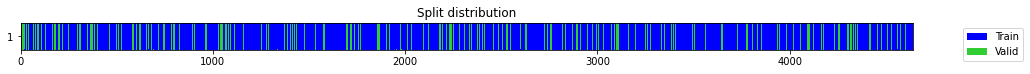

number of model outputs: 1


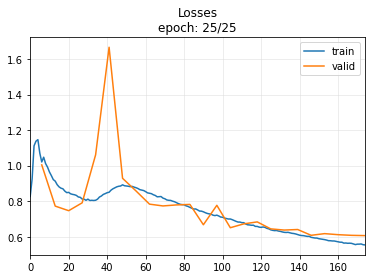

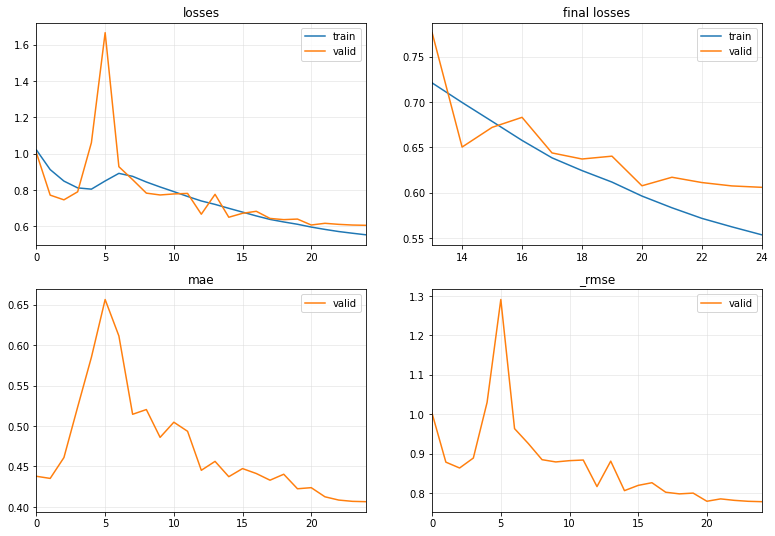

-IMF 1 , splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


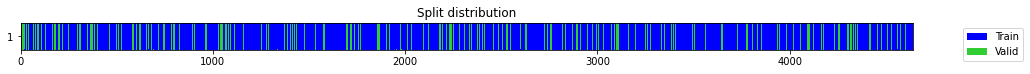

number of model outputs: 1


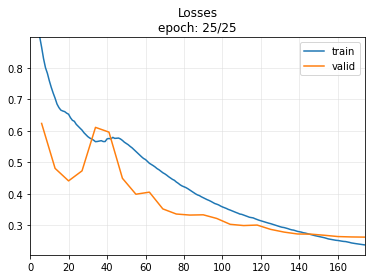

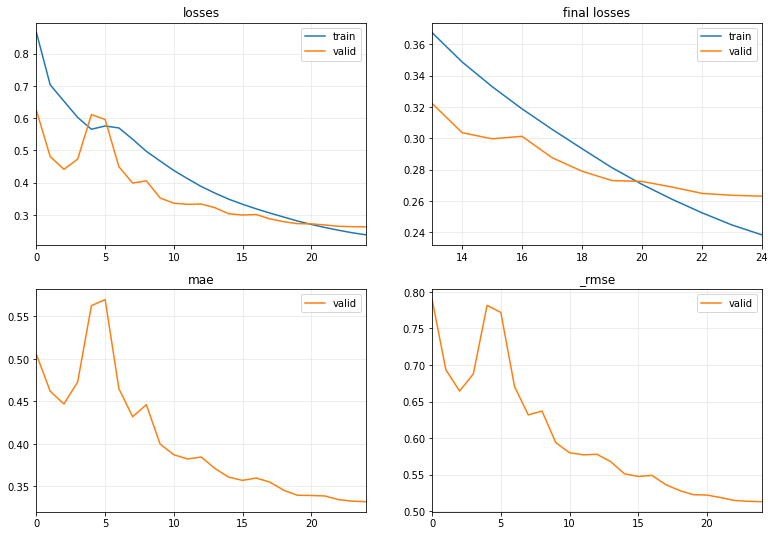

-IMF 2 , splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


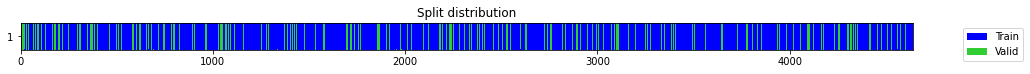

number of model outputs: 1


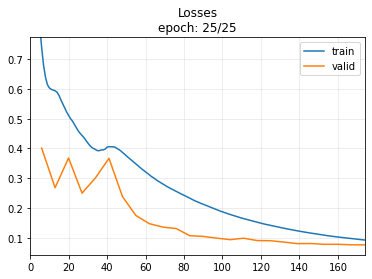

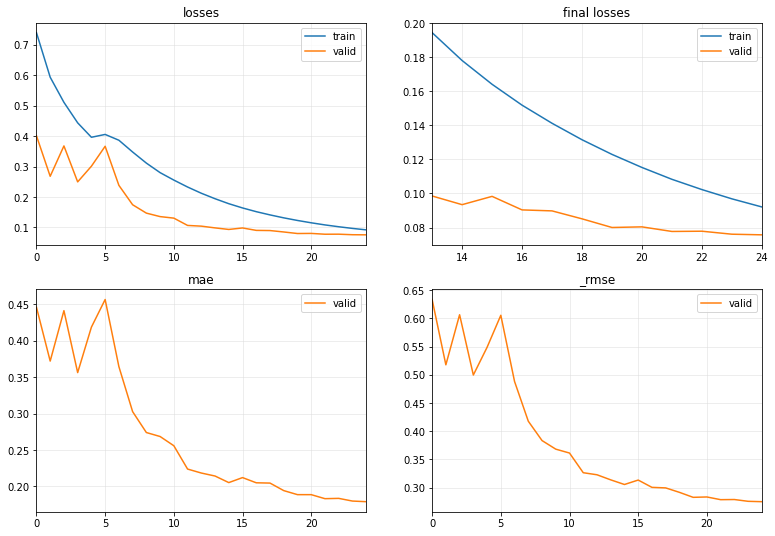

-IMF 3 , splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


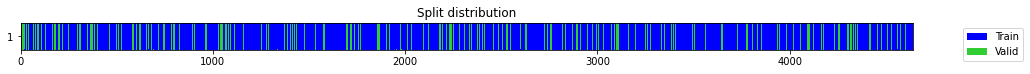

number of model outputs: 1


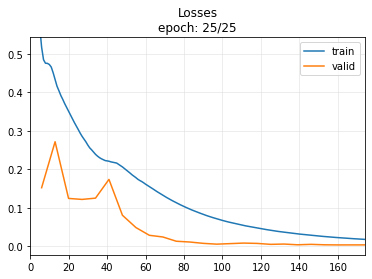

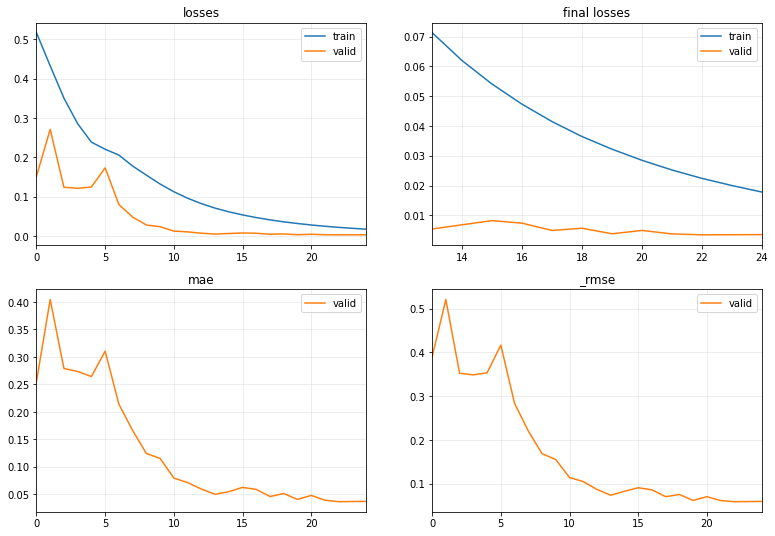

-IMF 4 , splitting data..
Standardizing data..
training set:  (4644, 4, 30) (4644, 30) , testing set:  (1160, 4, 30) (1160, 30)


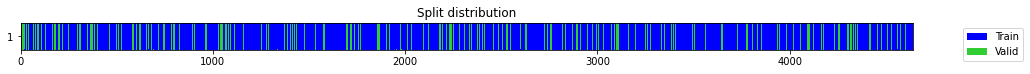

number of model outputs: 1


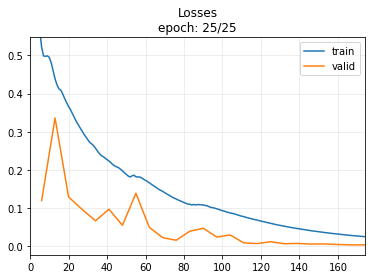

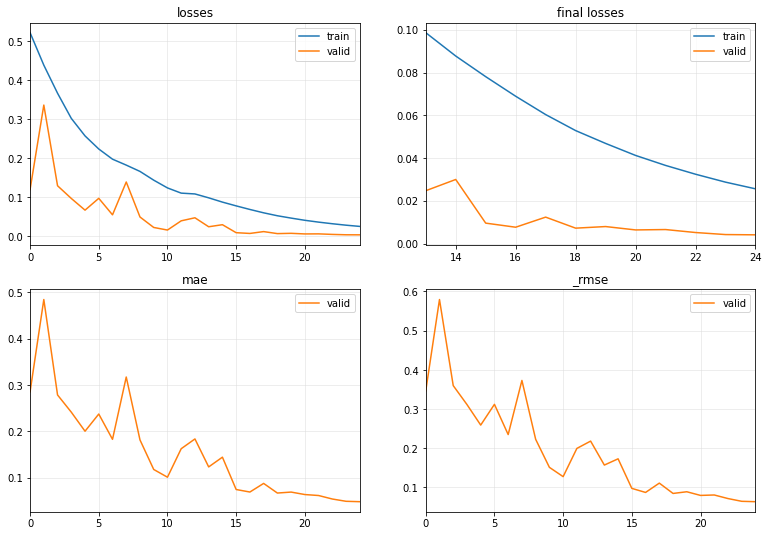

Targets and Predictions shapes (1160,) (1160,)
InceptionTimePlus : MAPE =  18.934696425585823 MAE =  1.366408367484259 RMSE =  1.5998869857104625


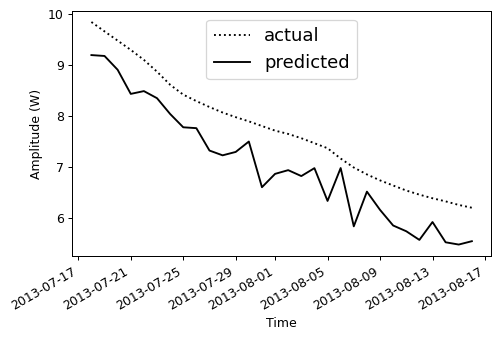

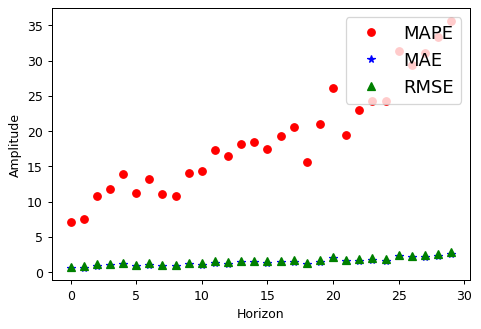

In [ ]:
for x in range(0,IMFS_count+1,1):
  print('-IMF',x,', splitting data..')
  Vol_data = to3d(VMD_Vol.iloc[x::IMFS_count+1,:].values)
  data = np.concatenate([Vol_data, TS_D, TS_Y, TS_M],axis=1) 
  data_X = data[:,:,:split_indx]
  data_y = data[:,0,split_indx:]
  X_train, X_test = data_X[:TS.shape[0]-int(TS.shape[0]*20/100)], data_X[-int(TS.shape[0]*20/100):]
  y_train, y_test = data_y[:TS.shape[0]-int(TS.shape[0]*20/100)], data_y[-int(TS.shape[0]*20/100):]
  print('Standardizing data..')
  for i in range(X_train.shape[1]): #normalize IN data
    scalersIN["IMF{}".format(x)]["feature{}".format(i)] = StandardScaler()
    X_train[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].fit_transform(X_train[:, i, :])    
  scalersOUT["IMF{}".format(x)] = StandardScaler() #normalize OUT data
  y_train = scalersOUT["IMF{}".format(x)][0].fit_transform(y_train)  
  print('training set: ',X_train.shape, y_train.shape, ', testing set: ',X_test.shape, y_test.shape)

  splits = get_splits(y_train, valid_size=.2, stratify=False, random_state=42, shuffle=True)
  tfms  = [None, [ToFloat(), ToNumpyTensor()]]
  dsets = TSDatasets(X_train, y_train, tfms=tfms, splits=splits, inplace=True)
  dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
  # dsets[0]
  print('number of model outputs:', get_c(dls))
  # dls.show_batch(max_n=1)
  # model = create_model(model_name, dls=dls, **par)
  # learn = Learner(dls, model, metrics=[mae, rmse],cbs=[ShowGraph(),SaveModel()])
  learn = TSForecaster(X_train, y_train, splits=splits, tfms=tfms, bs=512, arch=model_name, arch_config=par, metrics=[mae, rmse], cbs=[ShowGraph(),SaveModel()])
  # learn.model
  # learn.lr_find()
  learn.fit_one_cycle(freeze_epoch, learning_rate)
  #save trained model
  # learn.save_all(path='/content/gdrive/MyDrive/PowerForcasting/VeryShortTerm_LoadForecasting/export/', dls_fname='dls', model_fname='VMD_TIME_multistep'+ "IMF{}".format(x) + '_' + learn.model.__class__.__name__ + HOUSE, learner_fname='learner')
  valid_dl = dls.valid

  # Labeled test data
  for i in range(X_test.shape[1]): #normalize IN data
    X_test[:, i, :] = scalersIN["IMF{}".format(x)]["feature{}".format(i)].transform(X_test[:, i, :])    
  y_test = scalersOUT["IMF{}".format(x)][0].transform(y_test)  
  test_ds = valid_dl.dataset.add_test(X_test, y_test)
  test_dl = valid_dl.new(test_ds)
  _, temp_targets, temp_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
  #denormalize data
  test_predsdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_preds)  
  test_targetdata["IMF{}".format(x)] = scalersOUT["IMF{}".format(x)][0].inverse_transform(temp_targets)      
d = pd.DataFrame([])
d = pd.DataFrame({k:list(v) for k,v in test_targetdata.items()})
d.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_targetdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')
dp = pd.DataFrame([])
dp = pd.DataFrame({k:list(v) for k,v in test_predsdata.items()})
dp.to_csv('/content/gdrive/MyDrive/ARCTICseaForecasting/PIOMAS/export/test_predsdata_VOLF1m_' + mode + model_name.__name__ + ind + '_' + season + '.csv')

#TEST
dsum = d.sum(axis=1)
dpsum = dp.sum(axis=1)
print('Targets and Predictions shapes', dsum.shape, dpsum.shape)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mae_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))     
def rmse_metric(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))
MAPE = mean_absolute_percentage_error(dsum, dpsum)    
MAE = mae_metric(dsum, dpsum)
RMSE = rmse_metric(dsum, dpsum)
print(learn.model.__class__.__name__,': MAPE = ',np.mean(MAPE), 'MAE = ',np.mean(MAE), 'RMSE = ',np.mean(RMSE))

# Create plots with pre-defined labels.
fig, ax = plt.subplots(dpi = 90)
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dsum[0][:], 'k:', label='actual')
ax.plot_date(TS.iloc[TS.shape[0]-int(TS.shape[0]*20/100), split_indx:], dpsum[0][:], 'k-', label='predicted')
plt.ylabel('Amplitude (W)')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
legend = ax.legend(loc='upper center',fontsize='x-large')

plt.show()

# Create plots with pre-defined labels.
fig_step, ax_step = plt.subplots(dpi = 90)
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAPE, 'ro', label='MAPE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),MAE, 'b*', label='MAE')
ax_step.plot(np.array(range(TS.shape[1] - split_indx)),RMSE, 'g^', label='RMSE')
plt.ylabel('Amplitude')
plt.xlabel('Horizon')
legend = ax_step.legend(loc='upper right',fontsize='x-large')

plt.show()
